In [1]:
import sys
import os
import subprocess
import re
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
import traceback
import hashlib
import math
import collections
import functools

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt
import seaborn as sns

/home/vrabel/EUSO-Balloon/vrabel/venv/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v3
import event_processing_v4
import postgresql_v3_event_storage
import dataset_query_functions_v3

import tool.acqconv
from data_analysis_utils import *
from data_analysis_utils_dataframes import *
# import supervised_classification as supc    

Welcome to JupyROOT 6.13/02


# Initializations

In [3]:
vis_events_line_colors = ['#FF00FF','#0000FF','#00FFFF','#80FF00','#FF8000','#FF0000','yellow']
vis_events_line_columns_x_y = [('proc2_x_y_hough_peak_thr2_major_line_rho','proc2_x_y_hough_peak_thr2_major_line_phi'),
                               ('proc2_x_y_hough_peak_thr3_major_line_rho','proc2_x_y_hough_peak_thr3_major_line_phi'),
#                                ('proc2_x_y_hough_peak_thr4_major_line_rho','proc2_x_y_hough_peak_thr4_major_line_phi'),
                               ('proc3_x_y_hough_peak_thr2_major_line_rho','proc3_x_y_hough_peak_thr2_major_line_phi'),
                               ('proc3_x_y_hough_peak_thr3_major_line_rho','proc3_x_y_hough_peak_thr3_major_line_phi'),
#                                ('proc3_x_y_hough_peak_thr4_major_line_rho','proc3_x_y_hough_peak_thr4_major_line_phi'),
                               ('alt1_x_y_hough_peak_thr1_major_line_rho','alt1_x_y_hough_peak_thr1_major_line_phi')
                              ] 
vis_events_line_columns_gtu_x = [('proc2_gtu_x_hough_peak_thr2_major_line_rho','proc2_gtu_x_hough_peak_thr2_major_line_phi'),
                                 ('proc2_gtu_x_hough_peak_thr3_major_line_rho','proc2_gtu_x_hough_peak_thr3_major_line_phi'),
#                                  ('proc2_gtu_x_hough_peak_thr4_major_line_rho','proc2_gtu_x_hough_peak_thr4_major_line_phi'),
                                 ('proc3_gtu_x_hough_peak_thr2_major_line_rho','proc3_gtu_x_hough_peak_thr2_major_line_phi'),
                                 ('proc3_gtu_x_hough_peak_thr3_major_line_rho','proc3_gtu_x_hough_peak_thr3_major_line_phi'),
#                                  ('proc3_gtu_x_hough_peak_thr4_major_line_rho','proc3_gtu_x_hough_peak_thr4_major_line_phi'),
                                 ('alt1_gtu_x_hough_peak_thr1_major_line_rho','alt1_gtu_x_hough_peak_thr1_major_line_phi')
                                ] 
vis_events_line_columns_gtu_y = [('proc2_gtu_y_hough_peak_thr2_major_line_rho','proc2_gtu_y_hough_peak_thr2_major_line_phi'),
                                 ('proc2_gtu_y_hough_peak_thr3_major_line_rho','proc2_gtu_y_hough_peak_thr3_major_line_phi'),
#                                  ('proc2_gtu_y_hough_peak_thr4_major_line_rho','proc2_gtu_y_hough_peak_thr4_major_line_phi'),
                                 ('proc3_gtu_y_hough_peak_thr2_major_line_rho','proc3_gtu_y_hough_peak_thr2_major_line_phi'),
                                 ('proc3_gtu_y_hough_peak_thr3_major_line_rho','proc3_gtu_y_hough_peak_thr3_major_line_phi'),
#                                  ('proc3_gtu_y_hough_peak_thr4_major_line_rho','proc3_gtu_y_hough_peak_thr4_major_line_phi'),
                                 ('alt1_gtu_y_hough_peak_thr1_major_line_rho','alt1_gtu_y_hough_peak_thr1_major_line_phi')
                                ] 
vis_events_line_names = [os.path.commonprefix([col_rho,col_phi])[:-1] for col_rho, col_phi in vis_events_line_columns_x_y]

# Data sources

In [4]:
data_snippets_dir = 'ver4_machine_learning_w_labeled_flight_20181129'
os.makedirs(data_snippets_dir, exist_ok=True)

In [5]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_simu = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_simu_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls
)

query_functions_simu = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_simu)

In [6]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_flight = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls
)

query_functions_flight = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_flight)

## Selected columns

In [7]:
common_included_columns_re_list = [
  ('^$','source_file_(acquisition|trigger)(_full)?|global_gtu|packet_id|gtu_in_packet|event_id|num_gtu'),
  'trg_count_nonzero',
    
  ('^bg(_x_y)?$','^(mean_gz|mean|max|min|count_nonzero|sum|size)$'),
    
  ('^orig(_x_y)?$','^(count_nonzero|max|mean|mean_gz|sum|size)$'),

  '(proc\d|trg|alt\d)_(x|gtu)_(x|y)_hough_peak_thr[0-3]+_max_clu_major_line_(phi|rho)',
  '(proc\d|trg|alt\d)_(x|gtu)_(x|y)_hough_peak_thr[0-3]+_major_line_(phi|rho)',
  '(proc\d|trg|alt\d)_(x|gtu)_(x|y)_hough_peak_thr[0-3]+_line_clusters_((max_(peak|size|sum|area)_clu_(height|width|size))|count|sizes_max|clu_(widths|heights|areas)_max)',

  ('(proc\d|trg|alt\d)_(gtu|x)_[yx]_clusters',('^(count|sizes_max|sizes_min|clu_areas_max|max_(size|peak)_clu_(width|height|size))$')),  
  ('^proc\d_(x|gtu)_[yx]_hough_peak_thr3','major_line_coord_.*'),
]

In [8]:
common_columns_for_analysis_dict = query_functions_simu.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=common_included_columns_re_list
)

print_columns_dict(common_columns_for_analysis_dict)

spb_processing_v4_simu_flatmap.event
	- event_id
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_simu_flatmap.event_trg_x_y_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_simu_flatmap.event_trg_gtu_x_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_simu_flatmap.event_trg_gtu_y_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_simu_flatmap.event_orig_x_y
	- count_nonzero
	- sum
	- max
	- mean
	- mean_gz
	- size

spb_processing_v4_simu

In [9]:
common_df_columns = query_functions_simu.get_dataframe_columns_from_dict(common_columns_for_analysis_dict)

In [10]:
flight_columns_for_analysis_dict = query_functions_flight.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=common_included_columns_re_list
)

print_columns_dict(flight_columns_for_analysis_dict)

spb_processing_v4_flatmap.event
	- event_id
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_flatmap.event_trg_x_y_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_flatmap.event_trg_gtu_x_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_flatmap.event_trg_gtu_y_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_flatmap.event_orig_x_y
	- count_nonzero
	- sum
	- max
	- mean
	- mean_gz
	- size

spb_processing_v4_flatmap.event_proc1_x_y_clust

## Preparing queries

### Simu visible events (base)

In [11]:
current_columns_for_analysis_dict = common_columns_for_analysis_dict

common_select_clause_str, common_tables_list = \
    query_functions_simu.get_query_clauses__select(current_columns_for_analysis_dict)

simu_where_clauses_str, simu_tables_list = \
    query_functions_simu.get_query_clauses__where_simu(
        gtu_in_packet_distacne=(42, 10), 
        num_frames_signals_ge_bg__ge=2, num_frames_signals_ge_bg__le=999
    )

joined_select_clause_str = common_select_clause_str + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event.{}'.format(attr) for attr in [
        'simu2npy_pathname', 'edetector_numphotons', 'edetector_numcellhits', 'edetector_numfee', 'eptttrigger_fnumtrigg', 
        'etruth_trueenergy', 'etruth_truetheta', 'etruth_truephi', 'egeometry_pos_z'
    ]]) + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event_additional.{}'.format(attr) for attr in [
        'num_frames_counts_gt_bg', 'num_frames_signals_gt_bg', 'num_frames_signals_ge_bg'
    ]])

joined_tables_list = common_tables_list + simu_tables_list + [
    ('{database_schema_name}.simu_event_relation','{data_table_name}','event_id'),
    ('{database_schema_name}.simu_event_additional','{database_schema_name}.simu_event_relation','relation_id'),
    ('{database_schema_name}.simu_event','{database_schema_name}.simu_event_relation','simu_event_id'),
]

join_clauses_str = \
    query_functions_simu.get_query_clauses__join(joined_tables_list)

source_data_type_num = 3001

simu_events_selection_query = query_functions_simu.get_events_selection_query_plain(
    source_data_type_num=source_data_type_num,
    select_additional=joined_select_clause_str, 
    join_additional=join_clauses_str,
    where_additional=simu_where_clauses_str,
    order_by='{data_table_name}.event_id', 
    offset=0, 
    limit=350000,
    base_select='')

print(simu_events_selection_query)


    SELECT 
        
        spb_processing_v4_simu_flatmap.event.event_id, spb_processing_v4_simu_flatmap.event.source_file_acquisition_full, spb_processing_v4_simu_flatmap.event.source_file_trigger_full, spb_processing_v4_simu_flatmap.event.source_file_acquisition, spb_processing_v4_simu_flatmap.event.source_file_trigger, spb_processing_v4_simu_flatmap.event.global_gtu, spb_processing_v4_simu_flatmap.event.packet_id, spb_processing_v4_simu_flatmap.event.gtu_in_packet, spb_processing_v4_simu_flatmap.event.num_gtu, spb_processing_v4_simu_flatmap.event_trg_x_y_clusters.count AS trg_x_y_clusters_count, spb_processing_v4_simu_flatmap.event_trg_x_y_clusters.sizes_min AS trg_x_y_clusters_sizes_min, spb_processing_v4_simu_flatmap.event_trg_x_y_clusters.sizes_max AS trg_x_y_clusters_sizes_max, spb_processing_v4_simu_flatmap.event_trg_x_y_clusters.clu_areas_max AS trg_x_y_clusters_clu_areas_max, spb_processing_v4_simu_flatmap.event_trg_x_y_clusters.max_size_clu_width AS trg_x_y_clusters_max_s

### Simu noise events

In [12]:
current_columns_for_analysis_dict = common_columns_for_analysis_dict

common_select_clause_str, common_tables_list = \
    query_functions_simu.get_query_clauses__select(current_columns_for_analysis_dict)

# simu_noise_where_clauses_str = ' AND abs(gtu_in_packet-42) >= 20 '

# OPTIMIZATION, ROWS WITH NULL SHOULD BE ALSO ANALYZED 
simu_noise_where_clauses_str = '''
    AND abs(gtu_in_packet-42) >= 20 
    AND {database_schema_name}.event_trg_gtu_y_hough_peak_thr1.major_line_phi IS NOT NULL 
    AND {database_schema_name}.event_trg_gtu_x_hough_peak_thr2.major_line_phi IS NOT NULL 
    AND {database_schema_name}.event_trg_x_y_hough_peak_thr1.major_line_phi IS NOT NULL
'''

joined_select_clause_str = common_select_clause_str + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event.{}'.format(attr) for attr in [
        'simu2npy_pathname', 'edetector_numphotons', 'edetector_numcellhits', 'edetector_numfee', 'eptttrigger_fnumtrigg', 
        'etruth_trueenergy', 'etruth_truetheta', 'etruth_truephi', 'egeometry_pos_z'
    ]]) + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event_additional.{}'.format(attr) for attr in [
        'num_frames_counts_gt_bg', 'num_frames_signals_gt_bg', 'num_frames_signals_ge_bg'
    ]])

joined_tables_list = common_tables_list + simu_tables_list + [
    ('{database_schema_name}.simu_event_relation','{data_table_name}','event_id'),
    ('{database_schema_name}.simu_event_additional','{database_schema_name}.simu_event_relation','relation_id'),
    ('{database_schema_name}.simu_event','{database_schema_name}.simu_event_relation','simu_event_id'),
]

join_clauses_str = \
    query_functions_simu.get_query_clauses__join(joined_tables_list)

source_data_type_num = 3001

noise_simu_events_selection_query = query_functions_simu.get_events_selection_query_plain(
    source_data_type_num=source_data_type_num,
    select_additional=joined_select_clause_str, 
    join_additional=join_clauses_str,
    where_additional=simu_noise_where_clauses_str,
    order_by='{data_table_name}.event_id', 
    offset=0, 
    limit=350000,
    base_select='')

print(noise_simu_events_selection_query)


    SELECT 
        
        spb_processing_v4_simu_flatmap.event.event_id, spb_processing_v4_simu_flatmap.event.source_file_acquisition_full, spb_processing_v4_simu_flatmap.event.source_file_trigger_full, spb_processing_v4_simu_flatmap.event.source_file_acquisition, spb_processing_v4_simu_flatmap.event.source_file_trigger, spb_processing_v4_simu_flatmap.event.global_gtu, spb_processing_v4_simu_flatmap.event.packet_id, spb_processing_v4_simu_flatmap.event.gtu_in_packet, spb_processing_v4_simu_flatmap.event.num_gtu, spb_processing_v4_simu_flatmap.event_trg_x_y_clusters.count AS trg_x_y_clusters_count, spb_processing_v4_simu_flatmap.event_trg_x_y_clusters.sizes_min AS trg_x_y_clusters_sizes_min, spb_processing_v4_simu_flatmap.event_trg_x_y_clusters.sizes_max AS trg_x_y_clusters_sizes_max, spb_processing_v4_simu_flatmap.event_trg_x_y_clusters.clu_areas_max AS trg_x_y_clusters_clu_areas_max, spb_processing_v4_simu_flatmap.event_trg_x_y_clusters.max_size_clu_width AS trg_x_y_clusters_max_s

### Flight improbable events

In [13]:
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

unl_noise_flight_select_clause_str, unl_noise_flight_tables_list = \
    query_functions_flight.get_query_clauses__select(current_columns_for_analysis_dict)

unl_noise_flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(unl_noise_flight_tables_list)

unl_noise_source_data_type_num = 1

unl_noise_flight_where_clauses_str = ''' 
    AND abs(gtu_in_packet-42) > 20
    AND {database_schema_name}.event_trg_gtu_y_hough_peak_thr1.major_line_phi IS NOT NULL 
    AND {database_schema_name}.event_trg_gtu_x_hough_peak_thr2.major_line_phi IS NOT NULL 
    AND {database_schema_name}.event_trg_x_y_hough_peak_thr1.major_line_phi IS NOT NULL
    AND {database_schema_name}.event_orig_x_y.count_nonzero > 256*6
''' 

unl_noise_flight_events_selection_query = \
    query_functions_flight.get_events_selection_query_plain(
        source_data_type_num=unl_noise_source_data_type_num,
        select_additional=unl_noise_flight_select_clause_str, 
        join_additional=unl_noise_flight_clauses_str,
        where_additional=unl_noise_flight_where_clauses_str,
        order_by='{data_table_name}.event_id', 
        offset=0, 
        limit=20000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
    #     limit=350000,
        base_select='')

print(unl_noise_flight_events_selection_query)


    SELECT 
        
        spb_processing_v4_flatmap.event.event_id, spb_processing_v4_flatmap.event.source_file_acquisition_full, spb_processing_v4_flatmap.event.source_file_trigger_full, spb_processing_v4_flatmap.event.source_file_acquisition, spb_processing_v4_flatmap.event.source_file_trigger, spb_processing_v4_flatmap.event.global_gtu, spb_processing_v4_flatmap.event.packet_id, spb_processing_v4_flatmap.event.gtu_in_packet, spb_processing_v4_flatmap.event.num_gtu, spb_processing_v4_flatmap.event_trg_x_y_clusters.count AS trg_x_y_clusters_count, spb_processing_v4_flatmap.event_trg_x_y_clusters.sizes_min AS trg_x_y_clusters_sizes_min, spb_processing_v4_flatmap.event_trg_x_y_clusters.sizes_max AS trg_x_y_clusters_sizes_max, spb_processing_v4_flatmap.event_trg_x_y_clusters.clu_areas_max AS trg_x_y_clusters_clu_areas_max, spb_processing_v4_flatmap.event_trg_x_y_clusters.max_size_clu_width AS trg_x_y_clusters_max_size_clu_width, spb_processing_v4_flatmap.event_trg_x_y_clusters.max_si

### Flight labelled events

In [14]:
EVENT_CLASSES = {
    'dot': 2,
    'top_left_ec': 5,
    'blob': 12,
    'large_blob': 11,
    'short_single_gtu_track': 7,
    'single_gtu_track': 3,
    'noise': 1,
    'cartesian_line': 4,
    'strong_pmt_edge': 9,
    'few_dots': 6,
    'bg_increased_suddenly': 10,
    'persistent_dot': 14,
    'noise_unspecified': 0,
    'unspecified': 8,
    'shower': 13,
    '2pix_line': 15,
    'bright_blob': 16,
    'blob_and_dots': 17,
    'dot_w_blob_behind': 18,
    'storng_light': 19,
    'sparse_blobs': 20,
    'noise_with_week_dot': 21
}

EVENT_CLASS_NUMBER_UNLABELED = -1
EVENT_CLASS_NUMBER_UNLABELED_NOISE = -2

classification_table_name = event_v3_storage_provider_flight.database_schema_name + '.event_manual_classification'
classification_table_cls_column_name_simple = 'class_number'
classification_table_note_column_name_simple = 'note'
classification_table_cls_column_name = classification_table_name + '.' + classification_table_cls_column_name_simple
classification_table_note_column_name = classification_table_name + '.' + classification_table_note_column_name_simple
classification_df_cls_column_name ='manual_classification_' + classification_table_cls_column_name_simple
classification_df_note_column_name ='manual_classification_' + classification_table_note_column_name_simple

In [15]:
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

lbl_noise_flight_select_clause_str, lbl_noise_flight_tables_list = \
    query_functions_flight.get_query_clauses__select({
        **current_columns_for_analysis_dict,
        classification_table_name: [classification_table_cls_column_name_simple]
    })

lbl_noise_flight_clauses_str = query_functions_flight.get_query_clauses__join(lbl_noise_flight_tables_list)

lbl_noise_source_data_type_num = 1

lbl_noise_flight_where_clauses_str = ''' 
    AND abs(gtu_in_packet-42) <= 20
    AND {{database_schema_name}}.event_trg_gtu_y_hough_peak_thr1.major_line_phi IS NOT NULL 
    AND {{database_schema_name}}.event_trg_gtu_x_hough_peak_thr2.major_line_phi IS NOT NULL 
    AND {{database_schema_name}}.event_trg_x_y_hough_peak_thr1.major_line_phi IS NOT NULL
    AND {{database_schema_name}}.event_orig_x_y.count_nonzero > 256*6
    AND {classification_table_cls_column_name} NOT IN ({event_class_shower}, {event_class_unspecified})
'''.format(
    classification_table_cls_column_name=classification_table_cls_column_name,
    event_class_shower=EVENT_CLASSES['shower'],
    event_class_unspecified=EVENT_CLASSES['unspecified']
)
#TODO
lbl_noise_flight_events_selection_query = \
    query_functions_flight.get_events_selection_query_plain(
        source_data_type_num=lbl_noise_source_data_type_num,
        select_additional=lbl_noise_flight_select_clause_str, 
        join_additional=lbl_noise_flight_clauses_str,
        where_additional=lbl_noise_flight_where_clauses_str,
        order_by='{data_table_name}.event_id', 
        offset=0, 
        limit=10000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
    #     limit=350000,
        base_select='')

print(lbl_noise_flight_events_selection_query)


    SELECT 
        
        spb_processing_v4_flatmap.event.event_id, spb_processing_v4_flatmap.event.source_file_acquisition_full, spb_processing_v4_flatmap.event.source_file_trigger_full, spb_processing_v4_flatmap.event.source_file_acquisition, spb_processing_v4_flatmap.event.source_file_trigger, spb_processing_v4_flatmap.event.global_gtu, spb_processing_v4_flatmap.event.packet_id, spb_processing_v4_flatmap.event.gtu_in_packet, spb_processing_v4_flatmap.event.num_gtu, spb_processing_v4_flatmap.event_trg_x_y_clusters.count AS trg_x_y_clusters_count, spb_processing_v4_flatmap.event_trg_x_y_clusters.sizes_min AS trg_x_y_clusters_sizes_min, spb_processing_v4_flatmap.event_trg_x_y_clusters.sizes_max AS trg_x_y_clusters_sizes_max, spb_processing_v4_flatmap.event_trg_x_y_clusters.clu_areas_max AS trg_x_y_clusters_clu_areas_max, spb_processing_v4_flatmap.event_trg_x_y_clusters.max_size_clu_width AS trg_x_y_clusters_max_size_clu_width, spb_processing_v4_flatmap.event_trg_x_y_clusters.max_si

### Flight unclassified probable events

In [16]:
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

unl_flight_select_clause_str, unl_flight_tables_list = \
    query_functions_flight.get_query_clauses__select(current_columns_for_analysis_dict)

unl_flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(unl_flight_tables_list)

unl_flight_source_data_type_num = 1

unl_flight_where_clauses_str = ''' 
    AND abs(gtu_in_packet-42) < 20
    AND {{database_schema_name}}.event_trg_gtu_y_hough_peak_thr1.major_line_phi IS NOT NULL 
    AND {{database_schema_name}}.event_trg_gtu_x_hough_peak_thr2.major_line_phi IS NOT NULL 
    AND {{database_schema_name}}.event_trg_x_y_hough_peak_thr1.major_line_phi IS NOT NULL
    AND {{database_schema_name}}.event_orig_x_y.count_nonzero > 256*6
    AND NOT EXISTS(
        SELECT {classification_table}.{{data_table_pk}} 
        FROM {classification_table} 
        WHERE {classification_table}.{{data_table_pk}} = {{data_table_name}}.{{data_table_pk}} LIMIT 1
    )
'''.format(
    classification_table=classification_table_name,
)

unl_flight_events_selection_query = query_functions_flight.get_events_selection_query_plain(
    source_data_type_num=unl_flight_source_data_type_num,
    select_additional=unl_flight_select_clause_str, 
    join_additional=unl_flight_clauses_str,
    where_additional=unl_flight_where_clauses_str,
    order_by='{data_table_name}.event_id', 
    offset=0, 
    limit=10000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
#     limit=350000,
    base_select='')

print(unl_flight_events_selection_query)


    SELECT 
        
        spb_processing_v4_flatmap.event.event_id, spb_processing_v4_flatmap.event.source_file_acquisition_full, spb_processing_v4_flatmap.event.source_file_trigger_full, spb_processing_v4_flatmap.event.source_file_acquisition, spb_processing_v4_flatmap.event.source_file_trigger, spb_processing_v4_flatmap.event.global_gtu, spb_processing_v4_flatmap.event.packet_id, spb_processing_v4_flatmap.event.gtu_in_packet, spb_processing_v4_flatmap.event.num_gtu, spb_processing_v4_flatmap.event_trg_x_y_clusters.count AS trg_x_y_clusters_count, spb_processing_v4_flatmap.event_trg_x_y_clusters.sizes_min AS trg_x_y_clusters_sizes_min, spb_processing_v4_flatmap.event_trg_x_y_clusters.sizes_max AS trg_x_y_clusters_sizes_max, spb_processing_v4_flatmap.event_trg_x_y_clusters.clu_areas_max AS trg_x_y_clusters_clu_areas_max, spb_processing_v4_flatmap.event_trg_x_y_clusters.max_size_clu_width AS trg_x_y_clusters_max_size_clu_width, spb_processing_v4_flatmap.event_trg_x_y_clusters.max_si

## Executing queries

In [17]:
simu_df = psql.read_sql(simu_events_selection_query, event_v3_storage_provider_simu.connection)

In [18]:
noise_simu_df = psql.read_sql(noise_simu_events_selection_query, event_v3_storage_provider_simu.connection)

In [19]:
unl_noise_flight_df = psql.read_sql(unl_noise_flight_events_selection_query, event_v3_storage_provider_flight.connection)
unl_noise_flight_df[classification_df_cls_column_name] = EVENT_CLASS_NUMBER_UNLABELED_NOISE
# flight_df = psql.read_sql(flight_events_selection_query, event_v3_storage_provider_flight.connection)

In [20]:
lbl_noise_flight_df = psql.read_sql(lbl_noise_flight_events_selection_query, event_v3_storage_provider_flight.connection)
# lbl_noise_flight_df[classification_df_cls_column_name] 

In [21]:
unl_flight_df = psql.read_sql(unl_flight_events_selection_query, event_v3_storage_provider_flight.connection)
unl_flight_df[classification_df_cls_column_name] = EVENT_CLASS_NUMBER_UNLABELED

In [22]:
flight_df_dict = {
    'unl_noise_flight_df': unl_noise_flight_df, 
    'lbl_noise_flight_df': lbl_noise_flight_df, 
    'unl_flight_df': unl_flight_df
}

### Preview

In [23]:
simu_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_x_y_clusters_count,...,edetector_numcellhits,edetector_numfee,eptttrigger_fnumtrigg,etruth_trueenergy,etruth_truetheta,etruth_truephi,egeometry_pos_z,num_frames_counts_gt_bg,num_frames_signals_gt_bg,num_frames_signals_ge_bg
0,11464,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,1,...,0,29810,1,1.000000e+13,1.311530,2.02739,27000000.0,3.0,3.0,3.0
1,11465,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,163,1,35,24,1,...,0,35283,1,1.000000e+13,0.696797,4.65066,27000000.0,16.0,16.0,16.0
2,11486,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,1,...,0,29810,1,1.000000e+13,1.311530,2.02739,27000000.0,2.0,2.0,2.0
3,11487,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,1,...,0,29810,1,1.000000e+13,1.311530,2.02739,27000000.0,3.0,3.0,3.0
4,11494,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,166,1,38,10,1,...,0,40627,1,1.000000e+13,0.941292,5.61160,27000000.0,5.0,5.0,5.0


In [24]:
noise_simu_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_x_y_clusters_count,...,edetector_numcellhits,edetector_numfee,eptttrigger_fnumtrigg,etruth_trueenergy,etruth_truetheta,etruth_truephi,egeometry_pos_z,num_frames_counts_gt_bg,num_frames_signals_gt_bg,num_frames_signals_ge_bg
0,11479,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,137,1,9,10,2,...,0,22456,0,1.000000e+13,0.765393,2.473790,27000000.0,NaN,NaN,NaN
1,11500,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,201,1,73,10,2,...,0,22456,0,1.000000e+13,0.765393,2.473790,27000000.0,NaN,NaN,NaN
2,11507,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,140,1,12,10,1,...,0,19291,0,1.000000e+13,1.192790,0.311703,27000000.0,NaN,NaN,NaN
3,11516,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,233,1,105,10,2,...,0,22456,0,1.000000e+13,0.765393,2.473790,27000000.0,NaN,NaN,NaN
4,11533,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,204,1,76,10,1,...,0,19291,0,1.000000e+13,1.192790,0.311703,27000000.0,NaN,NaN,NaN


In [25]:
unl_noise_flight_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_x_y_clusters_count,...,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_area_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_size,manual_classification_class_number
0,63,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,94,0,94,12,2,...,9,3,9,3,9,3,5,5,5,-2
1,65,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,131,1,3,12,2,...,15,9,15,9,15,9,18,18,18,-2
2,94,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,479,3,95,10,1,...,11,4,11,4,11,4,7,7,7,-2
3,97,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170502-061155...,trn_20170502-061155-001.001_C_inverse_flat_ave...,257,2,1,128,1,...,13,7,13,7,13,7,10,10,10,-2
4,107,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170503-085415...,trn_20170503-085415-001.001_C_inverse_flat_ave...,119,0,119,13,1,...,20,6,20,6,2,1,6,2,6,-2


In [26]:
lbl_noise_flight_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_x_y_clusters_count,...,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_area_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_size,manual_classification_class_number
0,1391,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-010.001_C_inverse_flat_ave...,423,3,39,16,4,...,7,1,7,1,7,1,3,3,3,2
1,1392,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170503-085415...,trn_20170503-085415-001.001_C_inverse_flat_ave...,4793,37,57,10,1,...,15,6,15,6,15,6,13,13,13,5
2,1394,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055927...,trn_20170429-055927-001.001_C_inverse_flat_ave...,7079,55,39,10,1,...,6,3,6,3,6,3,6,6,6,11
3,1400,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055927...,trn_20170429-055927-001.001_C_inverse_flat_ave...,7099,55,59,10,1,...,20,6,20,6,20,6,20,20,20,1
4,1417,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-010.001_C_inverse_flat_ave...,679,5,39,10,3,...,4,3,4,3,4,3,4,4,4,6


In [27]:
unl_flight_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_x_y_clusters_count,...,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_area_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_size,manual_classification_class_number
0,61,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,39,0,39,11,2,...,6,2,6,2,6,2,5,5,5,-1
1,67,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,166,1,38,11,1,...,8,3,8,3,8,3,8,8,8,-1
2,73,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,39,0,39,22,1,...,4,2,4,2,4,2,3,4,4,-1
3,75,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,162,1,34,15,1,...,3,3,3,3,3,3,4,4,4,-1
4,77,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170430-072445...,trn_20170430-072445-001.001_C_inverse_flat_ave...,38,0,38,33,1,...,55,24,55,24,55,24,391,391,391,-1


### Closing connections

In [28]:
event_v3_storage_provider_simu.connection.close()
event_v3_storage_provider_flight.connection.close()

### Combining results

In [29]:
combined_simu_df = pd.concat([simu_df, noise_simu_df])

In [30]:
# flight_columns_list = list(lbl_noise_flight_df.columns.values)
# combined_flight_df = pd.concat([unl_noise_flight_df[flight_columns_list], lbl_noise_flight_df[flight_columns_list], unl_flight_df[flight_columns_list]])

In [31]:
print('len(simu_df) =', len(simu_df))
print('len(noise_simu_df) =', len(noise_simu_df))
print('len(combined_simu_df) =', len(combined_simu_df))

len(simu_df) = 34621
len(noise_simu_df) = 128793
len(combined_simu_df) = 163414


In [32]:
print('len(unl_noise_flight_df) =', len(unl_noise_flight_df))
print('len(lbl_noise_flight_df) =', len(lbl_noise_flight_df))
print('len(unl_flight_df) =', len(unl_flight_df))
# print('len(combined_flight_df) =', len(combined_flight_df))

len(unl_noise_flight_df) = 12751
len(lbl_noise_flight_df) = 1528
len(unl_flight_df) = 10000


## Adding query classification info

In [33]:
combined_simu_df['cond_selection_query'] = 'undefined'
combined_simu_df.loc[combined_simu_df['event_id'].isin(simu_df['event_id']), 'cond_selection_query'] = 'simu'
combined_simu_df.loc[combined_simu_df['event_id'].isin(noise_simu_df['event_id']), 'cond_selection_query'] = 'noise'

In [34]:
if('simu_df' in locals()): del simu_df
if('noise_simu_df' in locals()): del noise_simu_df
# if('unl_noise_flight_df' in locals()): del unl_noise_flight_df
# if('lbl_noise_flight_df' in locals()): del lbl_noise_flight_df
# if('unl_flight_df' in locals()): del unl_flight_df

## Adding new features

In [35]:
rank_columns = ['proc1_x_y_hough_peak_thr2_line_clusters_count', 'proc1_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width', 
                 'proc1_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width', 'proc1_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width',
                 'trg_count_nonzero', 'num_gtu']

def add_rank_column_default(data_df):
    add_rank_column(data_df, 
                    rank_columns, 
                    ascending=[True, True, True, True, False, False], 
                    column_weights=[2,2,1,1,1,1],
                    print_max_vals=True, add_norm_columns=True, do_copy=False)

In [36]:
area_columns_prefix_list = ('proc1', 'proc2', 'proc3', 'trg')
area_columns_proj_list = ('x_y', 'gtu_x', 'gtu_y')
area_columns_thr_i_list = list(range(1,4))

area_columns_line_types = ['peak', 'sum', 'size']
area_columns_col_name_prefixes = ['{{prefix}}_{{proj}}_hough_peak_thr{{thr_i}}_line_clusters_max_{}_clu_'.format(t) for t in area_columns_line_types]

diff_columns_proc_range = (1,4)
diff_columns_alt_range = (1,1)
diff_columns_thr_range = (1,4)

diff_columns_prefixes = \
    ['proc{}'.format(i) for i in range(*diff_columns_proc_range)] + \
    ['alt{}'.format(i) for i in range(*diff_columns_alt_range)]

diff_columns_projs = ['gtu_x', 'gtu_y']
diff_columns_diff_types = ['pi_over_2', '0']

diff_columns_gtu_y_gtu_x_diff_format = '{prefix}_gtu_y_gtu_x_hough_peak_thr{thr_i}_major_line_phi_diff'
diff_columns_proj_diff_format = '{prefix}_{proj}_hough_peak_thr{thr_i}_major_line_phi_diff_{diff_type}'

#

common_extension_columns = ['event_id', 'rank']

for col in rank_columns:
    common_extension_columns.append('norm_' + col)

for prefix in area_columns_prefix_list:
    for proj in area_columns_proj_list:
        for thr_i in area_columns_thr_i_list:
            for col_name_prefix in area_columns_col_name_prefixes:
                common_extension_columns.append(col_name_prefix.format(prefix=prefix, proj=proj, thr_i=thr_i) + 'area')
    
for prefix in diff_columns_prefixes:
    for thr_i in range(*diff_columns_thr_range):
        common_extension_columns.append(diff_columns_gtu_y_gtu_x_diff_format.format(prefix=prefix, thr_i=thr_i))
        for proj in diff_columns_projs:
            for diff_type in diff_columns_diff_types:
                common_extension_columns.append(diff_columns_proj_diff_format.format(prefix=prefix, thr_i=thr_i, proj=proj, diff_type=diff_type))


simu_extension_columns = common_extension_columns + ['num_frames_signals_ge_bg']
flight_extension_columns = common_extension_columns

print(common_extension_columns)

['event_id', 'rank', 'norm_proc1_x_y_hough_peak_thr2_line_clusters_count', 'norm_proc1_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width', 'norm_proc1_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width', 'norm_proc1_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width', 'norm_trg_count_nonzero', 'norm_num_gtu', 'proc1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_area', 'proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_area', 'proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_area', 'proc1_x_y_hough_peak_thr2_line_clusters_max_peak_clu_area', 'proc1_x_y_hough_peak_thr2_line_clusters_max_sum_clu_area', 'proc1_x_y_hough_peak_thr2_line_clusters_max_size_clu_area', 'proc1_x_y_hough_peak_thr3_line_clusters_max_peak_clu_area', 'proc1_x_y_hough_peak_thr3_line_clusters_max_sum_clu_area', 'proc1_x_y_hough_peak_thr3_line_clusters_max_size_clu_area', 'proc1_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_area', 'proc1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_area', 'proc1_

In [37]:
simu_event_ids_md5 = hashlib.md5(pickle.dumps(combined_simu_df['event_id'].values, protocol=0)).hexdigest()
simu_extension_columns_md5 = hashlib.md5(','.join(simu_extension_columns).encode()).hexdigest()
extension_columns_combined_simu_pathname = os.path.join(data_snippets_dir, 'extension_columns_simu_pathname_{}_{}.pkl.gz'.format(simu_event_ids_md5, simu_extension_columns_md5))
print(extension_columns_combined_simu_pathname)

ver4_machine_learning_w_labeled_flight_20181129/extension_columns_simu_pathname_a3ac8af5b2b939292d22f84c1e713adf_c1f7a84f165751f6e136542b1a19ae30.pkl.gz


In [38]:
if not os.path.exists(extension_columns_combined_simu_pathname):
    print('Building calculating columns ...')
    print('num_frames_signals_ge_bg bin column ...')
    
    add_bin_column(combined_simu_df, 'num_frames_signals_ge_bg', 5)

    print('  area columns ...')
    
    for attr_prefix_format in area_columns_col_name_prefixes:    
        add_area_columns(combined_simu_df, prefix_list=area_columns_prefix_list, proj_list=area_columns_proj_list, thr_i_list=area_columns_thr_i_list,
                        attr_prefix_format=attr_prefix_format) 

    print('  diff columns ...')
    
    add_diff_columns(combined_simu_df, proc_range=diff_columns_proc_range, alt_range=diff_columns_alt_range, hough_peak_thr_range=diff_columns_thr_range)

    print('  rank column ...')
    
    add_rank_column_default(combined_simu_df)

    print('Saving pickle ...')
        
    combined_simu_df[simu_extension_columns].to_pickle(extension_columns_combined_simu_pathname, 'gzip')
    
else:
    print('Loading...')
    simu_extension_columns_df = pd.read_pickle(extension_columns_combined_simu_pathname, 'gzip')
    print('Merging ...')
    combined_simu_df = pd.merge(combined_simu_df, simu_extension_columns_df, on=['event_id'])
    del simu_extension_columns_df
    
combined_simu_df.head()

Loading...
Merging ...


,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_x_y_clusters_count,...,proc3_gtu_x_hough_peak_thr2_major_line_phi_diff_pi_over_2,proc3_gtu_x_hough_peak_thr2_major_line_phi_diff_0,proc3_gtu_y_hough_peak_thr2_major_line_phi_diff_pi_over_2,proc3_gtu_y_hough_peak_thr2_major_line_phi_diff_0,proc3_gtu_y_gtu_x_hough_peak_thr3_major_line_phi_diff,proc3_gtu_x_hough_peak_thr3_major_line_phi_diff_pi_over_2,proc3_gtu_x_hough_peak_thr3_major_line_phi_diff_0,proc3_gtu_y_hough_peak_thr3_major_line_phi_diff_pi_over_2,proc3_gtu_y_hough_peak_thr3_major_line_phi_diff_0,num_frames_signals_ge_bg_y
0,11464,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,1,...,1.271984,0.298812,1.500591,0.070205,0.386129,1.254872,0.315924,1.500591,0.070205,3.0
1,11465,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,163,1,35,24,1,...,0.029304,1.541493,1.255881,0.314915,1.219437,0.052804,1.517993,1.272241,0.298555,16.0
2,11486,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,1,...,1.210844,0.359952,1.395288,0.175508,0.184444,1.210844,0.359952,1.395288,0.175508,2.0
3,11487,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,1,...,1.315778,0.255018,1.498476,0.072321,0.272988,1.255128,0.315668,1.528116,0.042680,3.0
4,11494,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,166,1,38,10,1,...,1.338344,0.232453,1.263304,0.307493,0.090020,1.354184,0.216613,1.264164,0.306633,5.0


In [39]:
# if('unl_noise_flight_df' in locals()): del unl_noise_flight_df
# if('lbl_noise_flight_df' in locals()): del lbl_noise_flight_df
# if('unl_flight_df' in locals()): del unl_flight_df

extension_columns_flight_pathnames = {}

for subset_label, subset_df in \
        flight_df_dict.items():
    flight_event_ids_md5 = hashlib.md5(pickle.dumps(subset_df['event_id'].values, protocol=0)).hexdigest()
    flight_extension_columns_md5 = hashlib.md5(','.join(flight_extension_columns).encode()).hexdigest()
    extension_columns_flight_pathnames[subset_label] = \
        os.path.join(data_snippets_dir, 
                     'extension_columns_{}_{}_{}.pkl.gz'.format(
                         subset_label,
                         flight_event_ids_md5, flight_extension_columns_md5))
    print(extension_columns_flight_pathnames[subset_label])  
    
# flight_event_ids_md5 = hashlib.md5(pickle.dumps(combined_flight_df['event_id'].values, protocol=0)).hexdigest()
# flight_extension_columns_md5 = hashlib.md5(','.join(flight_extension_columns).encode()).hexdigest()
# extension_columns_flight_pathname = os.path.join(data_snippets_dir, 'extension_columns_flight_pathname_{}_{}.pkl.gz'.format(flight_event_ids_md5, flight_extension_columns_md5))
# print(extension_columns_flight_pathname)

ver4_machine_learning_w_labeled_flight_20181129/extension_columns_unl_noise_flight_df_5c5e8cceb8fcfa9c5e4874b6127400ac_51d1629013c22c624c6bcb50d5b214a0.pkl.gz
ver4_machine_learning_w_labeled_flight_20181129/extension_columns_lbl_noise_flight_df_493a114cb911e4240fad273f8635452f_51d1629013c22c624c6bcb50d5b214a0.pkl.gz
ver4_machine_learning_w_labeled_flight_20181129/extension_columns_unl_flight_df_05026e328c399836fc26579a37cf6b94_51d1629013c22c624c6bcb50d5b214a0.pkl.gz


In [40]:
for subset_label, extension_columns_flight_pathname in extension_columns_flight_pathnames.items():
    if not os.path.exists(extension_columns_flight_pathname):
        subset_df = flight_df_dict[subset_label]
        
        print('  Building calculating columns ...')

        print('    area columns ...')

        for attr_prefix_format in area_columns_col_name_prefixes:    
            add_area_columns(subset_df, prefix_list=area_columns_prefix_list, proj_list=area_columns_proj_list, thr_i_list=area_columns_thr_i_list,
                            attr_prefix_format=attr_prefix_format) 

        print('    diff columns ...')

        add_diff_columns(subset_df, proc_range=diff_columns_proc_range, alt_range=diff_columns_alt_range, hough_peak_thr_range=diff_columns_thr_range)

        print('    rank column ...')

        add_rank_column_default(subset_df)

        print('  Saving pickle ...')

        subset_df[flight_extension_columns].to_pickle(extension_columns_flight_pathname, 'gzip')

    else:
        print('  Loading ...')
        flight_extension_columns_df = pd.read_pickle(extension_columns_flight_pathname, 'gzip')
        print('  Merging ...')
        flight_df_dict[subset_label] = pd.merge(flight_df_dict[subset_label], flight_extension_columns_df, on=['event_id'])
        del flight_extension_columns_df
    
#     flight_df_dict[subset_label].head()

  Loading ...
  Merging ...
  Loading ...
  Merging ...
  Loading ...
  Merging ...


## Adding classification information

In [41]:
# [['event_id', 'source_file_acquisition', 'global_gtu', 'packet_id', 'gtu_in_packet', 'num_gtu', 'source_file_acquisition_full']]

simu_signal_data_snippets_dir = 'ver4_simu_signal_data_snippets'
simu_signal_visible_tracks_table_path = os.path.join(simu_signal_data_snippets_dir, 'visible_tracks_table.tsv')
simu_signal_noisy_events_table_path = os.path.join(simu_signal_data_snippets_dir, 'noisy_events_table.tsv')

combined_simu_df, unclassified_simu_df, track_simu_df, noisy_simu_df, simu_signal_track_events_df, simu_signal_noisy_events_df = \
    add_classification_columns(combined_simu_df, simu_signal_visible_tracks_table_path, simu_signal_noisy_events_table_path)

In [42]:
combined_simu_df['cond_selection_combined'] = 'undefined'

combined_simu_df.loc[(combined_simu_df['cond_selection_query'] == "simu" ) & (combined_simu_df['cond_selection_simple'] == "noise"), 'cond_selection_combined'] = 'simu_noise'
combined_simu_df.loc[(combined_simu_df['cond_selection_query'] == "simu" ) & (combined_simu_df['cond_selection_simple'] == "track"), 'cond_selection_combined'] = 'simu_track'
combined_simu_df.loc[(combined_simu_df['cond_selection_query'] == "noise") & (combined_simu_df['cond_selection_simple'] == "noise"), 'cond_selection_combined'] = 'noise_noise'
combined_simu_df.loc[(combined_simu_df['cond_selection_query'] == "noise") & (combined_simu_df['cond_selection_simple'] == "track"), 'cond_selection_combined'] = 'noise_track'

## Number of entries per class

### Class from simu_signal

In [43]:
print('len(simu_signal_track_events_df) = ', len(simu_signal_track_events_df))
print('len(simu_signal_noisy_events_df) = ', len(simu_signal_noisy_events_df))
print('len(unclassified_simu_df) = ',len(unclassified_simu_df))
print('len(unclassified_simu_df)/len(combined_simu_df) = ',len(unclassified_simu_df)/len(combined_simu_df))
print('len(track_simu_df) = ',len(track_simu_df))
print('len(track_simu_df)/len(combined_simu_df) = ',len(track_simu_df)/len(combined_simu_df))
print('len(noisy_simu_df) = ',len(noisy_simu_df))
print('len(noisy_simu_df)/len(combined_simu_df) = ',len(noisy_simu_df)/len(combined_simu_df))

len(simu_signal_track_events_df) =  14866
len(simu_signal_noisy_events_df) =  59279
len(unclassified_simu_df) =  8596
len(unclassified_simu_df)/len(combined_simu_df) =  0.052602592189163716
len(track_simu_df) =  57115
len(track_simu_df)/len(combined_simu_df) =  0.3495110578041049
len(noisy_simu_df) =  97703
len(noisy_simu_df)/len(combined_simu_df) =  0.5978863500067314


### Class from query and simu_signal

In [44]:
print('combined_simu_df:   cond_selection_query == "simu"  and cond_selection_simple == "noise" ',  len(combined_simu_df.query('cond_selection_query == "simu"  and cond_selection_simple == "noise" ')))
print('combined_simu_df:   cond_selection_query == "simu"  and cond_selection_simple == "track" ', len(combined_simu_df.query('cond_selection_query == "simu"  and cond_selection_simple == "track" ')))
print('combined_simu_df:   cond_selection_query == "noise" and cond_selection_simple == "noise" ',  len(combined_simu_df.query('cond_selection_query == "noise" and cond_selection_simple == "noise" ')))
print('combined_simu_df:   cond_selection_query == "noise" and cond_selection_simple == "track" ', len(combined_simu_df.query('cond_selection_query == "noise" and cond_selection_simple == "track" ')))
print('combined_simu_df:   cond_selection_simple == "noise"                                     ', len(combined_simu_df.query('cond_selection_simple == "noise"')))
print('combined_simu_df:   cond_selection_simple == "track"                                     ', len(combined_simu_df.query('cond_selection_simple == "track" ')))
print('combined_simu_df:   cond_selection_simple == "unclassified"                              ', len(combined_simu_df.query('cond_selection_simple == "undefined" ')))

for subset_label, subset_df in flight_df_dict.items():
    print('{:50}: {:d}'.format(subset_label, len(subset_df)))

combined_simu_df:   cond_selection_query == "simu"  and cond_selection_simple == "noise"  5
combined_simu_df:   cond_selection_query == "simu"  and cond_selection_simple == "track"  33457
combined_simu_df:   cond_selection_query == "noise" and cond_selection_simple == "noise"  97698
combined_simu_df:   cond_selection_query == "noise" and cond_selection_simple == "track"  23658
combined_simu_df:   cond_selection_simple == "noise"                                      97703
combined_simu_df:   cond_selection_simple == "track"                                      57115
combined_simu_df:   cond_selection_simple == "unclassified"                               0
unl_noise_flight_df                               : 12751
lbl_noise_flight_df                               : 1528
unl_flight_df                                     : 10000


### Number of NaN entries

In [45]:
print('cond_selection_combined == "simu_track"  ', np.count_nonzero(combined_simu_df.query('cond_selection_combined == "simu_track"').isnull().any(axis=1)))
print('cond_selection_combined == "noise_noise" ', np.count_nonzero(combined_simu_df.query('cond_selection_combined == "noise_noise"').isnull().any(axis=1)))
print('cond_selection_combined == "simu_noise"  ', np.count_nonzero(combined_simu_df.query('cond_selection_combined == "simu_noise"').isnull().any(axis=1)))
print('cond_selection_combined == "noise_track" ', np.count_nonzero(combined_simu_df.query('cond_selection_combined == "noise_track"').isnull().any(axis=1)))
print('cond_selection_combined == "undefined"   ', np.count_nonzero(combined_simu_df.query('cond_selection_combined == "undefined"').isnull().any(axis=1)))

cond_selection_combined == "simu_track"   2699
cond_selection_combined == "noise_noise"  93792
cond_selection_combined == "simu_noise"   3
cond_selection_combined == "noise_track"  22426
cond_selection_combined == "undefined"    7305


In [46]:
for subset_label, subset_df in flight_df_dict.items():
    print('{:50}: {:d}'.format(subset_label, np.count_nonzero(subset_df.isnull().any(axis=1))))

unl_noise_flight_df                               : 0
lbl_noise_flight_df                               : 0
unl_flight_df                                     : 0


In [47]:
nan_columns = {}

for i, r in combined_simu_df[combined_simu_df.isnull().any(axis=1)].iterrows():
    for col, val in r.iteritems():
        if isinstance(val, numbers_Number) and math.isnan(val):
            if col not in nan_columns:
                nan_columns[col] = 0
            nan_columns[col] += 1

for col, val in nan_columns.items():
    print("{:<120} : {:<d}".format(col, val))

del nan_columns

trg_gtu_y_hough_peak_thr1_major_line_phi                                                                                 : 2209
trg_gtu_y_hough_peak_thr1_major_line_rho                                                                                 : 2209
trg_gtu_y_hough_peak_thr1_line_clusters_count                                                                            : 2209
trg_gtu_y_hough_peak_thr1_line_clusters_sizes_max                                                                        : 2209
trg_gtu_y_hough_peak_thr1_line_clusters_clu_widths_max                                                                   : 2209
trg_gtu_y_hough_peak_thr1_line_clusters_clu_heights_max                                                                  : 2209
trg_gtu_y_hough_peak_thr1_line_clusters_clu_areas_max                                                                    : 2209
trg_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_width                                              

### Free memory

In [48]:
if 'unclassified_simu_df' in locals(): del unclassified_simu_df
if 'track_simu_df' in locals(): del track_simu_df
if 'noisy_simu_df' in locals(): del noisy_simu_df
if 'simu_signal_track_events_df' in locals(): del simu_signal_track_events_df
if 'simu_signal_noisy_events_df' in locals(): del simu_signal_noisy_events_df

# Scikit learn

In [49]:
import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.ensemble 
import sklearn.neural_network
import sklearn.model_selection
import sklearn.metrics
import sklearn.pipeline
from sklearn.externals import joblib

In [50]:
def scale_data(X, scaler_pickle_pathname, pickle_overwrite=False, scaler_class=sklearn.preprocessing.StandardScaler):
    scaler = None

    if scaler_pickle_pathname:
        if isinstance(scaler_pickle_pathname, str) and os.path.isdir(scaler_pickle_pathname):
            print('Calculating hash of data ...')
            data_md5 = hashlib.md5(pickle.dumps(X, protocol=0))
            scaler_pickle_pathname = os.path.join(scaler_pickle_pathname, 'scaler_for_{}.joblib.pkl'.format(data_md5.hexdigest()))

        if os.path.exists(scaler_pickle_pathname) and not pickle_overwrite:
            print("Loading existing scaler...")
            scaler = sklearn.externals.joblib.load(scaler_pickle_pathname)

    if not scaler:
        print('StandardScaler - fitting and transforming data ...')
        scaler = sklearn.preprocessing.StandardScaler()

        if scaler_pickle_pathname:
            print("Saving scaled data into file {}".format(scaler_pickle_pathname))
            sklearn.externals.joblib.dump(scaler, scaler_pickle_pathname)

        X = scaler_class().fit_transform(X)
    else:
        print('Scaler - transforming data ...')
        X = scaler.transform(X)

    return X

## Preparing dataset

### Column names

In [51]:
analyzed_common_df_columns = list(common_df_columns)
for col in [  
        'event_id',
        'source_file_acquisition_full',
        'source_file_trigger_full',
        'source_file_acquisition',
        'source_file_trigger',
        'global_gtu',
        'packet_id',
        'gtu_in_packet',
]:
    analyzed_common_df_columns.remove(col)

simu_class_column = 'cond_selection_combined'
flight_class_column = classification_df_cls_column_name
    
analyzed_common_df_columns_w_event_id = list(analyzed_common_df_columns) + ['event_id']
analyzed_common_df_columns_w_event_id_simu_class = list(analyzed_common_df_columns_w_event_id) + [simu_class_column]
analyzed_common_df_columns_w_event_id_flight_class = list(analyzed_common_df_columns_w_event_id) + [flight_class_column]

In [52]:
print('combined_simu_df:   cond_selection_query == "simu"  and cond_selection_simple == "track" ', len(combined_simu_df.query('cond_selection_query == "simu"  and cond_selection_simple == "track" ')))
print('combined_simu_df:   cond_selection_query == "noise" and cond_selection_simple == "noise" ',  len(combined_simu_df.query('cond_selection_query == "noise" and cond_selection_simple == "noise" ')))
print('combined_simu_df:   cond_selection_simple == "unclassified"                              ', len(combined_simu_df.query('cond_selection_simple == "undefined" ')))
print('unl_noise_flight_df: {:d}'.format(len(flight_df_dict['unl_noise_flight_df'])))
print('lbl_noise_flight_df: {:d}'.format(len(flight_df_dict['lbl_noise_flight_df'])))

combined_simu_df:   cond_selection_query == "simu"  and cond_selection_simple == "track"  33457
combined_simu_df:   cond_selection_query == "noise" and cond_selection_simple == "noise"  97698
combined_simu_df:   cond_selection_simple == "unclassified"                               0
unl_noise_flight_df: 12751
lbl_noise_flight_df: 1528


### Showers dataset (pd.DataFrame)

In [53]:
def query_simu_track(df):
    return df.query('cond_selection_combined == "simu_track"')

def query_event_class_shower(df):
    return df.query(
        '{classification_df_cls_column_name} == {event_class_shower}'.format(
            classification_df_cls_column_name=classification_df_cls_column_name,
            event_class_shower=EVENT_CLASSES['shower']
        )
    )

In [54]:
shower_subset_class_numbers_dict = {
    'lbl_shower_flight_df': 2,
    'combined_simu_df_shower_track': 1
}
shower_subset_priority_order = ['lbl_shower_flight_df', 'combined_simu_df_shower_track']
shower_subsets_list = [
    
    # intentionally doing query first,
    #  unsuitable name of the dict item
    #  expected to be empty
    query_event_class_shower(flight_df_dict['lbl_noise_flight_df']) \
        [analyzed_common_df_columns_w_event_id_flight_class] \
        .dropna(),
    
    query_simu_track(combined_simu_df) \
        [analyzed_common_df_columns_w_event_id] \
        .dropna()
    
]


In [55]:
showers_nonan_w_event_id_df = pd.concat(shower_subsets_list)

In [56]:
print(len(showers_nonan_w_event_id_df))

30758


### Non-showers dataset (pd.DataFrame)

In [57]:
def query_labeled_flight_noise(df):
    return df.query(
        '{classification_df_cls_column_name} >= {min_class_number:d} ' \
        'and {classification_df_cls_column_name} not in ({event_class_shower}, {event_class_unspecified})'.format(
            classification_df_cls_column_name=classification_df_cls_column_name,
            min_class_number=min(EVENT_CLASSES.values()),
            event_class_shower=EVENT_CLASSES['shower'],
            event_class_unspecified=EVENT_CLASSES['unspecified']
    ))

def query_unlabeled_flight_noise(df):
    return df.query('{classification_df_cls_column_name} == {EVENT_CLASS_NUMBER_UNLABELED_NOISE:d}'.format(
        classification_df_cls_column_name=classification_df_cls_column_name, 
        EVENT_CLASS_NUMBER_UNLABELED_NOISE=EVENT_CLASS_NUMBER_UNLABELED_NOISE,
    ))

def query_simu_noise_noise(df):
    return df.query('cond_selection_combined == "noise_noise"')

def get_labeled_flight_noise():
    return query_labeled_flight_noise(flight_df_dict['lbl_noise_flight_df']) \
        [analyzed_common_df_columns_w_event_id_flight_class] \
        .dropna()

def get_unlabeled_flight_noise():
    return query_unlabeled_flight_noise(flight_df_dict['unl_noise_flight_df']) \
        [analyzed_common_df_columns_w_event_id_flight_class] \
        .dropna()

def get_simu_noise_noise():
    return query_simu_noise_noise(combined_simu_df) \
        [analyzed_common_df_columns_w_event_id_simu_class] \
        .dropna()

In [58]:
noise_subset_df_funcs_dict = {
    'lbl_noise_flight_df': get_labeled_flight_noise, 
    'unl_noise_flight_df': get_unlabeled_flight_noise, 
    'combined_simu_df_noise_noise': get_simu_noise_noise
}

noise_subset_class_numbers_dict = {
    'lbl_noise_flight_df': -3, 
    'unl_noise_flight_df': EVENT_CLASS_NUMBER_UNLABELED_NOISE, 
    'combined_simu_df_noise_noise': 0
}

noise_subset_priority_order = [
    'lbl_noise_flight_df', 'unl_noise_flight_df', 'combined_simu_df_noise_noise'
]

np.random.seed(123)

# -----------------------------------------------------------

non_shower_subsets_list = []
non_shower_subsets_tot_len = 0
for noise_subset_label in noise_subset_priority_order:
    get_non_shower_events_func = noise_subset_df_funcs_dict[noise_subset_label]
    non_shower_subset_df = get_non_shower_events_func()
    new_len = len(non_shower_subset_df) + non_shower_subsets_tot_len
    
    print(new_len, len(showers_nonan_w_event_id_df))
    
    if new_len > len(showers_nonan_w_event_id_df):
        non_shower_subset_df = \
            non_shower_subset_df.iloc[
                np.random.randint(0, len(non_shower_subset_df), 
                                  len(showers_nonan_w_event_id_df) - non_shower_subsets_tot_len)
        ]
        
    non_shower_subsets_list.append(non_shower_subset_df)
    non_shower_subsets_tot_len += len(non_shower_subset_df)
    
    if new_len >= len(showers_nonan_w_event_id_df):
        break

1528 30758
14279 30758
111977 30758


In [59]:
non_showers_nonan_w_event_id_df = pd.concat(non_shower_subsets_list)

In [60]:
len(non_shower_subsets_list)

3

In [61]:
print(len(non_showers_nonan_w_event_id_df))

30758


### Saving tsv

In [62]:
tsv_dump_dir = os.path.join(data_snippets_dir, 'events')
os.makedirs(tsv_dump_dir, exist_ok=True)

# labeled_flight_shower_tsv = os.path.join(tsv_dump_dir, 'labeled_flight_shower.tsv.gz')
simu_track_tsv = os.path.join(tsv_dump_dir, 'simu_track.tsv.gz')
labeled_flight_noise_tsv = os.path.join(tsv_dump_dir, 'labeled_flight_noise.tsv.gz')
unlabeled_flight_noise_tsv = os.path.join(tsv_dump_dir, 'unlabeled_flight_noise.tsv.gz')
simu_noise_tsv = os.path.join(tsv_dump_dir, 'simu_noise.tsv.gz')

# print(labeled_flight_shower_tsv)
print(simu_track_tsv)
print(labeled_flight_noise_tsv)
print(unlabeled_flight_noise_tsv)
print(simu_noise_tsv)

# query_event_class_shower(flight_df_dict['lbl_noise_flight_df']).to_csv(labeled_flight_shower_tsv, sep='\t', compression='gzip')
query_simu_track(combined_simu_df).to_csv(simu_track_tsv, sep='\t', compression='gzip')
query_labeled_flight_noise(flight_df_dict['lbl_noise_flight_df']).to_csv(labeled_flight_noise_tsv, sep='\t', compression='gzip')
query_unlabeled_flight_noise(flight_df_dict['unl_noise_flight_df']).to_csv(unlabeled_flight_noise_tsv, sep='\t', compression='gzip')
query_simu_noise_noise(combined_simu_df).to_csv(simu_noise_tsv, sep='\t', compression='gzip')

ver4_machine_learning_w_labeled_flight_20181129/events/simu_track.tsv.gz
ver4_machine_learning_w_labeled_flight_20181129/events/labeled_flight_noise.tsv.gz
ver4_machine_learning_w_labeled_flight_20181129/events/unlabeled_flight_noise.tsv.gz
ver4_machine_learning_w_labeled_flight_20181129/events/simu_noise.tsv.gz


#### Additional checks

In [63]:
np.count_nonzero(combined_simu_df['num_frames_signals_ge_bg_y'] == combined_simu_df['num_frames_signals_gt_bg'])

40085

In [64]:
combined_simu_df[combined_simu_df['num_frames_counts_gt_bg'].isnull()][['event_id', 'cond_selection_combined', 'num_frames_counts_gt_bg']].head()

,event_id,cond_selection_combined,num_frames_counts_gt_bg
34621,11479,noise_noise,NaN
34622,11500,noise_noise,NaN
34623,11507,noise_noise,NaN
34624,11516,noise_noise,NaN
34625,11533,noise_noise,NaN


### Concatenated arrays (np.ndarray)

In [65]:
learning_data__X = np.concatenate([
    showers_nonan_w_event_id_df[analyzed_common_df_columns].values, 
    non_showers_nonan_w_event_id_df[analyzed_common_df_columns].values
])
learning_data__y = np.concatenate([
    np.ones(len(showers_nonan_w_event_id_df)), 
    np.zeros(len(non_showers_nonan_w_event_id_df))
])
learning_data__event_id = np.concatenate([
    showers_nonan_w_event_id_df['event_id'].values, 
    non_showers_nonan_w_event_id_df['event_id'].values
])
learning_data__source_class = np.concatenate([
#     np.ones(len(showers_nonan_w_event_id_df)),
    *[np.ones(len(shower_subset_df)) * shower_subset_class_numbers_dict[shower_subset_label] \
      for shower_subset_df, shower_subset_label in zip(shower_subsets_list, shower_subset_priority_order)],
    *[np.ones(len(non_shower_subset_df)) * noise_subset_class_numbers_dict[noise_subset_label] \
      for non_shower_subset_df, noise_subset_label in zip(non_shower_subsets_list, noise_subset_priority_order)]
])

### Labeled concatenated dataset (pd.DataFrame)

In [66]:
labeled_data_nonan_w_event_id_w_cls_df = pd.concat([showers_nonan_w_event_id_df, non_showers_nonan_w_event_id_df])
labeled_data_nonan_w_event_id_w_cls_df['bin_class'] = learning_data__y
labeled_data_nonan_w_event_id_w_cls_df['class'] = learning_data__source_class

# noise_subset_class_numbers

In [67]:
labeled_data_nonan_w_event_id_w_cls_df['class'].unique()

array([ 1., -3., -2.,  0.])

In [68]:
labeled_data_nonan_w_event_id_w_cls_df.head()

,alt1_gtu_x_clusters_clu_areas_max,alt1_gtu_x_clusters_count,alt1_gtu_x_clusters_max_peak_clu_height,alt1_gtu_x_clusters_max_peak_clu_size,alt1_gtu_x_clusters_max_peak_clu_width,alt1_gtu_x_clusters_max_size_clu_height,alt1_gtu_x_clusters_max_size_clu_width,alt1_gtu_x_clusters_sizes_max,alt1_gtu_x_clusters_sizes_min,alt1_gtu_x_hough_peak_thr1_line_clusters_clu_areas_max,...,trg_x_y_hough_peak_thr3_line_clusters_max_size_clu_height,trg_x_y_hough_peak_thr3_line_clusters_max_size_clu_width,trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_height,trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_size,trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr3_line_clusters_sizes_max,trg_x_y_hough_peak_thr3_major_line_phi,trg_x_y_hough_peak_thr3_major_line_rho,bin_class,class
0,423,1,47,29,9,47,9,29,29,108,...,25.0,21.0,25.0,19.0,21.0,19.0,2.743600,12.07390,1.0,1.0
1,400,2,15,24,22,15,22,24,14,100,...,4.0,4.0,4.0,8.0,4.0,8.0,0.017751,13.58780,1.0,1.0
2,528,1,48,51,11,48,11,51,51,81,...,16.0,12.0,16.0,14.0,12.0,14.0,2.808440,9.90164,1.0,1.0
3,517,1,47,43,11,47,11,43,43,93,...,11.0,8.0,11.0,9.0,8.0,9.0,2.731220,12.74620,1.0,1.0
4,480,1,48,131,10,48,10,131,131,510,...,100.0,82.0,100.0,49.0,82.0,49.0,5.894000,28.08540,1.0,1.0


### Test-train split

In [69]:
learning_data__X_train, learning_data__X_test, \
learning_data__y_train, learning_data__y_test, \
learning_data__event_id_train, learning_data__event_id_test, \
learning_data__source_class_train, learning_data__source_class_test = \
    sklearn.model_selection.train_test_split(
        learning_data__X, 
        learning_data__y, 
        learning_data__event_id,
        learning_data__source_class,
        test_size=.4, 
        random_state=123, 
        shuffle=True)

In [70]:
print('learning_data__X       ', len(learning_data__X_train), len(learning_data__X_test))
print('learning_data__y       ', len(learning_data__y_train), len(learning_data__y_test))
print('learning_data__event_id', len(learning_data__event_id_train), len(learning_data__event_id_test))

learning_data__X        36909 24607
learning_data__y        36909 24607
learning_data__event_id 36909 24607


In [71]:
print('Num. non-shower entries in train', np.count_nonzero(learning_data__y_train == 0))
print('Num. shower entries in train    ', np.count_nonzero(learning_data__y_train == 1))
print('Num. non-shower entries in test ', np.count_nonzero(learning_data__y_test == 0))
print('Num. shower entries in test     ', np.count_nonzero(learning_data__y_test == 1))

Num. non-shower entries in train 18452
Num. shower entries in train     18457
Num. non-shower entries in test  12306
Num. shower entries in test      12301


In [72]:
learning_data__simu_shower_track_mask_arr_all = \
    learning_data__source_class == shower_subset_class_numbers_dict['combined_simu_df_shower_track']
learning_data__simu_shower_track_mask_arr_test = \
    learning_data__source_class_test == shower_subset_class_numbers_dict['combined_simu_df_shower_track']

learning_data__lbl_noise_flight_mask_arr_all = \
    learning_data__source_class == noise_subset_class_numbers_dict['lbl_noise_flight_df']
learning_data__lbl_noise_flight_mask_arr_train = \
    learning_data__source_class_train == noise_subset_class_numbers_dict['lbl_noise_flight_df']
learning_data__lbl_noise_flight_mask_arr_test = \
    learning_data__source_class_test == noise_subset_class_numbers_dict['lbl_noise_flight_df']

In [73]:
print('lbl_noise_flight_df in train', np.count_nonzero(learning_data__lbl_noise_flight_mask_arr_train))
print('lbl_noise_flight_df in test ', np.count_nonzero(learning_data__lbl_noise_flight_mask_arr_test))

lbl_noise_flight_df in train 902
lbl_noise_flight_df in test  626


## Scaling

In [74]:
standard_scaler_on_train = sklearn.preprocessing.StandardScaler()

learning_data__scaled_X_train = standard_scaler_on_train.fit_transform(learning_data__X_train)
learning_data__scaled_X_test = standard_scaler_on_train.transform(learning_data__X_test)

In [75]:
np.var(learning_data__X_train[:,analyzed_common_df_columns.index('bg_x_y_min')])

2.7092928725709395e-05

## Variance thresholding

In [76]:
analyzed_common_df_columns

['num_gtu',
 'trg_x_y_clusters_count',
 'trg_x_y_clusters_sizes_min',
 'trg_x_y_clusters_sizes_max',
 'trg_x_y_clusters_clu_areas_max',
 'trg_x_y_clusters_max_size_clu_width',
 'trg_x_y_clusters_max_size_clu_height',
 'trg_x_y_clusters_max_peak_clu_width',
 'trg_x_y_clusters_max_peak_clu_height',
 'trg_x_y_clusters_max_peak_clu_size',
 'trg_gtu_x_clusters_count',
 'trg_gtu_x_clusters_sizes_min',
 'trg_gtu_x_clusters_sizes_max',
 'trg_gtu_x_clusters_clu_areas_max',
 'trg_gtu_x_clusters_max_size_clu_width',
 'trg_gtu_x_clusters_max_size_clu_height',
 'trg_gtu_x_clusters_max_peak_clu_width',
 'trg_gtu_x_clusters_max_peak_clu_height',
 'trg_gtu_x_clusters_max_peak_clu_size',
 'trg_gtu_y_clusters_count',
 'trg_gtu_y_clusters_sizes_min',
 'trg_gtu_y_clusters_sizes_max',
 'trg_gtu_y_clusters_clu_areas_max',
 'trg_gtu_y_clusters_max_size_clu_width',
 'trg_gtu_y_clusters_max_size_clu_height',
 'trg_gtu_y_clusters_max_peak_clu_width',
 'trg_gtu_y_clusters_max_peak_clu_height',
 'trg_gtu_y_cluste

In [77]:
var_th_selector_on_scaled_train = sklearn.feature_selection.VarianceThreshold(.0)

learning_data__var_th_scaled_X_train = var_th_selector_on_scaled_train.fit_transform(learning_data__scaled_X_train)
learning_data__var_th_scaled_X_test = var_th_selector_on_scaled_train.transform(learning_data__scaled_X_test)

print('exclued features\t{}'.format(len(analyzed_common_df_columns)-np.count_nonzero(var_th_selector_on_scaled_train.get_support())))

for n, m in zip(analyzed_common_df_columns, var_th_selector_on_scaled_train.get_support()):
    if not m:
        print("{:70}{}".format(n, np.var(learning_data__scaled_X_train[:, analyzed_common_df_columns.index(n)])))

print('-'*100)

print('included features\t{}'.format(np.count_nonzero(var_th_selector_on_scaled_train.get_support())))

for n, m in zip(analyzed_common_df_columns, var_th_selector_on_scaled_train.get_support()):
    if m:
        print("{:70}{}".format(n, np.var(learning_data__scaled_X_train[:, analyzed_common_df_columns.index(n)])))
        

exclued features	3
orig_x_y_size                                                         0.0
bg_x_y_size                                                           0.0
bg_min                                                                0.0
----------------------------------------------------------------------------------------------------
included features	1006
num_gtu                                                               0.9999999999998678
trg_x_y_clusters_count                                                1.0000000000002567
trg_x_y_clusters_sizes_min                                            1.0000000000000906
trg_x_y_clusters_sizes_max                                            0.9999999999999101
trg_x_y_clusters_clu_areas_max                                        0.9999999999998798
trg_x_y_clusters_max_size_clu_width                                   0.9999999999999779
trg_x_y_clusters_max_size_clu_height                                  0.9999999999999941
trg_x_y_clus

proc1_gtu_x_hough_peak_thr3_line_clusters_max_size_clu_height         1.0000000000002047
proc1_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width           0.9999999999999908
proc1_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_height          1.0000000000002651
proc1_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width          0.9999999999999591
proc1_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_height         0.9999999999998636
proc1_gtu_x_hough_peak_thr3_line_clusters_max_area_clu_size           0.9999999999999416
proc1_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_size           1.0000000000000078
proc1_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_size            0.9999999999996259
proc2_gtu_x_hough_peak_thr1_major_line_phi                            1.0000000000000027
proc2_gtu_x_hough_peak_thr1_major_line_rho                            0.9999999999999937
proc2_gtu_x_hough_peak_thr1_line_clusters_count                       1.000000000000422
proc2_gtu_x_hough_peak

In [78]:
learning_data__var_th_scaled_columns = [n for n, b in \
                                        zip(analyzed_common_df_columns, var_th_selector_on_scaled_train.get_support()) \
                                        if b]

## K-best feature selection

### Matplotlib style for radvis

In [79]:
plt.close('all')
sns.set(style="whitegrid")

### K-best 400

In [80]:
k400best_f_classif_selector_on_var_th_sc_train = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_classif, k=400)

k400best_f_classif_selector_on_var_th_sc_train.fit(learning_data__var_th_scaled_X_train, learning_data__y_train)

learning_data__k400best_var_th_scaled_X_train = k400best_f_classif_selector_on_var_th_sc_train.transform(learning_data__var_th_scaled_X_train)
learning_data__k400best_var_th_scaled_X_test = k400best_f_classif_selector_on_var_th_sc_train.transform(learning_data__var_th_scaled_X_test)

learning_data__k400best_var_th_scaled_columns = [n for n, b in \
                                              zip(learning_data__var_th_scaled_columns, 
                                                  k400best_f_classif_selector_on_var_th_sc_train.get_support()) \
                                              if b]
for n, m, sc in \
        sorted(
            zip(
                learning_data__var_th_scaled_columns, 
                k400best_f_classif_selector_on_var_th_sc_train.get_support(), 
                k400best_f_classif_selector_on_var_th_sc_train.scores_
            ), 
            key=lambda x: x[2]) :
    if m:
        print("{:<100} {:<}".format(n,sc))

proc3_gtu_y_hough_peak_thr1_line_clusters_clu_areas_max                                              2504.761365688379
proc2_gtu_x_hough_peak_thr2_line_clusters_count                                                      2515.2134272367703
trg_x_y_hough_peak_thr3_line_clusters_max_peak_clu_height                                            2516.7620378902025
trg_x_y_hough_peak_thr3_line_clusters_clu_areas_max                                                  2527.0318545099794
proc3_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_height                                         2536.9599765383236
alt1_x_y_hough_peak_thr2_line_clusters_max_peak_clu_size                                             2540.5628899444223
proc3_gtu_x_hough_peak_thr1_line_clusters_max_size_clu_height                                        2543.095236205852
proc3_gtu_y_hough_peak_thr2_line_clusters_max_area_clu_width                                         2565.6497217729207
alt1_gtu_x_hough_peak_thr3_line_clusters_m

In [81]:
learning_data__k400best_var_th_scaled_columns

['trg_x_y_clusters_clu_areas_max',
 'trg_x_y_clusters_max_size_clu_width',
 'trg_x_y_clusters_max_size_clu_height',
 'trg_x_y_clusters_max_peak_clu_width',
 'trg_x_y_clusters_max_peak_clu_height',
 'trg_gtu_x_clusters_max_size_clu_height',
 'trg_gtu_x_clusters_max_peak_clu_height',
 'trg_gtu_y_clusters_max_size_clu_height',
 'trg_gtu_y_clusters_max_peak_clu_height',
 'orig_x_y_count_nonzero',
 'proc2_x_y_clusters_count',
 'proc2_x_y_clusters_clu_areas_max',
 'proc2_x_y_clusters_max_size_clu_width',
 'proc2_x_y_clusters_max_peak_clu_width',
 'proc2_x_y_clusters_max_peak_clu_height',
 'proc3_x_y_clusters_max_size_clu_height',
 'proc3_x_y_clusters_max_peak_clu_width',
 'proc3_x_y_clusters_max_peak_clu_height',
 'proc3_gtu_x_clusters_max_size_clu_height',
 'proc3_gtu_x_clusters_max_peak_clu_height',
 'proc2_gtu_y_clusters_max_size_clu_height',
 'proc2_gtu_y_clusters_max_peak_clu_height',
 'proc3_gtu_y_clusters_max_peak_clu_height',
 'bg_x_y_count_nonzero',
 'alt1_x_y_clusters_sizes_min',
 

### Resetting matplotlib style

In [82]:
mpl.rcParams.update(mpl.rcParamsDefault)

## Evaluation functions

In [83]:
def print_accuracy_cls_report(y_test, y_test_pred):
    print('Accuracy', sklearn.metrics.accuracy_score(
        y_test, 
        y_test_pred))
    print(sklearn.metrics.classification_report(
        y_test, 
        y_test_pred,
        target_names=['noise','track']))
    
def visualize_feature_importance(X_train, column_names, extra_trees_classifier, figsize=(30,15)):
    plt.close('all')
    importances = extra_trees_classifier.feature_importances_
    std = np.std([tree.feature_importances_ for tree in extra_trees_classifier.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X_train.shape[1]):
        print("%d. feature %d - %s (%f)" % (f + 1, indices[f], column_names[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure(figsize=figsize)
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()
    
def print_labeled_data_cls_stats(y_test, y_test_pred, mask_arr_test):
    
    y_test__lbl_noise_flight = y_test[mask_arr_test]

    y_test_pred__lbl_noise_flight = y_test_pred[mask_arr_test]

    print('Accuracy (specificity)', sklearn.metrics.accuracy_score(
        y_test__lbl_noise_flight, 
        y_test_pred__lbl_noise_flight))

    # print(sklearn.metrics.classification_report(
    #     extra_trees_classifier_on_train_kbest50__y_test__lbl_noise_flight, 
    #     extra_trees_classifier_on_train_kbest50__y_test_pred__lbl_noise_flight,
    #     target_names=['noise','track']))

    true_negative_mask = y_test__lbl_noise_flight == y_test_pred__lbl_noise_flight

    num_negative = len(y_test__lbl_noise_flight)
    num_true_negative = np.count_nonzero(true_negative_mask)
    num_false_positive = num_negative - num_true_negative

    specificity = num_true_negative / num_negative
    fallout = num_false_positive / num_negative

    print("num_negative       {:d}".format(num_negative))
    print("num_true_negative  {:d}".format(num_true_negative))
    print("num_false_positive {:d}".format(num_false_positive))
    print("specificity        {:f}".format(specificity))
    print("fallout            {:f}".format(fallout))
    
    return {
        'num_negative': num_negative,
        'num_true_negative': num_true_negative,
        'num_false_positive': num_false_positive,
        'specificity': specificity,
        'fallout': fallout,
#         'num_negative': num_negative,
#         'num_true_negative': num_true_negative,
#         'num_false_positive': num_false_positive,
#         'specificity': specificity,
#         'fallout': fallout,
    }   

def get_truth_mask(y_test, y_test_pred, mask_arr_test):
    y_test__lbl_noise_flight = y_test[mask_arr_test]
    y_test_pred__lbl_noise_flight = y_test_pred[mask_arr_test]
    return y_test__lbl_noise_flight == y_test_pred__lbl_noise_flight
    
def fliter_event_ids_by_truth(y_test, y_test_pred, mask_arr_test, event_ids_test, truth_pred_equal=True):
    y_test__lbl_noise_flight = y_test[mask_arr_test]
    y_test_pred__lbl_noise_flight = y_test_pred[mask_arr_test]
    truth_mask = get_truth_mask(y_test, y_test_pred, mask_arr_test)
    if not truth_pred_equal:
        truth_mask = ~truth_mask
    return event_ids_test[mask_arr_test][truth_mask]


def calc_cls_numbers(y_test, y_test_pred):
    
    if len(y_test) == 0:
        return None
    
    true_mask = y_test == y_test_pred
    
    true_positive_mask = true_mask & (y_test == 1)
    true_negative_mask = true_mask & (y_test == 0)
    false_positive_mask = ~true_mask & (y_test == 0)
    false_negative_mask = ~true_mask & (y_test == 1)

    num_positive = np.count_nonzero(y_test == 1)
    num_negative = np.count_nonzero(y_test == 0)
    
    num_true_positive = np.count_nonzero(true_positive_mask)
    num_true_negative = np.count_nonzero(true_negative_mask)
    num_false_positive = np.count_nonzero(false_positive_mask)
    num_false_negative = np.count_nonzero(false_negative_mask)

    return {
        'num_positive': num_positive,
        'num_negative': num_negative,
        'num_true_positive': num_true_positive,
        'num_true_negative': num_true_negative,
        'num_false_positive': num_false_positive,
        'num_false_negative': num_false_negative,
    }
    

def calc_cls_stats_from_numbers(n):
    
    num_predicted_positive = (n['num_true_positive'] + n['num_false_positive'])
    num_predicted_negative = (n['num_true_negative'] + n['num_false_negative'])
    
    sensitivity = n['num_true_positive'] / n['num_positive'] if n['num_positive'] > 0 else None 
    specificity = n['num_true_negative'] / n['num_negative'] if n['num_negative'] > 0 else None
    precision = n['num_true_positive'] / num_predicted_positive if num_predicted_positive > 0 else None
    negative_predictive_value = n['num_true_negative'] / num_predicted_negative if num_predicted_negative > 0 else None
    
    fallout = n['num_false_positive'] / n['num_negative'] if n['num_negative'] > 0 else None
    miss_rate = n['num_false_negative'] / n['num_positive'] if n['num_positive'] > 0 else None
    
    tot_num =  n['num_positive'] + n['num_negative']
    
    accuracy = (n['num_true_positive'] + n['num_true_negative']) / tot_num if tot_num > 0 else None
        
    sensitivity_err_mario = (np.sqrt( ((1-sensitivity)/n['num_true_positive']) + (1/n['num_positive']) ) * sensitivity) \
        if sensitivity is not None and n['num_true_positive'] > 0 and n['num_positive'] > 0 else 1
    
    return {
        'sensitivity': sensitivity,
        'sensitivity_err_mario': sensitivity_err_mario,
        'specificity': specificity,
        'negative_predictive_value': negative_predictive_value,
        'fallout': fallout,
        'miss_rate': miss_rate,
        'accuracy': accuracy
    }   

    
def calc_cls_stats(y_test, y_test_pred):
    
    n = calc_cls_numbers(y_test, y_test_pred)
    
    if n is None:
        return None
    
    return calc_cls_stats_from_numbers(n)
    
    
def calc_cls_numbers_stats(y_test, y_test_pred):
    
    n = calc_cls_numbers(y_test, y_test_pred)
    
    if n is None:
        return None
    
    s = calc_cls_stats_from_numbers(n)
    
    return {
        **n, **s
    }
    

In [84]:
import numbers

def score_by_column(estimator, X_test, y_test, score_func, event_id_arr_test, combined_simu_df, groupby_column):
    
    y_test_pred = estimator.predict(X_test)
    
    combined_simu_df_test = \
        pd.DataFrame(
            combined_simu_df[combined_simu_df['event_id'].isin(event_id_arr_test)]
        ) 
    
    # unefficient
    combined_simu_indices_to_test = \
        [ np.argmax(event_id_arr_test == event_id) for event_id in combined_simu_df_test['event_id'] ]
    
    combined_simu_df_test['_y_test_true'] = y_test[combined_simu_indices_to_test]
    combined_simu_df_test['_y_test_pred'] = y_test_pred[combined_simu_indices_to_test]
    
    combined_simu_groups = combined_simu_df_test.groupby(groupby_column)
    
    out_dict = collections.OrderedDict()
    
    for group_key, group_df in combined_simu_groups:
        out_dict[group_key] = score_func(group_df['_y_test_true'], group_df['_y_test_pred'])
    
    return out_dict


def score_by_column_using_indices(estimator, X, y, indices_test, score_func, 
                                  mask_arr, event_id_arr, combined_simu_df, groupby_column,
                                  verbose=0):
    X_test = X[indices_test]
    y_test = y[indices_test]
    
    event_id_arr_test = event_id_arr[indices_test]
    
    if mask_arr is not None:
        mask_arr_test = mask_arr[indices_test]
        X_test = X_test[mask_arr_test]
        y_test = y_test[mask_arr_test]
        event_id_arr_test = event_id_arr_test[mask_arr_test]
        
    if verbose > 0:
        print('len(X_test):', len(X_test))
        
    return score_by_column(estimator, X_test, y_test, score_func, event_id_arr_test, combined_simu_df, groupby_column)
  

def get_func_score_by_column_using_indices(mask_arr, event_id_arr, combined_simu_df, groupby_column):
    return lambda estimator, X, y, indices_test, score_func, verbose, \
                  mask_arr=mask_arr, event_id_arr=event_id_arr, combined_simu_df=combined_simu_df, groupby_column=groupby_column: \
        score_by_column_using_indices(estimator, X, y, indices_test, score_func, 
                                      mask_arr, event_id_arr, combined_simu_df, groupby_column, 
                                      verbose)

def score_masked_using_indices(estimator, X, y, indices_test, score_func, mask_arr, verbose=0):
    X_test = X[indices_test]
    y_test = y[indices_test]
    
#     cmp_arr_test = cmp_arr[indices_test]
#     cmp_mask = cmp_arr_test == cmp_val
    
    if verbose > 0:
        print('len(X_test):', len(X_test))
    
    if mask_arr is not None:
        mask_arr_test = mask_arr[indices_test]
        X_test = X_test[mask_arr_test]
        y_test = y_test[mask_arr_test]
    
    y_test_pred = estimator.predict(X_test)
    
    return score_func(y_test, y_test_pred)


def get_func_score_masked_using_indices(mask_arr):
    return lambda estimator, X, y, indices_test, score_func, verbose, mask_arr=mask_arr: \
        score_masked_using_indices(estimator, X, y, indices_test, score_func, mask_arr, verbose)


def cross_val_score_meta_scored(estimator, X, y,     
                                meta_score_func=score_masked_using_indices, score_func=None, 
                                cv=3, shuffle=True, random_state=None, verbose=0):
    split_count = None
    if isinstance(cv, numbers.Integral):
        split_count = cv
        cv = sklearn.model_selection.KFold(n_splits=cv, shuffle=shuffle, random_state=random_state)
        
    if score_func is None:
        score_func = sklearn.metrics.accuracy_score
        
    scores = []
        
    for split_i, (indices_train, indices_test) in enumerate(cv.split(X, y)):
        if verbose > 0:
            print('{}{}'.format(split_i, '/{}'.format(split_count) if split_count else ''))
        
        X_train = X[indices_train]
        y_train = y[indices_train]
        
        if verbose > 0:
            print('len(X_train):', len(X_train))
        
        estimator_clone = sklearn.base.clone(estimator)
        
        estimator.fit(X_train, y_train)
        
        scores.append(meta_score_func(estimator, X, y, indices_test, score_func, verbose))
        
    return scores


def lod_to_dol(list_of_dicts, do_secondary=True, dict_class=collections.OrderedDict, list_class=list, skip_none_dict=True, skip_none_val=True,
               secondary_save_different=False, apply_func=None):
    od = dict_class()
    for d in list_of_dicts:
        if d is None and skip_none_dict:
            continue
        for k, v in d.items():
            if k not in od:
                od[k] = list_class()
            if v is not None or not skip_none_val:
                od[k].append(v)
    # what is the purpose of secondary?
    if do_secondary:
#         print('>doing secondary')
#         od_n = dict_class()
        for k in list(od.keys()):
            l = od[k]
#             print('>',k,len(l))
            if len(l) > 0 and isinstance(l[0], dict):
                sec_od = dict_class()
                for d in l:
                    if d is None and skip_none_dict:
                        continue
                        
#                     print('*'*30)
#                     print(d); 
#                     print('*'*30)
                    
                    for d_k, d_v in d.items():
                        if d_k not in sec_od:
                            sec_od[d_k] = list_class()
                        if v is not None or not skip_none_val:
                            sec_od[d_k].append(d_v)
#                             print('sec_od[{}].append({})'.format(d_k,d_v))
                            
#                 print('od[{}] = sec_od'.format(k))
#                 print('> len(sec_od)=',len(sec_od))
#                 print(sec_od)
                
                od[k] = sec_od
            elif secondary_save_different:
                od[k] = l
        
    if callable(apply_func):
        for k, l in od.items():
            od[k] = apply_func(l)
        
    return od

In [85]:
score_masked_using_indices_simu_shower_track_mask_arr_all = get_func_score_masked_using_indices(learning_data__simu_shower_track_mask_arr_all)
score_masked_using_indices_simu_shower_track_mask_arr_test = get_func_score_masked_using_indices(learning_data__simu_shower_track_mask_arr_test)

score_masked_using_indices_lbl_noise_flight_mask_arr_all = get_func_score_masked_using_indices(learning_data__lbl_noise_flight_mask_arr_all)

# learning_data__lbl_noise_flight_mask_arr_all

## Extra trees classifier on k-best 400

In [86]:
X_train = learning_data__k400best_var_th_scaled_X_train
y_train = learning_data__y_train

X_test = learning_data__k400best_var_th_scaled_X_test
y_test = learning_data__y_test

column_names = learning_data__k400best_var_th_scaled_columns


num_est=128

print('Num. estimators:', num_est)

extra_trees_cls_on_train_kbest400_few_est = sklearn.ensemble.ExtraTreesClassifier(
    n_estimators=num_est, random_state=0, verbose=1, class_weight=None, n_jobs=-1)
extra_trees_cls_on_train_kbest400_few_est.fit(X_train,y_train)


y_train_pred = extra_trees_cls_on_train_kbest400_few_est.predict(X_train)
y_test_pred = extra_trees_cls_on_train_kbest400_few_est.predict(X_test)

extra_trees_cls_on_train_kbest400_few_est__X_train = X_train
extra_trees_cls_on_train_kbest400_few_est__y_train = y_train
extra_trees_cls_on_train_kbest400_few_est__y_train_pred = y_train_pred
extra_trees_cls_on_train_kbest400_few_est__X_test = X_test
extra_trees_cls_on_train_kbest400_few_est__y_test = y_test
extra_trees_cls_on_train_kbest400_few_est__y_test_pred = y_test_pred

print(sklearn.metrics.confusion_matrix(
    extra_trees_cls_on_train_kbest400_few_est__y_test, 
    extra_trees_cls_on_train_kbest400_few_est__y_test_pred))

print_accuracy_cls_report(
    extra_trees_cls_on_train_kbest400_few_est__y_test, 
    extra_trees_cls_on_train_kbest400_few_est__y_test_pred)

print_labeled_data_cls_stats(
    mask_arr_test=learning_data__lbl_noise_flight_mask_arr_test,
    y_test=extra_trees_cls_on_train_kbest400_few_est__y_test,
    y_test_pred=extra_trees_cls_on_train_kbest400_few_est__y_test_pred)

print('-' * 100)

Num. estimators: 128


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


[[12181   125]
 [  946 11355]]
Accuracy 0.9564757995692282
             precision    recall  f1-score   support

      noise       0.93      0.99      0.96     12306
      track       0.99      0.92      0.95     12301

avg / total       0.96      0.96      0.96     24607

Accuracy (specificity) 0.9376996805111821
num_negative       626
num_true_negative  587
num_false_positive 39
specificity        0.937700
fallout            0.062300
----------------------------------------------------------------------------------------------------


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


In [87]:
learning_data__k400best_var_th_scaled_X_train.shape

(36909, 400)

Feature ranking:
1. feature 147 - proc2_x_y_hough_peak_thr1_line_clusters_count (0.020622)
2. feature 39 - trg_x_y_hough_peak_thr1_line_clusters_max_area_clu_width (0.019471)
3. feature 290 - alt1_x_y_hough_peak_thr1_line_clusters_clu_widths_max (0.018590)
4. feature 294 - alt1_x_y_hough_peak_thr1_line_clusters_max_size_clu_width (0.017094)
5. feature 43 - trg_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width (0.016352)
6. feature 298 - alt1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width (0.013923)
7. feature 148 - proc2_x_y_hough_peak_thr1_line_clusters_clu_widths_max (0.013713)
8. feature 41 - trg_x_y_hough_peak_thr1_line_clusters_max_size_clu_width (0.013337)
9. feature 152 - proc2_x_y_hough_peak_thr1_line_clusters_max_size_clu_width (0.013031)
10. feature 7 - trg_gtu_y_clusters_max_size_clu_height (0.012927)
11. feature 158 - proc2_x_y_hough_peak_thr2_line_clusters_count (0.012903)
12. feature 172 - proc3_x_y_hough_peak_thr1_line_clusters_count (0.012872)
13. feature 117 - 

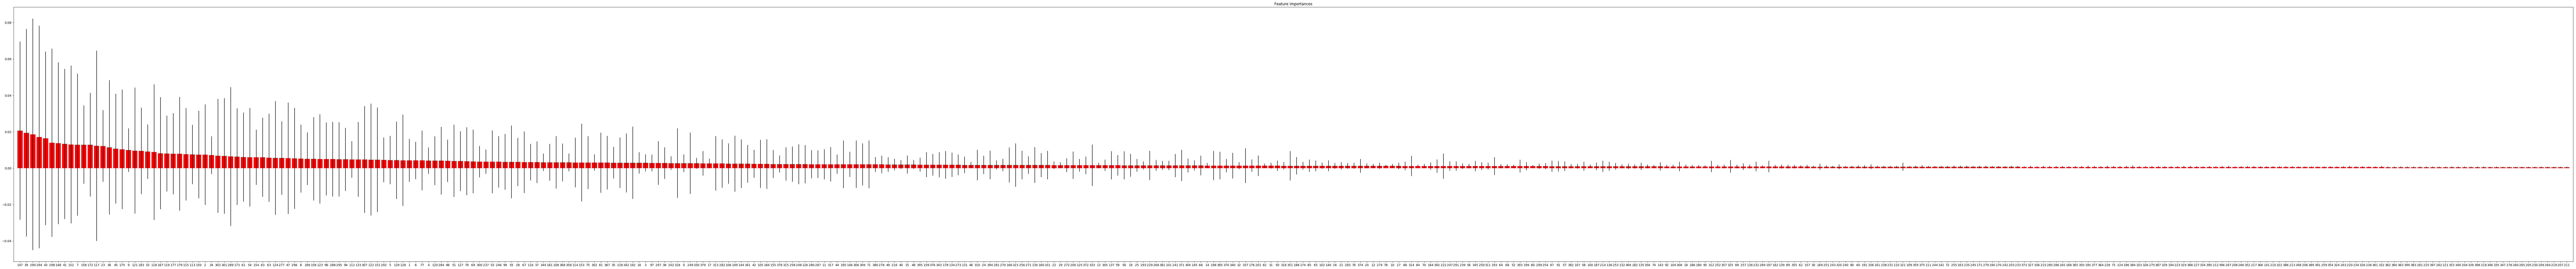

In [88]:
visualize_feature_importance(
    learning_data__k400best_var_th_scaled_X_train,
    learning_data__k400best_var_th_scaled_columns,
    extra_trees_cls_on_train_kbest400_few_est,
    (150,15)
)

In [89]:
# TODO
# selected flight events
# recursive feature elimination
# visualize trees
# tSNE

## Recursive Feature Elimination

In [90]:
overwrite_existing_rfe_model_files = True
refit_existing_rfe_model_files = False

In [91]:
rfe_extra_trees_params = dict(n_estimators=128, random_state=0, verbose=1, class_weight=None, n_jobs=-1)

### Fitting

In [92]:
X_train = learning_data__k400best_var_th_scaled_X_train
y_train = learning_data__y_train

X_test = learning_data__k400best_var_th_scaled_X_test
y_test = learning_data__y_test

rfe_selector_on_extra_trees_cls_dict = {}

for n_features_to_select in [10,20,30,40,50,100]:
    print('RFE: n_features_to_select={:d}'.format(n_features_to_select))
    print('-' * 30)
    rfe_selector_on_extra_trees_cls__model_plk_pathname = os.path.join(data_snippets_dir, 'rfe_selector_{:d}feat_on_extra_trees_cls.pkl'.format(n_features_to_select))
    if not os.path.exists(rfe_selector_on_extra_trees_cls__model_plk_pathname) or refit_existing_rfe_model_files:
        print('Fitting...')
        extra_trees_cls_on_train_kbest400_128_est = sklearn.ensemble.ExtraTreesClassifier(**rfe_extra_trees_params)
        rfe_selector_on_extra_trees_cls = sklearn.feature_selection.RFE(extra_trees_cls_on_train_kbest400_128_est, 
                                                                        n_features_to_select=n_features_to_select, step=1, verbose=1)
        rfe_selector_on_extra_trees_cls.fit(X_train, y_train)
        
        if overwrite_existing_rfe_model_files or not os.path.exists(rfe_selector_on_extra_trees_cls__model_plk_pathname):
            print('Saving...')
            print(rfe_selector_on_extra_trees_cls__model_plk_pathname)
            joblib.dump(rfe_selector_on_extra_trees_cls, 
                        rfe_selector_on_extra_trees_cls__model_plk_pathname, 
                        compress=1)
    else:
        print('Loading...')
        rfe_selector_on_extra_trees_cls = sklearn.externals.joblib.load(rfe_selector_on_extra_trees_cls__model_plk_pathname)
    
    rfe_selector_on_extra_trees_cls_dict[n_features_to_select] = rfe_selector_on_extra_trees_cls
    
    print('=' * 30)

RFE: n_features_to_select=10
------------------------------
Loading...
RFE: n_features_to_select=20
------------------------------
Loading...
RFE: n_features_to_select=30
------------------------------
Loading...
RFE: n_features_to_select=40
------------------------------
Loading...
RFE: n_features_to_select=50
------------------------------
Loading...
RFE: n_features_to_select=100
------------------------------
Loading...


TODO: This should be also done with a different training set

### Performance on test set

In [93]:
for n_features_to_select, rfe_selector_on_extra_trees_cls in rfe_selector_on_extra_trees_cls_dict.items():
    print('RFE: n_features_to_select={:d}'.format(n_features_to_select))
    print('-' * 30)
    
    print('Selected_features:')
    for n, m, sc in \
        sorted(
            zip(
                learning_data__k400best_var_th_scaled_columns, 
                rfe_selector_on_extra_trees_cls.get_support(), 
                rfe_selector_on_extra_trees_cls.ranking_
            ), 
            key=lambda x: x[2]) :
        if m:
            print("{:<100} {:<}".format(n,sc))
    
    print('-' * 30)
    
    y_test = learning_data__y_test
    y_test_pred = rfe_selector_on_extra_trees_cls.predict(learning_data__k400best_var_th_scaled_X_test)

    print('Confusion matrix:')
    print(sklearn.metrics.confusion_matrix(
        y_test, 
        y_test_pred))

    print('Accuracy report:')
    print_accuracy_cls_report(
        y_test, 
        y_test_pred)

    print('lbl_noise_flight:')
    
    labeled_data_cls_stats = \
        print_labeled_data_cls_stats(
            mask_arr_test=learning_data__lbl_noise_flight_mask_arr_test,
            y_test=y_test,
            y_test_pred=y_test_pred)
    
    
    print('=' * 30)

RFE: n_features_to_select=10
------------------------------
Selected_features:
orig_x_y_count_nonzero                                                                               1
bg_count_nonzero                                                                                     1
trg_x_y_hough_peak_thr1_line_clusters_clu_widths_max                                                 1
trg_x_y_hough_peak_thr1_line_clusters_max_area_clu_width                                             1
trg_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width                                              1
proc1_x_y_hough_peak_thr1_line_clusters_clu_widths_max                                               1
proc2_x_y_hough_peak_thr1_line_clusters_count                                                        1
proc2_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width                                            1
proc3_x_y_hough_peak_thr1_line_clusters_count                                                    

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


Confusion matrix:
[[12038   268]
 [ 1037 11264]]
Accuracy report:
Accuracy 0.9469663103994799
             precision    recall  f1-score   support

      noise       0.92      0.98      0.95     12306
      track       0.98      0.92      0.95     12301

avg / total       0.95      0.95      0.95     24607

lbl_noise_flight:
Accuracy (specificity) 0.9568690095846646
num_negative       626
num_true_negative  599
num_false_positive 27
specificity        0.956869
fallout            0.043131
RFE: n_features_to_select=30
------------------------------
Selected_features:
trg_x_y_clusters_max_size_clu_height                                                                 1
trg_x_y_clusters_max_peak_clu_height                                                                 1
orig_x_y_count_nonzero                                                                               1
bg_count_nonzero                                                                                     1
bg_size         

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


Confusion matrix:
[[12062   244]
 [  876 11425]]
Accuracy report:
Accuracy 0.9544844962815459
             precision    recall  f1-score   support

      noise       0.93      0.98      0.96     12306
      track       0.98      0.93      0.95     12301

avg / total       0.96      0.95      0.95     24607

lbl_noise_flight:
Accuracy (specificity) 0.9552715654952076
num_negative       626
num_true_negative  598
num_false_positive 28
specificity        0.955272
fallout            0.044728
RFE: n_features_to_select=50
------------------------------
Selected_features:
trg_x_y_clusters_max_size_clu_width                                                                  1
trg_x_y_clusters_max_size_clu_height                                                                 1
trg_x_y_clusters_max_peak_clu_width                                                                  1
trg_x_y_clusters_max_peak_clu_height                                                                 1
trg_gtu_x_cluste

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


Confusion matrix:
[[12170   136]
 [  794 11507]]
Accuracy report:
Accuracy 0.9622058763766408
             precision    recall  f1-score   support

      noise       0.94      0.99      0.96     12306
      track       0.99      0.94      0.96     12301

avg / total       0.96      0.96      0.96     24607

lbl_noise_flight:
Accuracy (specificity) 0.9408945686900958
num_negative       626
num_true_negative  589
num_false_positive 37
specificity        0.940895
fallout            0.059105


### Cross-validation

In [94]:
for n_features_to_select, rfe_selector_on_extra_trees_cls in rfe_selector_on_extra_trees_cls_dict.items():
    print('RFE: n_features_to_select={:d}'.format(n_features_to_select))
    print('-' * 30)
        
    extra_trees_cls_on_train_rfe_for_crossvalidation = sklearn.ensemble.ExtraTreesClassifier(**rfe_extra_trees_params)

    # not entirely correct, feature selection should be also included in crossvalidation training

    learning_data__rfe_kbest400_var_th_scaled_X = \
        rfe_selector_on_extra_trees_cls.transform(
            k400best_f_classif_selector_on_var_th_sc_train.transform(
                var_th_selector_on_scaled_train.transform(
                    standard_scaler_on_train.transform(learning_data__X)
                )
            )
        )

    extra_trees_cls_on_train_rfe_for_crossvalidation_crv_results = \
        sklearn.model_selection.cross_val_score(
            extra_trees_cls_on_train_rfe_for_crossvalidation, 
            learning_data__rfe_kbest400_var_th_scaled_X, learning_data__y, 
            n_jobs=-1, cv=5)
    
    print('Cross-validation accuracy:', extra_trees_cls_on_train_rfe_for_crossvalidation_crv_results)
    print('Mean accuracy:            ', np.mean(extra_trees_cls_on_train_rfe_for_crossvalidation_crv_results))
    print('Std accuracy:             ', np.std(extra_trees_cls_on_train_rfe_for_crossvalidation_crv_results))
    
    extra_trees_cls_on_train_rfe_for_crossvalidation_lbl_noise_flight_crv_results = \
    cross_val_score_meta_scored(
        extra_trees_cls_on_train_rfe_for_crossvalidation,
        learning_data__rfe_kbest400_var_th_scaled_X, learning_data__y, 
        score_masked_using_indices_lbl_noise_flight_mask_arr_all,
        cv=5, 
        random_state=32, verbose=1
    )
    
    print('Cross-validation accuracy (lbl_noise):', extra_trees_cls_on_train_rfe_for_crossvalidation_lbl_noise_flight_crv_results)
    print('Mean accuracy (lbl_noise):            ', np.mean(extra_trees_cls_on_train_rfe_for_crossvalidation_lbl_noise_flight_crv_results))
    print('Std accuracy (lbl_noise):             ', np.std(extra_trees_cls_on_train_rfe_for_crossvalidation_lbl_noise_flight_crv_results))
    
    print('=' * 30)

RFE: n_features_to_select=10
------------------------------


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.7s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.8s finished
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parall

Cross-validation accuracy: [0.92425228 0.94554616 0.94847204 0.96480247 0.94480572]
Mean accuracy:             0.9455757349867943
Std accuracy:              0.012909993690438853
0/5
len(X_train): 49212


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.3s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


len(X_test): 12304
1/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


len(X_test): 12303
2/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.3s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


len(X_test): 12303
3/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.3s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
4/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.3s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


len(X_test): 12303


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


Cross-validation accuracy (lbl_noise): [0.9614035087719298, 0.9655172413793104, 0.9214501510574018, 0.9556313993174061, 0.9566666666666667]
Mean accuracy (lbl_noise):             0.952133793438543
Std accuracy (lbl_noise):              0.01574363615881109
RFE: n_features_to_select=20
------------------------------


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.2s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.4s finished
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.5s finished
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parall

Cross-validation accuracy: [0.93481795 0.94221391 0.94465215 0.96049423 0.94147293]
Mean accuracy:             0.9447302330025946
Std accuracy:              0.00852883315985489
0/5
len(X_train): 49212


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


len(X_test): 12304


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


1/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


len(X_test): 12303


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


2/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


len(X_test): 12303


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


3/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
4/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


len(X_test): 12303


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


Cross-validation accuracy (lbl_noise): [0.9438596491228071, 0.9811912225705329, 0.9395770392749244, 0.9488054607508533, 0.9466666666666667]
Mean accuracy (lbl_noise):             0.9520200076771568
Std accuracy (lbl_noise):              0.014908858203538156
RFE: n_features_to_select=30
------------------------------


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    3.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    3.5s finished
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    3.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parall

Cross-validation accuracy: [0.94205137 0.94635891 0.95164174 0.96496505 0.94399285]
Mean accuracy:             0.9498019817260411
Std accuracy:              0.008233785401192094
0/5
len(X_train): 49212


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12304
1/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
2/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
3/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
4/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
Cross-validation accuracy (lbl_noise): [0.9473684210526315, 0.9749216300940439, 0.945619335347432, 0.962457337883959, 0.9466666666666667]
Mean accuracy (lbl_noise):             0.9554066782089465
Std accuracy (lbl_noise):              0.011552823110301527
RFE: n_features_to_select=40
------------------------------


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    4.2s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    4.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    4.4s finished
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parall

Cross-validation accuracy: [0.94481469 0.95245449 0.95570546 0.96943586 0.94984555]
Mean accuracy:             0.9544512120096768
Std accuracy:              0.008296679028962677
0/5
len(X_train): 49212


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.6s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12304
1/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.6s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
2/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.6s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


len(X_test): 12303


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


3/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.6s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
4/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.6s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
Cross-validation accuracy (lbl_noise): [0.9473684210526315, 0.9717868338557993, 0.9335347432024169, 0.9453924914675768, 0.96]
Mean accuracy (lbl_noise):             0.9516164979156848
Std accuracy (lbl_noise):              0.01312143152210213
RFE: n_features_to_select=50
------------------------------


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    5.1s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    5.6s finished
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    5.6s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    5.7s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parall

Cross-validation accuracy: [0.94855332 0.95538036 0.95668075 0.97033003 0.95317834]
Mean accuracy:             0.9568245613905273
Std accuracy:              0.007296744470228946
0/5
len(X_train): 49212


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.7s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12304
1/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.7s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
2/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.7s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


len(X_test): 12303


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


3/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.7s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


len(X_test): 12303
4/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.7s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


len(X_test): 12303
Cross-validation accuracy (lbl_noise): [0.9578947368421052, 0.9623824451410659, 0.9365558912386707, 0.9453924914675768, 0.9533333333333334]
Mean accuracy (lbl_noise):             0.9511117796045504
Std accuracy (lbl_noise):              0.009192995751179751
RFE: n_features_to_select=100
------------------------------


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    8.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    9.2s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    8.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parall

Cross-validation accuracy: [0.950829   0.96618986 0.95952536 0.97317509 0.95577955]
Mean accuracy:             0.9610997709571366
Std accuracy:              0.00784849923967259
0/5
len(X_train): 49212


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12304
1/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
2/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


len(X_test): 12303


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


3/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


len(X_test): 12303
4/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s


len(X_test): 12303
Cross-validation accuracy (lbl_noise): [0.9333333333333333, 0.9498432601880877, 0.9305135951661632, 0.9249146757679181, 0.9433333333333334]
Mean accuracy (lbl_noise):             0.9363876395577672
Std accuracy (lbl_noise):              0.008997315941116942


[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


## Recursive Feature Elimination with cross-validation (RFECV)

In [95]:
load_rfecv_from_file = True
overwrite_existing_rfecv_model_files = True
recreate_rfecv_pipline_object = True

In [96]:
extra_trees_cls_on_train_kbest400_128_est__model_plk_pathname = \
    os.path.join(data_snippets_dir, 'extra_trees_cls_on_train_kbest400_128_est.pkl')
pipeline_from_trained_models__extr_rfecv_kb400_vth_scale__model_plk_pathname = \
    os.path.join(data_snippets_dir, 'pipeline_from_trained_models__extr_rfecv_kb400_vth_scale.pkl')

In [97]:
# standard_scaler_on_train, var_th_selector_on_scaled_train, 
# k400best_f_classif_selector_on_var_th_sc_train, rfecv_selector_on_extra_trees_cls,
# extra_trees_cls_on_train_kbest400_128_est

In [98]:
load_rfecv_from_file and os.path.exists(pipeline_from_trained_models__extr_rfecv_kb400_vth_scale__model_plk_pathname)

True

### Training or loading the model

In [99]:
pipeline_from_trained_models__extr_rfecv_kb400_vth_scale  = None

if load_rfecv_from_file and os.path.exists(pipeline_from_trained_models__extr_rfecv_kb400_vth_scale__model_plk_pathname):
    pipeline_from_trained_models__extr_rfecv_kb400_vth_scale = \
        joblib.load(pipeline_from_trained_models__extr_rfecv_kb400_vth_scale__model_plk_pathname)
    
    rfecv_selector_on_extra_trees_cls = pipeline_from_trained_models__extr_rfecv_kb400_vth_scale.steps[-1][1]
    extra_trees_cls_on_train_kbest400_128_est = rfecv_selector_on_extra_trees_cls.estimator_
    
else:
    X_train = learning_data__k400best_var_th_scaled_X_train
    y_train = learning_data__y_train

    X_test = learning_data__k400best_var_th_scaled_X_test
    y_test = learning_data__y_test

    column_names = learning_data__k400best_var_th_scaled_columns

    extra_trees_cls_on_train_kbest400_128_est = sklearn.ensemble.ExtraTreesClassifier(**rfe_extra_trees_params)

    rfecv_selector_on_extra_trees_cls = sklearn.feature_selection.RFECV(
        estimator=extra_trees_cls_on_train_kbest400_128_est, 
        step=1, 
        verbose=1, n_jobs=-1)

    rfecv_selector_on_extra_trees_cls.fit(X_train, y_train)

In [100]:
rfecv_selector_on_extra_trees__column_names = \
    [n for n, m in zip(learning_data__k400best_var_th_scaled_columns, rfecv_selector_on_extra_trees_cls.get_support()) if m]

In [101]:
print(len(rfecv_selector_on_extra_trees__column_names))

102


### Saving models

In [102]:
# Saving  extra_trees_cls_on_train_kbest400_128_est
if overwrite_existing_rfecv_model_files or not os.path.exists(extra_trees_cls_on_train_kbest400_128_est__model_plk_pathname):
    print(extra_trees_cls_on_train_kbest400_128_est__model_plk_pathname)
    joblib.dump(extra_trees_cls_on_train_kbest400_128_est, 
                extra_trees_cls_on_train_kbest400_128_est__model_plk_pathname, 
                compress=1)

ver4_machine_learning_w_labeled_flight_20181129/extra_trees_cls_on_train_kbest400_128_est.pkl


#### Whole pipeline

In [103]:
if pipeline_from_trained_models__extr_rfecv_kb400_vth_scale is None or recreate_rfecv_pipline_object:
    pipeline_from_trained_models__extr_rfecv_kb400_vth_scale = \
        sklearn.pipeline.make_pipeline(
            standard_scaler_on_train, var_th_selector_on_scaled_train, 
            k400best_f_classif_selector_on_var_th_sc_train, rfecv_selector_on_extra_trees_cls
        )
    print(pipeline_from_trained_models__extr_rfecv_kb400_vth_scale)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('variancethreshold', VarianceThreshold(threshold=0.0)), ('selectkbest', SelectKBest(k=400, score_func=<function f_classif at 0x7fa440641048>)), ('rfecv', RFECV(cv=None,
   estimator=ExtraTreesClassifier(bootstrap=F...alse, random_state=0, verbose=1, warm_start=False),
   n_jobs=-1, scoring=None, step=1, verbose=1))])


In [104]:
if pipeline_from_trained_models__extr_rfecv_kb400_vth_scale is not None and \
        (overwrite_existing_rfecv_model_files or \
         not os.path.exists(pipeline_from_trained_models__extr_rfecv_kb400_vth_scale__model_plk_pathname)):
    print(pipeline_from_trained_models__extr_rfecv_kb400_vth_scale__model_plk_pathname)
    joblib.dump(pipeline_from_trained_models__extr_rfecv_kb400_vth_scale, 
                pipeline_from_trained_models__extr_rfecv_kb400_vth_scale__model_plk_pathname,
                compress=1)

ver4_machine_learning_w_labeled_flight_20181129/pipeline_from_trained_models__extr_rfecv_kb400_vth_scale.pkl


#### Creating a list of selected columns and a scaler for the columns

In [105]:
columns_list_file_pathname = os.path.join(data_snippets_dir, 'rfecv_selector_on_extra_trees__column_names.txt')
print(columns_list_file_pathname)
with open(columns_list_file_pathname, 'w') as columns_list_file:
    for col_name in rfecv_selector_on_extra_trees__column_names:
        print(col_name, file=columns_list_file)

ver4_machine_learning_w_labeled_flight_20181129/rfecv_selector_on_extra_trees__column_names.txt


In [106]:
special_columns_list_file_pathname = os.path.join(data_snippets_dir, 'rfecv_selector_on_extra_trees__column_names__special.txt')
print(special_columns_list_file_pathname)
with open(special_columns_list_file_pathname, 'w') as special_columns_list_file:
    for col_name in rfecv_selector_on_extra_trees__column_names:
        if col_name not in common_df_columns:
            print(col_name, file=special_columns_list_file)

ver4_machine_learning_w_labeled_flight_20181129/rfecv_selector_on_extra_trees__column_names__special.txt


In [107]:
np.count_nonzero(~np.isin(rfecv_selector_on_extra_trees__column_names, common_df_columns))

0

#### StandardScaler on columns selected by RFECV

In [108]:
column_indices_rfecv_in_analyzed_common = [analyzed_common_df_columns.index(attr) for attr in rfecv_selector_on_extra_trees__column_names]

In [109]:
standard_scaler_on_train_rfecv_columns = sklearn.preprocessing.StandardScaler()
standard_scaler_on_train_rfecv_columns.fit(learning_data__X_train.T[column_indices_rfecv_in_analyzed_common].T)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [110]:
np.sum(np.round(
    standard_scaler_on_train_rfecv_columns.transform(
        learning_data__X_train.T[column_indices_rfecv_in_analyzed_common].T)*10000))

-16467.0

In [111]:
np.sum(np.round(
    rfecv_selector_on_extra_trees_cls.transform(
        k400best_f_classif_selector_on_var_th_sc_train.transform(
            var_th_selector_on_scaled_train.transform(
                standard_scaler_on_train.transform(learning_data__X_train)
            )
        )
    )*10000))

-16467.0

In [112]:
len(standard_scaler_on_train_rfecv_columns.scale_)

102

### Selected columns

In [113]:
for n, m, sc in \
        sorted(
            zip(
                learning_data__k400best_var_th_scaled_columns, 
                rfecv_selector_on_extra_trees_cls.get_support(), 
                rfecv_selector_on_extra_trees_cls.ranking_
            ), 
            key=lambda x: x[2]) :
    if m:
        print("{:<100} {:<}".format(n,sc))

trg_x_y_clusters_clu_areas_max                                                                       1
trg_x_y_clusters_max_size_clu_width                                                                  1
trg_x_y_clusters_max_size_clu_height                                                                 1
trg_x_y_clusters_max_peak_clu_width                                                                  1
trg_x_y_clusters_max_peak_clu_height                                                                 1
trg_gtu_x_clusters_max_size_clu_height                                                               1
trg_gtu_x_clusters_max_peak_clu_height                                                               1
trg_gtu_y_clusters_max_size_clu_height                                                               1
trg_gtu_y_clusters_max_peak_clu_height                                                               1
orig_x_y_count_nonzero                                                   

### Performance of the ExtraTreesClassifier model or RFECV features

In [114]:
y_test = learning_data__y_test
y_test_pred = rfecv_selector_on_extra_trees_cls.predict(learning_data__k400best_var_th_scaled_X_test)

print(sklearn.metrics.confusion_matrix(
    y_test, 
    y_test_pred))

print_accuracy_cls_report(
    y_test, 
    y_test_pred)

labeled_data_cls_stats = \
    print_labeled_data_cls_stats(
        mask_arr_test=learning_data__lbl_noise_flight_mask_arr_test,
        y_test=y_test,
        y_test_pred=y_test_pred)

[[12155   151]
 [  816 11485]]
Accuracy 0.9607022392002276
             precision    recall  f1-score   support

      noise       0.94      0.99      0.96     12306
      track       0.99      0.93      0.96     12301

avg / total       0.96      0.96      0.96     24607

Accuracy (specificity) 0.9345047923322684
num_negative       626
num_true_negative  585
num_false_positive 41
specificity        0.934505
fallout            0.065495


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


### Cross-validation

In [115]:
extra_trees_cls_on_train_rfecv_for_crossvalidation = sklearn.ensemble.ExtraTreesClassifier(**rfe_extra_trees_params)

# not entirely correct, feature selection should be also included in crossvalidation training

learning_data__rfecv_kbest400_var_th_scaled_X = \
    rfecv_selector_on_extra_trees_cls.transform(
        k400best_f_classif_selector_on_var_th_sc_train.transform(
            var_th_selector_on_scaled_train.transform(
                standard_scaler_on_train.transform(learning_data__X)
            )
        )
    )

print(learning_data__rfecv_kbest400_var_th_scaled_X.shape)

extra_trees_cls_on_train_rfecv_for_crossvalidation_crv_results = \
    sklearn.model_selection.cross_val_score(
        extra_trees_cls_on_train_rfecv_for_crossvalidation, 
        learning_data__rfecv_kbest400_var_th_scaled_X, learning_data__y, 
        n_jobs=-1, cv=5)

(61516, 102)


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    8.2s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    9.2s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    9.5s finished
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    9.2s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    8.4s finished
[Parall

In [116]:
print('Cross-validation accuracy:', extra_trees_cls_on_train_rfecv_for_crossvalidation_crv_results)
print('Mean accuracy:            ', np.mean(extra_trees_cls_on_train_rfecv_for_crossvalidation_crv_results))
print('Std accuracy:             ', np.std(extra_trees_cls_on_train_rfecv_for_crossvalidation_crv_results))

Cross-validation accuracy: [0.94993498 0.96635241 0.95952536 0.97293123 0.95618599]
Mean accuracy:             0.9609859921071753
Std accuracy:              0.007984804183544114


#### Cross-validation of labeled noise data

##### random_state = 32

In [117]:
extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results = \
    cross_val_score_meta_scored(
        extra_trees_cls_on_train_rfecv_for_crossvalidation,
        learning_data__rfecv_kbest400_var_th_scaled_X, learning_data__y, 
        score_masked_using_indices_lbl_noise_flight_mask_arr_all,
        cv=5, 
        random_state=32, verbose=1
    )

0/5
len(X_train): 49212


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


len(X_test): 12304
1/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
2/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


len(X_test): 12303


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


3/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
4/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s


len(X_test): 12303


[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


In [118]:
print('Cross-validation accuracy (lbl_noise):', extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results)
print('Mean accuracy (lbl_noise):            ', np.mean(extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results))
print('Std accuracy (lbl_noise):             ', np.std(extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results))

Cross-validation accuracy (lbl_noise): [0.9333333333333333, 0.9435736677115988, 0.918429003021148, 0.9385665529010239, 0.94]
Mean accuracy (lbl_noise):             0.9347805113934207
Std accuracy (lbl_noise):              0.00881320509274033


##### random_state = 123

In [119]:
extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results_2 = \
    cross_val_score_meta_scored(
        extra_trees_cls_on_train_rfecv_for_crossvalidation,
        learning_data__rfecv_kbest400_var_th_scaled_X, learning_data__y, 
        score_masked_using_indices_lbl_noise_flight_mask_arr_all,
        cv=5, 
        random_state=123, verbose=1
    )

0/5
len(X_train): 49212


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


len(X_test): 12304
1/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


len(X_test): 12303


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


2/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
3/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


len(X_test): 12303
4/5
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s


len(X_test): 12303


[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


In [120]:
print('Cross-validation accuracy (lbl_noise, seed=123):', extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results_2)
print('Mean accuracy (lbl_noise, seed=123):            ', np.mean(extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results_2))
print('Std accuracy (lbl_noise, seed=123):             ', np.std(extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results_2))

Cross-validation accuracy (lbl_noise, seed=123): [0.9174917491749175, 0.934984520123839, 0.9287925696594427, 0.8974358974358975, 0.9575163398692811]
Mean accuracy (lbl_noise, seed=123):             0.9272442152526755
Std accuracy (lbl_noise, seed=123):              0.019810894252075942


##### Repeated K-Fold, random_state=123

In [121]:
extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results_3 = \
    cross_val_score_meta_scored(
        extra_trees_cls_on_train_rfecv_for_crossvalidation,
        learning_data__rfecv_kbest400_var_th_scaled_X, learning_data__y, 
        score_masked_using_indices_lbl_noise_flight_mask_arr_all,
        cv=sklearn.model_selection.RepeatedKFold(n_splits=5, n_repeats=5, random_state=123), verbose=1
    )

0
len(X_train): 49212


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12304
1
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
2
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
3
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
4
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
5
len(X_train): 49212


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


len(X_test): 12304


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


6
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
7
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
8
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
9
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


len(X_test): 12303
10
len(X_train): 49212


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12304
11
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
12
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


len(X_test): 12303
13
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


len(X_test): 12303
14
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
15
len(X_train): 49212


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12304
16
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


len(X_test): 12303
17
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
18
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
19
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
20
len(X_train): 49212


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


len(X_test): 12304


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


21
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
22
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
23
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
24
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s


len(X_test): 12303


[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


In [122]:
print('Cross-validation accuracy (lbl_noise):', extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results_3)
print('Mean accuracy (lbl_noise):            ', np.mean(extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results_3))
print('Std accuracy (lbl_noise):             ', np.std(extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results_3))

Cross-validation accuracy (lbl_noise): [0.9174917491749175, 0.934984520123839, 0.9287925696594427, 0.8974358974358975, 0.9575163398692811, 0.9267515923566879, 0.9097222222222222, 0.9205298013245033, 0.945859872611465, 0.9225806451612903, 0.9310344827586207, 0.9273356401384083, 0.930921052631579, 0.9290322580645162, 0.9313725490196079, 0.9413793103448276, 0.9465875370919882, 0.9075907590759076, 0.9276315789473685, 0.9251700680272109, 0.9411764705882353, 0.9335664335664335, 0.9390243902439024, 0.9280575539568345, 0.9333333333333333]
Mean accuracy (lbl_noise):             0.9293951451091328
Std accuracy (lbl_noise):              0.012634448087023421


### Recognition efficiency

In [162]:
import pprint

def get_x_y_vals(table):
    x_vals = []
    y_vals = []
    for x_val, y_val in table:
        if y_val is not None and (not isinstance(y_val, (list,tuple, np.ndarray, pd.Series)) or len(y_val) > 0):
            x_vals.append(x_val)
            y_vals.append(y_val)
    return x_vals, y_vals

def get_attribute_table_from_scores(d, attribute):
    table = []
    for x_val, y_dict in d.items():
        table.append((x_val, y_dict[attribute]))
    return table

def get_thinned_datapoints_linear(x_vals, y_vals, num_steps, min_x=None, max_x=None):
    
    if min_x is None:
        min_x = x_vals[0]
    if max_x is None:
        max_x = x_vals[-1]
    
    x_val_step = (max_x - min_x)/num_steps

    r_i = 0
    cur_x_val_step = min_x
    cur_x_val = cur_x_val_step

    bins_x_vals = []
    bins_y_vals = []
    x_ranges_low = []
    x_ranges_high = []
    bin_ranges_low = []
    bin_ranges_high = []
    
    while cur_x_val_step <= max_x:
        bin_x_vals = []
        bin_y_vals = []

        while cur_x_val_step <= cur_x_val < cur_x_val_step+x_val_step:
            
#             print(cur_x_val_step, cur_x_val, x_val_step, cur_x_val_step+x_val_step)
            
            bin_x_vals.append(cur_x_val)
            bin_y_vals.append(y_vals[r_i])

            if r_i+1 >= len(x_vals):
                break
            r_i += 1
            cur_x_val = x_vals[r_i]

        if bin_y_vals:
            x_ranges_low.append(bin_x_vals[0])
            x_ranges_high.append(bin_x_vals[-1])

            bins_x_vals.append(bin_x_vals)
            bins_y_vals.append(bin_y_vals)
        
#         print('>',cur_x_val_step)

        bin_ranges_low.append(cur_x_val_step)
        
        cur_x_val_step += x_val_step
        
        bin_ranges_high.append(cur_x_val_step)

#         print('>',cur_x_val_step)
    
    return bins_x_vals, bins_y_vals, x_ranges_low, x_ranges_high, bin_ranges_low, bin_ranges_high


def get_thinned_datapoints_log(x_vals, y_vals, num_steps, log_base=10, min_x=None, max_x=None):
        
    if min_x is None:
        min_x = x_vals[0]
    if max_x is None:
        max_x = x_vals[-1]
    
    x_val_step = (max_x - min_x)/num_steps # TODO dynamically
    
    max_exponent = math.log(max_x, log_base)
    min_exponent = math.log(min_x, log_base)
    exponent_step = (max_exponent - min_exponent) / num_steps
    
#     print('->',min_x, max_x, max_exponent, exponent_step)
    
    r_i = 0
    
    cur_x_val_step = min_x
    cur_x_val = cur_x_val_step
    
#     cur_exponent_step = math.log(min_x, log_base)
#     cur_exponent = cur_exponent_step

    bins_x_vals = []
    bins_y_vals = []
    binned_x_ranges_low = []
    binned_x_ranges_high = []
    bin_ranges_low = []
    bin_ranges_high = []
    
    while cur_x_val_step <= max_x:
        bin_x_vals = []
        bin_y_vals = []

        next_exponent_step = math.log(cur_x_val_step, log_base) + exponent_step
        
        #while cur_x_val_step <= cur_x_val < cur_x_val_step+x_val_step:
        while cur_x_val_step <= cur_x_val \
                and math.log(cur_x_val, log_base) < next_exponent_step:
            
#             print(
#                 cur_x_val_step , cur_x_val , 
#                 math.log(cur_x_val, log_base) , 
#                 next_exponent_step,
#             )
            
            bin_x_vals.append(cur_x_val)
            bin_y_vals.append(y_vals[r_i])

            if r_i+1 >= len(x_vals):
                break
            r_i += 1
            cur_x_val = x_vals[r_i]

#             time.sleep(1)
            
        if bin_y_vals:
            binned_x_ranges_low.append(bin_x_vals[0])
            binned_x_ranges_high.append(bin_x_vals[-1])

            bins_x_vals.append(bin_x_vals)
            bins_y_vals.append(bin_y_vals)

#         print('>', cur_x_val_step)

        bin_ranges_low.append(cur_x_val_step)
            
        cur_x_val_step = log_base ** next_exponent_step
        
        bin_ranges_high.append(cur_x_val_step)
        
#         print('>', cur_x_val_step)
#         time.sleep(1)
        
    return bins_x_vals, bins_y_vals, binned_x_ranges_low, binned_x_ranges_high, bin_ranges_low, bin_ranges_high


def get_x_vals_weights(x_axis_weight_stat, xaxis_weight_reduce_func, bin_y_vals, none_weight=0):
    x_vals_weights = None
    y_vals = [d[xaxis_weight_stat] for d in bin_y_vals]
    x_vals_weights = []
    for y_vals_list in y_vals:
        x_vals_weights.append(
            xaxis_weight_reduce_func(y_vals_list) \
                if y_vals_list is not None else none_weight)
    return x_vals_weights
    
EFFICIENCTY_STAT_ERRORBAR_DEFAULTS = dict(
    marker='.', 
    linestyle='-', 
    color='black', 
    ecolor='silver'
)

def plot_efficiency_stat(
        stats_by_attr_dict, plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', 
        num_steps = 36, default_yerr=1, 
        xscale='linear', yscale='linear', xscale_binning=None, xtranslate_func=None,
        do_xaxis_weights=True, xaxis_weight_reduce_func=np.sum, xaxis_weight_stat='num_positive',
        concat_dicts=True, dict_stats_reduce_func=np.mean, dict_stats_yerr_reduce=('y',np.std),
        xlabel=None, ylabel=None, label='',
        ylim=None, xlim=None, 
        figsize=(15,8), errorbar_attrs=EFFICIENCTY_STAT_ERRORBAR_DEFAULTS,
        show=True, ax=None):
    '''
    dict_stats_yerr_mode: string|callable|tuple 
        'std_y'  or  'minmax_y'  or   callable (applied to yerr)   or tuple('y' or 'yerr', callable)
    '''
    
    if xscale_binning is None:
        xscale_binning = xscale
    
    if concat_dicts and isinstance(stats_by_attr_dict, (list, tuple)):
        stats_by_attr_dict = lod_to_dol(stats_by_attr_dict)
    
    if isinstance(stats_by_attr_dict, (list, tuple)):
        stats_by_attr_dict_list = stats_by_attr_dict
    else:
        stats_by_attr_dict_list = [stats_by_attr_dict]
    
    plot_entries_list = []
    
#     plot_x_list = []
#     plot_y_list = []
#     plot_xerr_list = []
#     plot_yerr_list = []
    
    plot_xbin_entries_dict = collections.OrderedDict()
    
    min_x = None
    max_x = None
        
    for stats_by_attr_dict in stats_by_attr_dict_list:
        t_min_x = np.min(list(stats_by_attr_dict.keys()))
        t_max_x = np.max(list(stats_by_attr_dict.keys()))
        if min_x is None or min_x > t_min_x:
            min_x = t_min_x
        if max_x is None or max_x < t_max_x:
            max_x = t_max_x
    
#     print('min_x=',min_x)
#     print('max_x=',max_x)
#     print('len(stats_by_attr_dict_list)=',len(stats_by_attr_dict_list))
    
    for stats_by_attr_dict in stats_by_attr_dict_list:

        x_vals, y_vals = get_x_y_vals(stats_by_attr_dict.items())
        
        if xscale_binning == 'log':
            bins_x_vals, bins_y_vals, binned_x_ranges_low, binned_x_ranges_high, bin_ranges_low, bin_ranges_high = \
                get_thinned_datapoints_log(x_vals, y_vals, num_steps, min_x=min_x, max_x=max_x)
        else:
            if xscale_binning != 'linear':
                print('Using linear xscale binning!', file=sys.stderr)
            bins_x_vals, bins_y_vals, binned_x_ranges_low, binned_x_ranges_high, bin_ranges_low, bin_ranges_high = \
                get_thinned_datapoints_linear(x_vals, y_vals, num_steps, min_x=min_x, max_x=max_x)

        plot_x = []
        plot_y = []
        plot_xerr = [[],[]]
        plot_yerr = [[],[]]

    #     _tp = []
    #     _p = []
    
#         print('len(bins_x_vals)',len(bins_x_vals))
#         print('len(bins_y_vals)',len(bins_y_vals))

        for bin_x_vals, bin_y_vals, x_low, x_high, bin_low, bin_high in zip(bins_x_vals, bins_y_vals,
                                                                            binned_x_ranges_low, binned_x_ranges_high,
                                                                            bin_ranges_low, bin_ranges_high):

#             print('>len(bin_x_vals)',len(bin_x_vals))
#             print('>len(bin_y_vals)',len(bin_y_vals))

            n = sum_num_dict = lod_to_dol(bin_y_vals, apply_func=np.sum, do_secondary=False)

    #         print(sum_num_dict['num_true_positive'])
    #         print(sum_num_dict['num_positive'])
    #         _tp.append(sum_num_dict['num_true_positive'])
    #         _p.append(sum_num_dict['num_positive'])

            if plotted_stat not in sum_num_dict or (plotted_yerr_stat is not None and plotted_yerr_stat not in sum_num_dict):
                stats_dict = calc_cls_stats_from_numbers(sum_num_dict)

            if plotted_stat not in sum_num_dict:   
                stat_val = stats_dict[plotted_stat]
            else:
                stat_val = sum_num_dict[plotted_stat]
            
            if stat_val is not None:
                
                x_vals_weights = None
                if do_xaxis_weights:
                    assert(xaxis_weight_stat is not None and xaxis_weight_reduce_func is not None)
                    y_vals = [d[xaxis_weight_stat] for d in bin_y_vals]
                    x_vals_weights = []
                    for y_vals_list in y_vals:
                        x_vals_weights.append(
                            xaxis_weight_reduce_func(y_vals_list) \
                                if y_vals_list is not None else 0)
                
                yerr_val = default_yerr
                
                if plotted_yerr_stat is not None:
                    if plotted_yerr_stat not in sum_num_dict:   
                        yerr_val = stats_dict[plotted_yerr_stat]
                    else:
                        yerr_val = sum_num_dict[plotted_yerr_stat] 
            
                x_low_high_tuple = (bin_low, bin_high)   # Intentionally using bin range 
                
                if x_low_high_tuple not in plot_xbin_entries_dict:
                    plot_xbin_entries_dict[x_low_high_tuple] = []
                
                if len(stats_by_attr_dict_list) > 1:
                    plot_xbin_entries_dict[x_low_high_tuple].append(
                        (bin_x_vals, stat_val, x_vals_weights, yerr_val)
                    )
                    
                else:
                    if x_vals_weights is not None and np.sum(x_vals_weights) != 0:
                        plot_x_val = np.average(bin_x_vals, weights=x_vals_weights)
                    else:
                        plot_x_val = np.average(bin_x_vals)

                    xerr_low = plot_x_val - x_low
                    xerr_high = x_high - plot_x_val
                
                    plot_x.append(plot_x_val)
                    plot_xerr[0].append(xerr_low)
                    plot_xerr[1].append(xerr_high)
                    
                    plot_y.append(stat_val)
                    plot_yerr[0].append(yerr_val)
                    plot_yerr[1].append(yerr_val)
                    
            # endif  (stat_val is not None)
        # endfor
    
#     print('len(plot_xbin_entries_dict)=',len(plot_xbin_entries_dict))
#     pprint.pprint(list(plot_xbin_entries_dict.keys()))
    
    if len(stats_by_attr_dict_list) > 1 and len(plot_xbin_entries_dict) > 0:
        plot_x = []
        plot_y = []
        plot_xerr = [[],[]]
        plot_yerr = [[],[]]
        
        plot_xbin_entries_dict_items_sorted = sorted(plot_xbin_entries_dict.items())
        
        for (bin_low, bin_high), bin_entries in plot_xbin_entries_dict_items_sorted:
            
            # (bin_x_vals, stat_val, x_vals_weights, yerr_val)
            
            bin_x_vals_all = functools.reduce(lambda a,b: a + b, [entry[0] for entry in bin_entries])
            
            x_vals_weights_all = None
            if x_vals_weights is not None and np.sum(x_vals_weights) != 0:
                x_vals_weights_all = functools.reduce(lambda a,b: a + b, [entry[2] for entry in bin_entries])
#                 print('bin_x_vals_all')
#                 pprint.pprint(bin_x_vals_all)
#                 print('x_vals_weights_all')
#                 pprint.pprint(x_vals_weights_all)
                plot_x_val = np.average(bin_x_vals_all, weights=x_vals_weights_all)
#                 print('+'*50)
            else:
                plot_x_val = np.average(bin_x_vals_all)
            
            plot_y_list = [entry[1] for entry in bin_entries]
            plot_y_val = dict_stats_reduce_func(plot_y_list)
            
            plot_xerr_val_0 = plot_x_val - np.min(bin_x_vals_all)
            plot_xerr_val_1 = np.max(bin_x_vals_all) - plot_x_val
            
            plot_yerr_val_0 = plot_yerr_val_1 = default_yerr
            
            if dict_stats_yerr_reduce == 'std_y':
                plot_yerr_val_0 = np.std(plot_y_list)
                plot_yerr_val_1 = plot_yerr_val_0
            elif dict_stats_yerr_reduce == 'minmax_y':
                plot_yerr_val_0 = plot_y_val - np.min(plot_y_list)
                plot_yerr_val_1 = np.max(plot_y_list) - plot_y_val
            elif isinstance(dict_stats_yerr_reduce, tuple) and dict_stats_yerr_reduce[0] == 'y':
                r = dict_stats_yerr_reduce[1](plot_y_list)
                if isinstance(r, tuple):
                    plot_yerr_val_0, plot_yerr_val_1 = r
                else:
                    plot_yerr_val_0 = r
                    plot_yerr_val_1 = plot_yerr_val_0
                
            else:
                plot_yerr_list = [entry[3] for entry in bin_entries]
                
                if plotted_yerr_stat is not None:
                    if dict_stats_yerr_reduce == 'avg_yerr_weighted':
                        yerr_weights = [np.sum(entry[2]) for entry in bin_entries]
                        plot_yerr_val_0 = np.average(plot_yerr_list, weights=yerr_weights)
                        plot_yerr_val_1 = np.average(plot_yerr_list, weights=yerr_weights)
                    elif dict_stats_yerr_reduce == 'minmax_yerr':
                        plot_yerr_val_0 = np.min(plot_yerr_list)
                        plot_yerr_val_1 = np.max(plot_yerr_list)
                    else:
                        yerr_reduce_func = None
                        if callable(dict_stats_yerr_reduce):
                            yerr_reduce_func = dict_stats_yerr_reduce
                        elif isinstance(dict_stats_yerr_reduce, tuple) and dict_stats_yerr_reduce[0] == 'yerr':
                            yerr_reduce_func = dict_stats_yerr_reduce[1]
                        if yerr_reduce_func is not None:
                            r = yerr_reduce_func(plot_yerr_list)
                            if isinstance(r, tuple):
                                plot_yerr_val_0, plot_yerr_val_1 = r
                            else:
                                plot_yerr_val_0 = r
                                plot_yerr_val_1 = plot_yerr_val_0
                        else:
                            plot_yerr_val_0 = plot_yerr_val_1 = None
                else:
                    plot_yerr_val_0 = plot_yerr_val_1 = None
    
            plot_x.append(plot_x_val)
            plot_y.append(plot_y_val)
            plot_xerr[0].append(plot_xerr_val_0)
            plot_xerr[1].append(plot_xerr_val_1)
            plot_yerr[0].append(plot_yerr_val_0)
            plot_yerr[1].append(plot_yerr_val_1)
    
    
    if plotted_yerr_stat is not None:
        plot_yerr = [(v if v is not None else default_yerr) for v in plot_yerr]
    else:
        plot_yerr = None
    
    if callable(xtranslate_func):
        plot_x = xtranslate_func(plot_x)        
        plot_xerr[0] = xtranslate_func(plot_xerr[0])
        plot_xerr[1] = xtranslate_func(plot_xerr[1])
    
#         print(plot_y)
#         print(plot_xerr)
#         print(plot_yerr)

#     print(plot_x[:3])
#     print(plot_y[:3])
#     print(_tp[:3])
#     print(_p[:3])
#     print(plot_yerr[:3])
#     print('-'*50)
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    
#     print('plot_x')
#     print(plot_x)
#     print('plot_y')
#     print(plot_y)
#     print('plot_xerr')
#     print(plot_xerr)
#     print('plot_yerr')
#     print(plot_yerr)
    
    errbr = ax.errorbar(plot_x, plot_y, xerr=plot_xerr, yerr=plot_yerr, label=label, **errorbar_attrs)

    if xscale:
        ax.set_xscale(xscale)
    if yscale:
        ax.set_yscale(yscale)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:                        
        ax.set_ylabel(ylabel)
    if ylim:
        ax.set_ylim(ylim)
    if xlim:
        ax.set_xlim(xlim)
    if figsize is not None:
        fig.set_size_inches(figsize)
    if show:
        plt.show()
        
    return fig, ax, errbr


In [124]:
# _ta = np.random.randint(9, size=(10,5))
# _ta = np.array([[None]*5]*10)
# _ta = np.random.randint(9, size=(3,2,5))
_ta = np.array([[1]*5]*10)
print(_ta)
np.apply_along_axis(np.sum, 0, _ta)

[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


array([10, 10, 10, 10, 10])

In [125]:
_ta = ([1,2],[3,4],[5])
# _ta[1].append(3)
# _ta
functools.reduce(lambda a,b: a+b, _ta)

[1, 2, 3, 4, 5]

#### Test set sensitivity as function of the energy (no binning)

In [126]:
extra_trees_cls_on_train_rfecv__test__accuracy_by_energy = \
    score_by_column(
        rfecv_selector_on_extra_trees_cls, 
        learning_data__k400best_var_th_scaled_X_test[learning_data__simu_shower_track_mask_arr_test], 
        learning_data__y_test[learning_data__simu_shower_track_mask_arr_test], 
        sklearn.metrics.accuracy_score, 
        learning_data__event_id_test[learning_data__simu_shower_track_mask_arr_test], 
        combined_simu_df, 'etruth_trueenergy')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


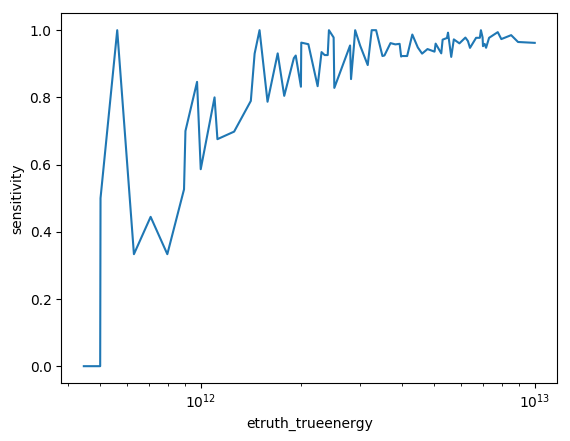

In [127]:
# extra_trees_cls_on_train_rfecv__test__accuracy_by_energy

plt.close('all')
fig, ax = plt.subplots()
ax.plot(extra_trees_cls_on_train_rfecv__test__accuracy_by_energy.keys(), 
        extra_trees_cls_on_train_rfecv__test__accuracy_by_energy.values())
ax.set_xlabel('etruth_trueenergy')
ax.set_ylabel('sensitivity')
ax.set_xscale('log')
plt.show()

#### Test set sensitivity as function of the energy

In [129]:
extra_trees_cls_on_train_rfecv__test__numbers_by_energy = \
    score_by_column(
        rfecv_selector_on_extra_trees_cls, 
        learning_data__k400best_var_th_scaled_X_test[learning_data__simu_shower_track_mask_arr_test], 
        learning_data__y_test[learning_data__simu_shower_track_mask_arr_test], 
        calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        learning_data__event_id_test[learning_data__simu_shower_track_mask_arr_test], 
        combined_simu_df, 'etruth_trueenergy')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


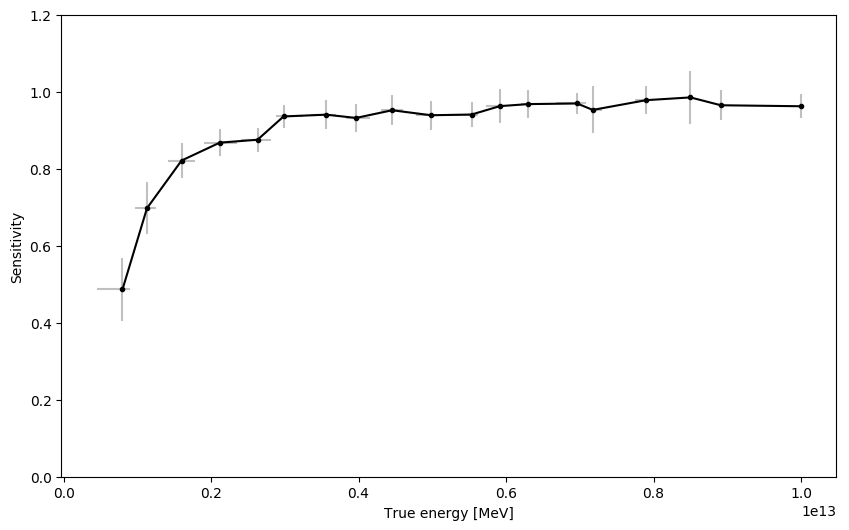

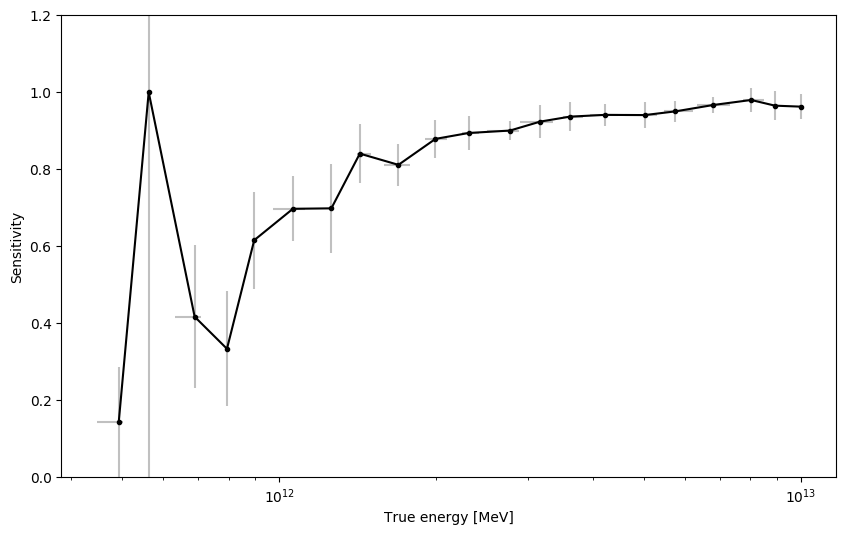

In [130]:
plt.close('all')
for xscale in ('linear', 'log'):
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__test__numbers_by_energy, 
                         plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', num_steps = 20, xscale=xscale,
                         xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
                         figsize = (10,6), ylim=(0,1.2))

#### Number of true positivie and positive samples as function of the energy

##### Number of positive samples as function of the energy

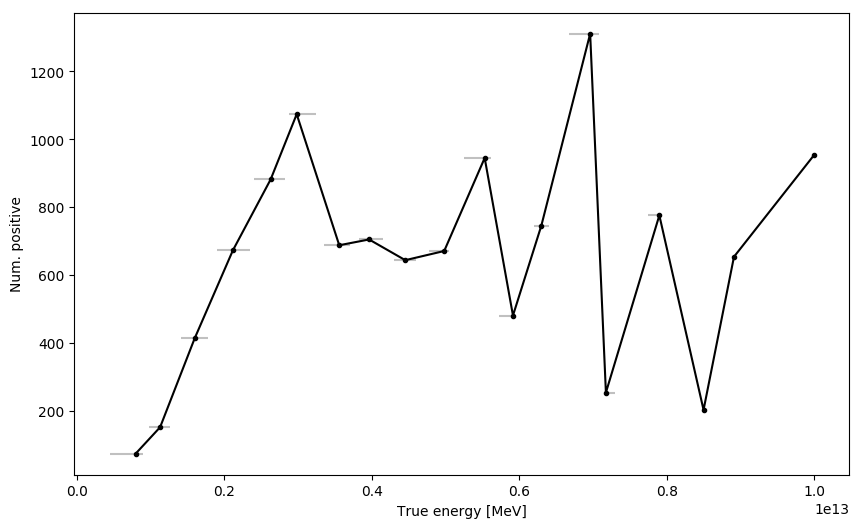

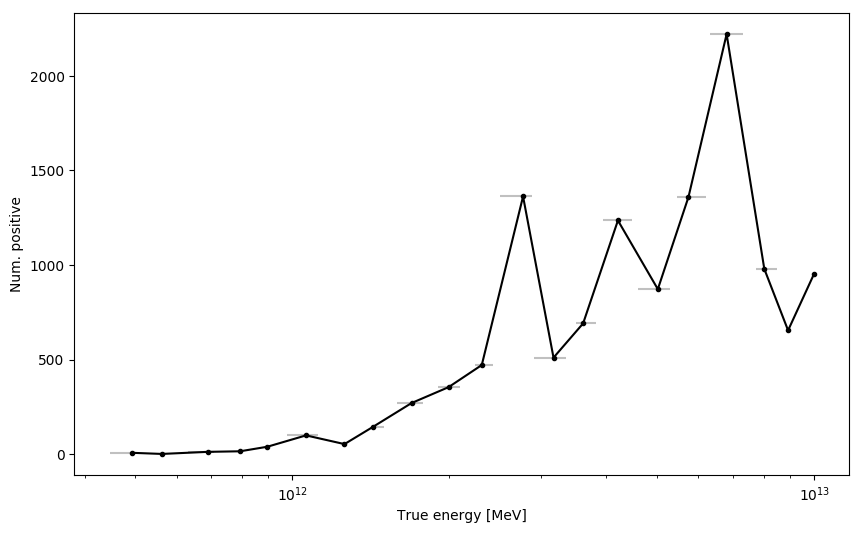

In [131]:
for xscale in ('linear', 'log'):
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__test__numbers_by_energy, 
                         plotted_stat='num_positive', num_steps = 20, xscale=xscale,
                         xlabel = 'True energy [MeV]', ylabel = 'Num. positive', 
                         figsize = (10,6))

##### Number of true positive samples as function of the energy

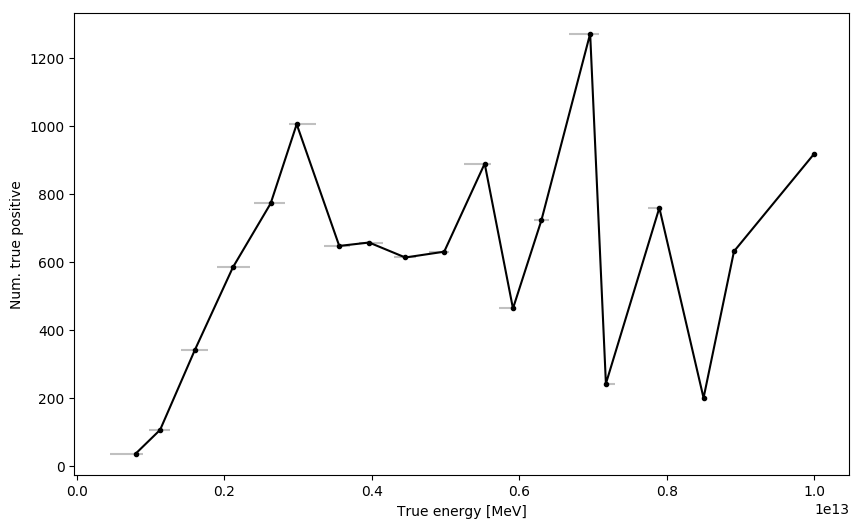

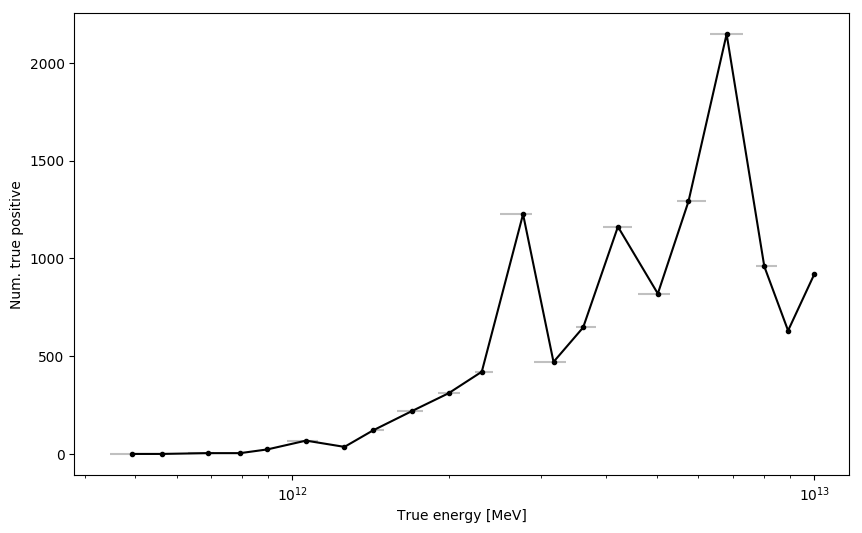

In [132]:
for xscale in ('linear', 'log'):
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__test__numbers_by_energy, 
                         plotted_stat='num_true_positive', num_steps = 20, xscale=xscale,
                         xlabel = 'True energy [MeV]', ylabel = 'Num. true positive', 
                         figsize = (10,6))

##### Number of true positive or positive samples as function of the energy - comparison

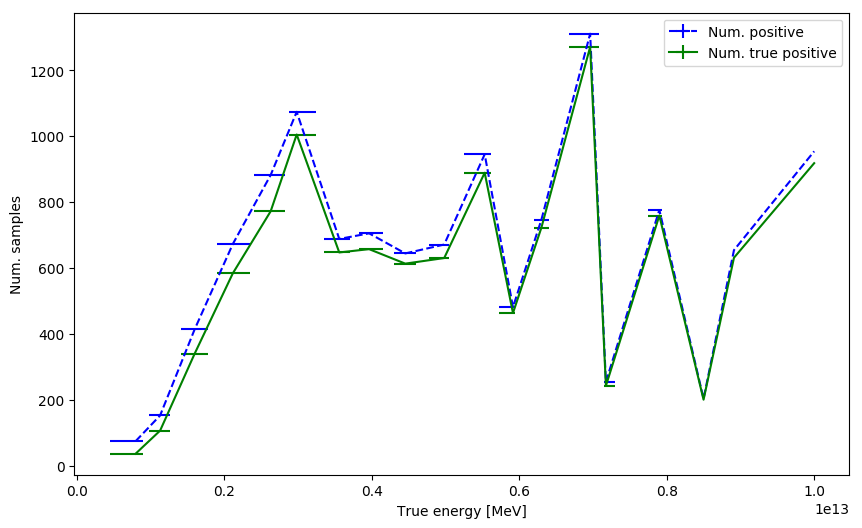

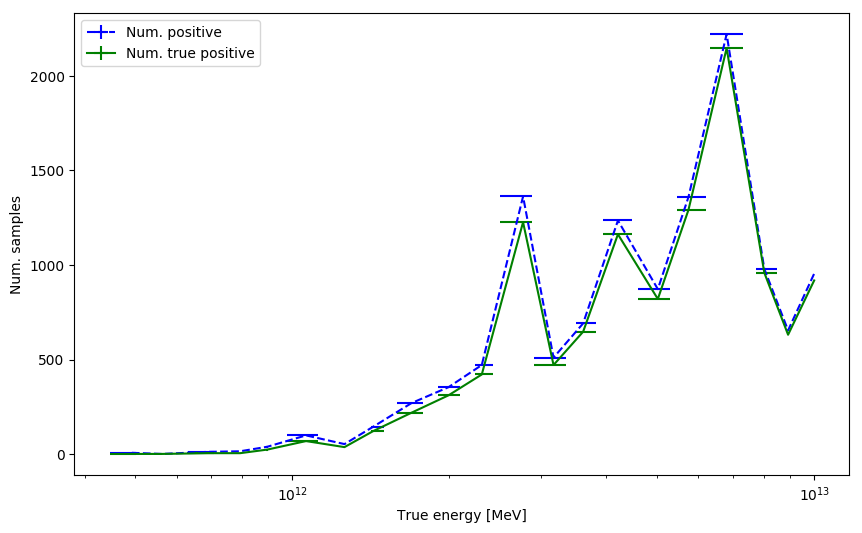

In [133]:
plt.close('all')
for xscale in ('linear', 'log'):
    fig, ax = plt.subplots()
    fig, ax, errbr_num_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__test__numbers_by_energy, 
            plotted_stat='num_positive', num_steps = 20, xscale=xscale,
            xlabel = 'True energy [MeV]', ylabel = 'Num. positive', label='Num. positive',
            figsize = (10,6), errorbar_attrs=dict(linestyle='--', color='blue'), 
            ax=ax, show=False)
    fig, ax, errbr_num_true_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__test__numbers_by_energy, 
            plotted_stat='num_true_positive', num_steps = 20, xscale=xscale,
            xlabel='True energy [MeV]', ylabel = 'Num. true positive', label='Num. true positive',
            figsize=(10,6), errorbar_attrs=dict(linestyle='-', color='green'),
            ax=ax, show=False)
    ax.set_ylabel('Num. samples')
    ax.legend()
    plt.show()

#### Test set sensitivity as function of the theta (zenith angle)

In [134]:
extra_trees_cls_on_train_rfecv__test__numbers_by_theta = \
    score_by_column(
        rfecv_selector_on_extra_trees_cls, 
        learning_data__k400best_var_th_scaled_X_test[learning_data__simu_shower_track_mask_arr_test], 
        learning_data__y_test[learning_data__simu_shower_track_mask_arr_test], 
        calc_cls_numbers,
        learning_data__event_id_test[learning_data__simu_shower_track_mask_arr_test], 
        combined_simu_df, 'etruth_truetheta')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


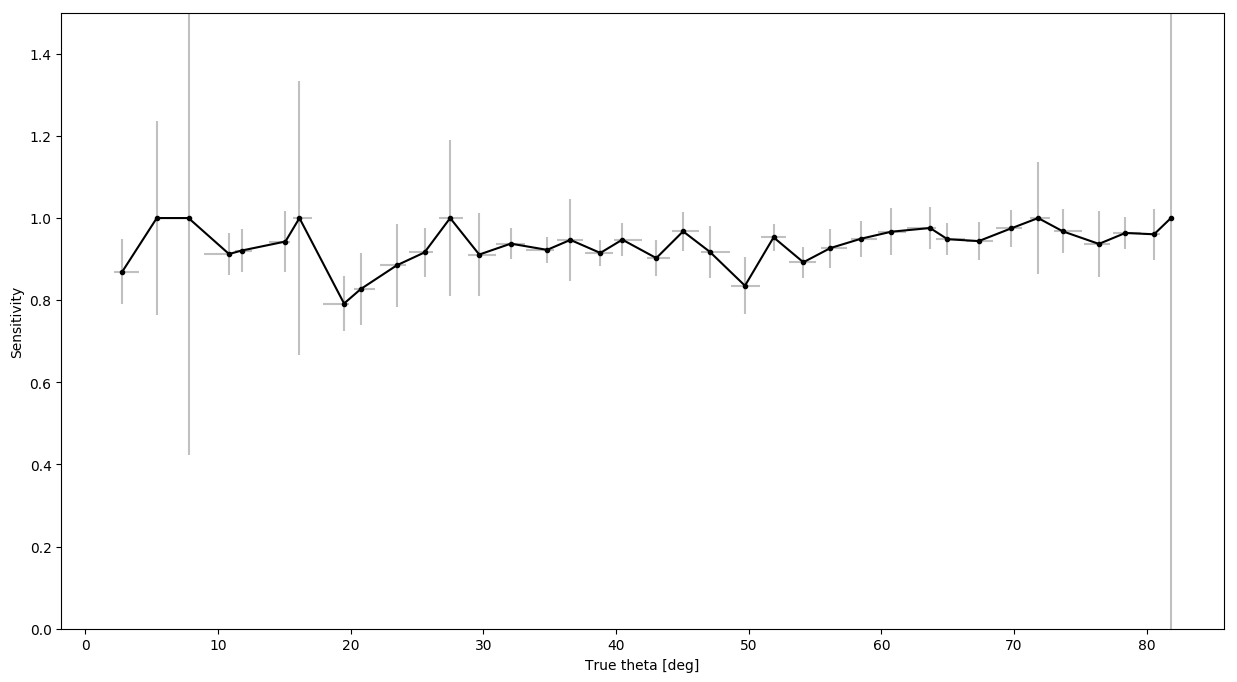

(<matplotlib.figure.Figure at 0x7fa47509db38>,
 <Container object of 3 artists>)

In [135]:
plot_efficiency_stat(extra_trees_cls_on_train_rfecv__test__numbers_by_theta, 
                     plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', num_steps = 90/2.5, 
                     xtranslate_func=np.rad2deg,
                     xlabel ='True theta [deg]', ylabel = 'Sensitivity', 
                     figsize = (15,8), ylim=(0,1.5))

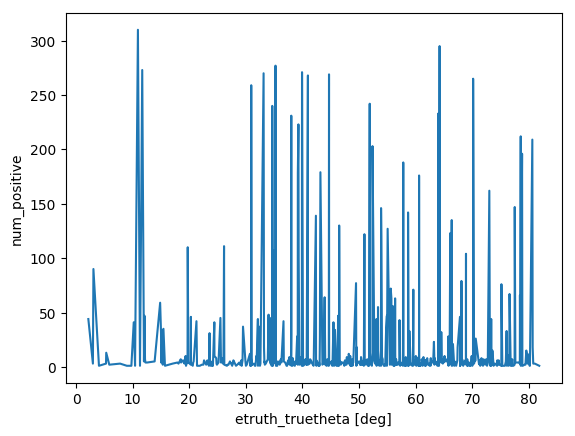

In [136]:
plt.close('all')
fig, ax = plt.subplots()
ax.plot([np.rad2deg(v) for v in extra_trees_cls_on_train_rfecv__test__numbers_by_theta.keys()], 
        [d['num_positive'] for d in extra_trees_cls_on_train_rfecv__test__numbers_by_theta.values() if d['num_positive'] is not None])
ax.set_xlabel('etruth_truetheta [deg]')
ax.set_ylabel('num_positive')
# ax.set_xscale('log')
plt.show()

#### Test set sensitivity as function of the phi (azimuth angle)

In [137]:
extra_trees_cls_on_train_rfecv__test__numbers_by_phi = \
    score_by_column(
        rfecv_selector_on_extra_trees_cls, 
        learning_data__k400best_var_th_scaled_X_test[learning_data__simu_shower_track_mask_arr_test], 
        learning_data__y_test[learning_data__simu_shower_track_mask_arr_test], 
        calc_cls_numbers,
        learning_data__event_id_test[learning_data__simu_shower_track_mask_arr_test], 
        combined_simu_df, 'etruth_truephi')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


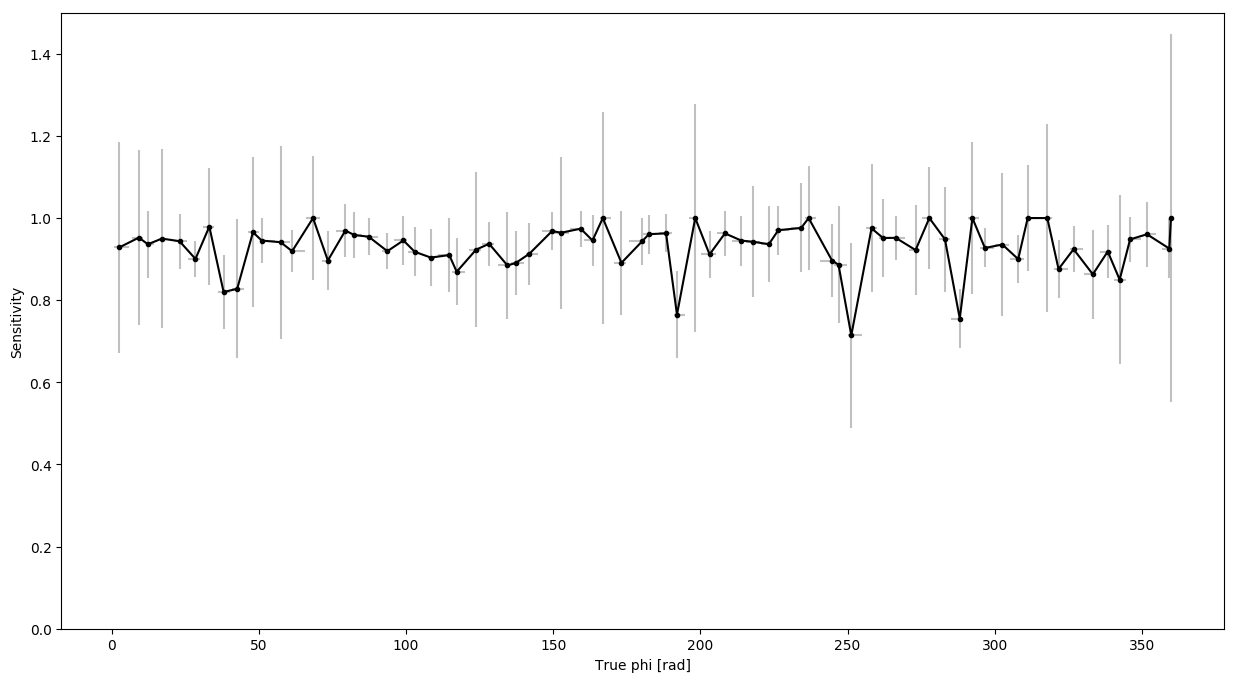

(<matplotlib.figure.Figure at 0x7fa42aa342e8>,
 <Container object of 3 artists>)

In [138]:
plt.close('all')
plot_efficiency_stat(extra_trees_cls_on_train_rfecv__test__numbers_by_phi, 
                     plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', num_steps = 360/5, 
                     xtranslate_func=np.rad2deg,
                     xlabel = 'True phi [rad]', ylabel = 'Sensitivity', 
                     figsize = (15,8), ylim=(0,1.5))

### Recognition performance on cross-validated

In [139]:
extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results = \
    cross_val_score_meta_scored(
        extra_trees_cls_on_train_rfecv_for_crossvalidation,
        learning_data__rfecv_kbest400_var_th_scaled_X, learning_data__y,
        get_func_score_by_column_using_indices(None, learning_data__event_id, combined_simu_df, 'etruth_trueenergy'),
        score_func=calc_cls_numbers,
        cv=sklearn.model_selection.RepeatedKFold(n_splits=5, n_repeats=10, random_state=123), verbose=1
    )

0
len(X_train): 49212


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.6s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12304
1
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


len(X_test): 12303
2
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


len(X_test): 12303


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


3
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.6s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
4
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
5
len(X_train): 49212


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


len(X_test): 12304


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.2s finished


6
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
7
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
8
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


len(X_test): 12303
9
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
10
len(X_train): 49212


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12304
11
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
12
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s


len(X_test): 12303


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.2s finished


13
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


len(X_test): 12303


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


14
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


len(X_test): 12303


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.2s finished


15
len(X_train): 49212


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12304
16
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
17
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
18
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
19
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s


len(X_test): 12303


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.2s finished


20
len(X_train): 49212


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12304
21
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
22
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
23
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


len(X_test): 12303


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


24
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s


len(X_test): 12303


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


25
len(X_train): 49212


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12304
26
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
27
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
28
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
29
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
30
len(X_train): 49212


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


len(X_test): 12304
31
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


len(X_test): 12303


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


32
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


len(X_test): 12303
33
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
34
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


len(X_test): 12303


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.2s finished


35
len(X_train): 49212


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s


len(X_test): 12304


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.2s finished


36
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s


len(X_test): 12303


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.2s finished


37
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
38
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
39
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.6s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


len(X_test): 12303
40
len(X_train): 49212


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.6s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12304
41
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.7s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
42
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.7s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
43
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
44
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
45
len(X_train): 49212


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12304
46
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303
47
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


len(X_test): 12303
48
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


len(X_test): 12303


[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.2s finished


49
len(X_train): 49213


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


len(X_test): 12303


#### Considering all samples from cross-validations (not very correct)

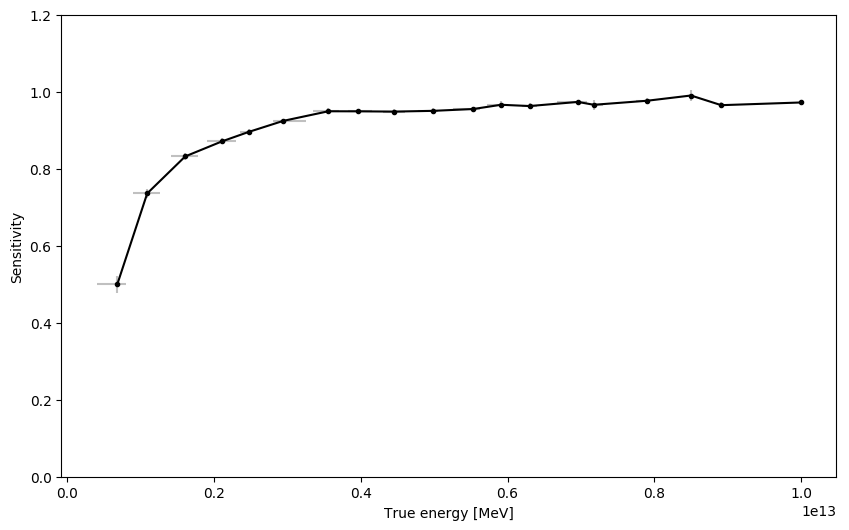

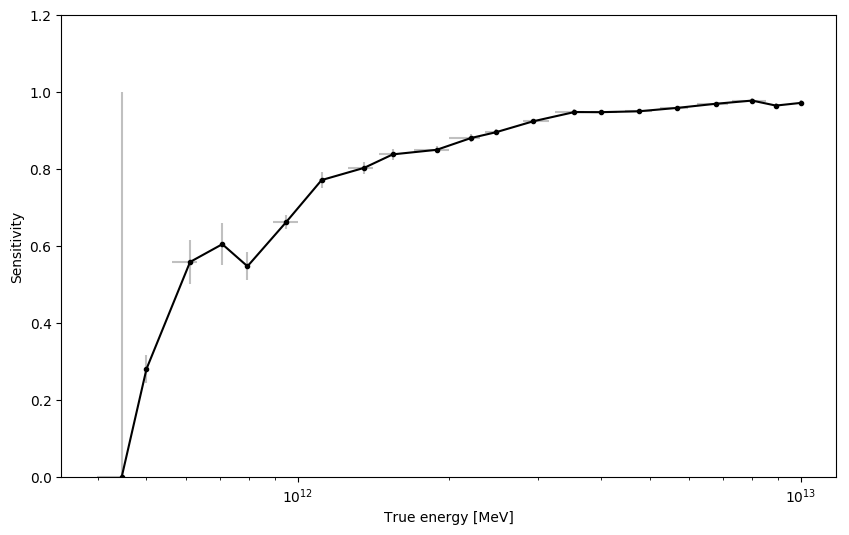

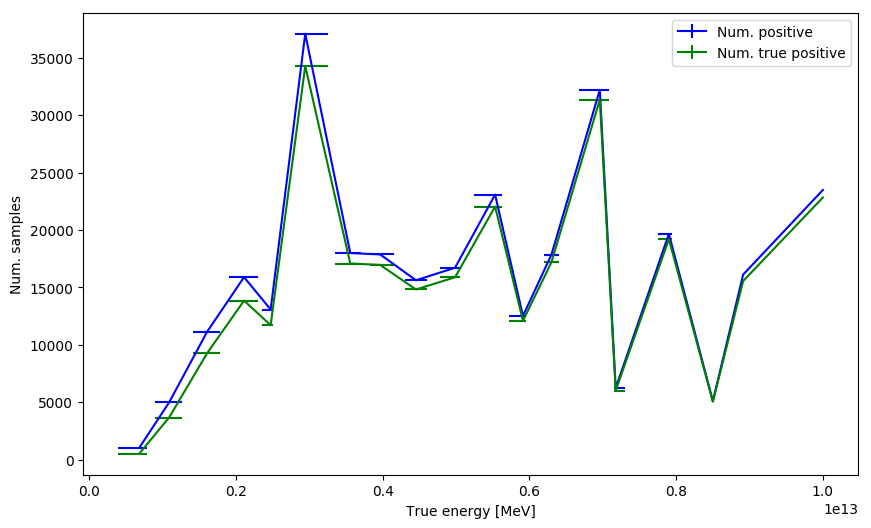

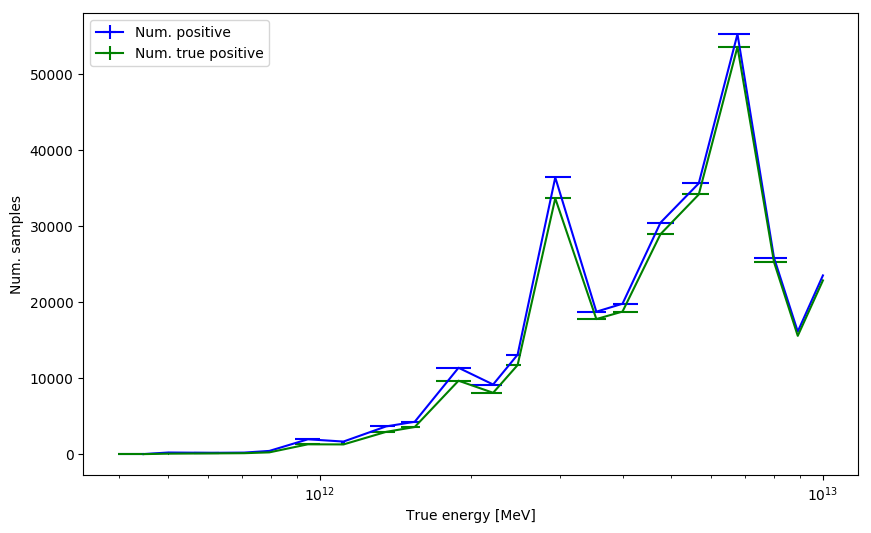

In [140]:
plt.close('all')
for xscale in ['linear', 'log']:
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
                         plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', num_steps = 20, xscale=xscale,
                         xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
                         figsize = (10,6), ylim=(0,1.2))
for xscale in ['linear', 'log']: 
    fig, ax = plt.subplots()
    fig, ax, errbr_num_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
            plotted_stat='num_positive', num_steps = 20, xscale=xscale,
            xlabel = 'True energy [MeV]', ylabel = 'Num. positive', label='Num. positive',
            figsize = (10,6), errorbar_attrs=dict(linestyle='-', color='blue'),
            ax=ax, show=False)
    fig, ax, errbr_num_true_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
            plotted_stat='num_true_positive', num_steps = 20, xscale=xscale,
            xlabel='True energy [MeV]', ylabel = 'Num. true positive', label='Num. true positive',
            figsize=(10,6), errorbar_attrs=dict(linestyle='-', color='green'),
            ax=ax, show=False)
    ax.set_ylabel('Num. samples')
    ax.legend()
    plt.show()

#### Averaging sensitivities, error is standard deviation

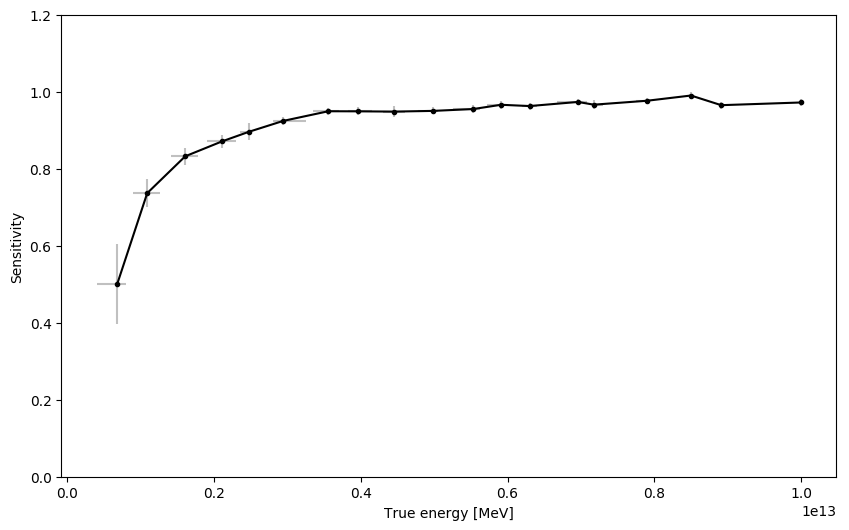

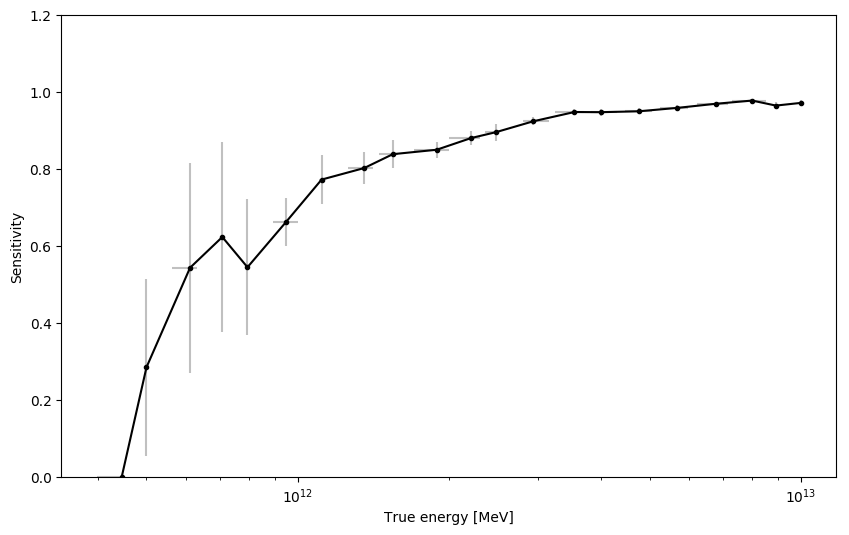

In [142]:
plt.close('all')
for xscale in ['linear', 'log']:
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
                         concat_dicts=False, dict_stats_yerr_reduce='std_y',
                         plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', 
                         num_steps = 20, xscale=xscale,
                         xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
                         figsize = (10,6), ylim=(0,1.2))

#### Averaging sensitivities, error is min-max range

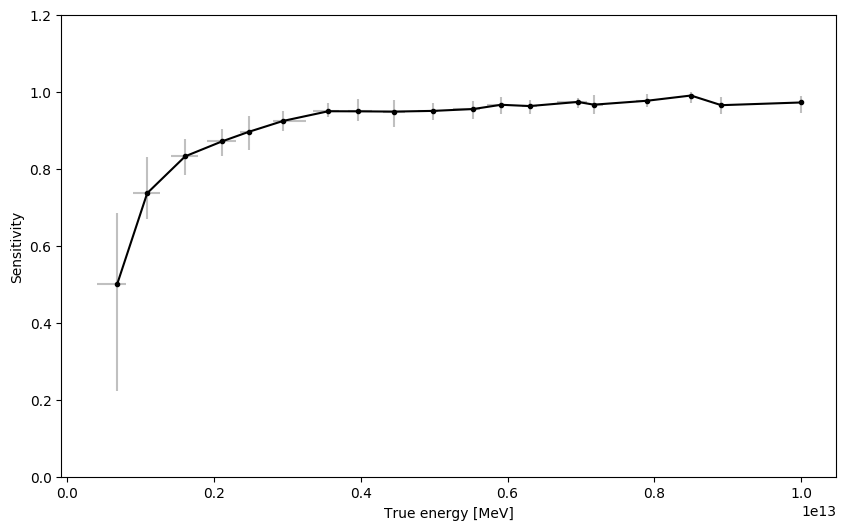

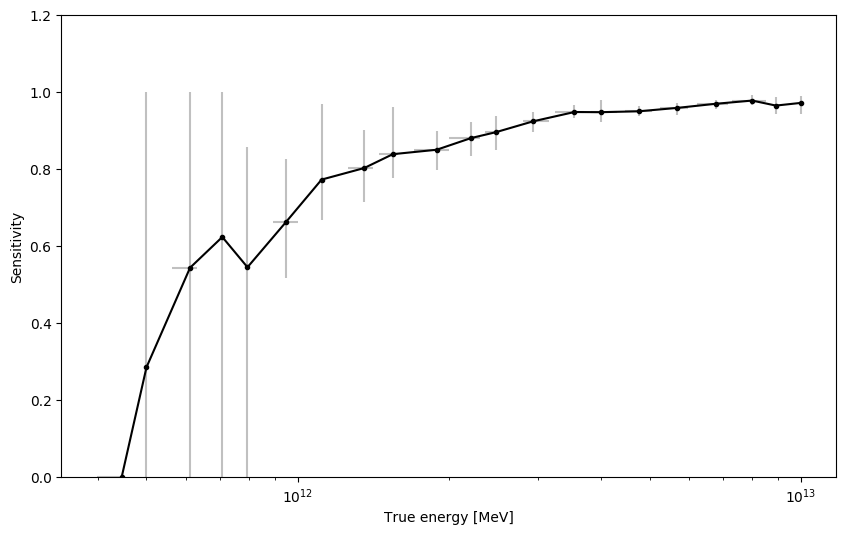

In [164]:
plt.close('all')
for xscale in ['linear', 'log']:
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
                         concat_dicts=False, dict_stats_yerr_reduce='minmax_y',
                         plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', 
                         num_steps = 20, xscale=xscale,
                         xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
                         figsize = (10,6), ylim=(0,1.2))

#### Averaging sensitivities, error is min-max range

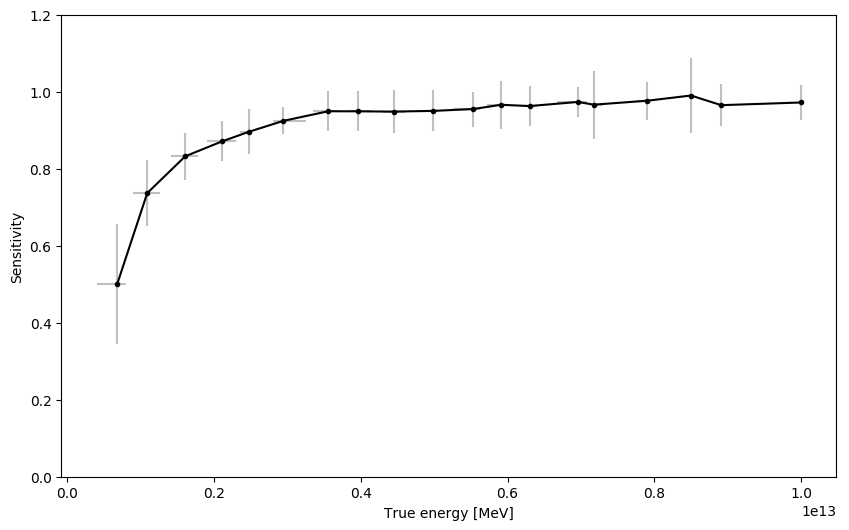

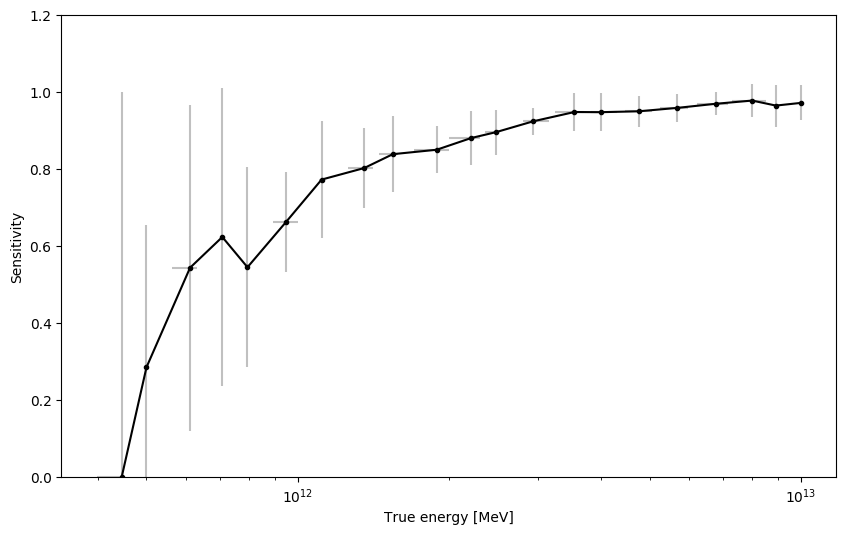

In [163]:
plt.close('all')
for xscale in ['linear', 'log']:
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
                         concat_dicts=False, dict_stats_yerr_reduce='avg_yerr_weighted',
                         plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', 
                         num_steps = 20, xscale=xscale,
                         xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
                         figsize = (10,6), ylim=(0,1.2))

In [ ]:
# plt.close('all')
# for d in extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results:
#     for xscale in ['linear','log']: 
#         plot_efficiency_stat(d, 
#                              plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', num_steps = 20, xscale=xscale,
#                              xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
#                              figsize = (10,6), ylim=(0,1.2))


In [ ]:
# lod_to_dol(list_of_dicts

# score_by_column(estimator, X_test, y_test, score_func, event_id_arr_test, combined_simu_df, groupby_column)



In [ ]:
# extra_trees_cls_on_train_kbest400_128_est__column_names

# y_test = learning_data__y_test
# y_test_pred = rfecv_selector_on_extra_trees_cls.predict(learning_data__k400best_var_th_scaled_X_test)

# y_test[learning_data__source_class_test == shower_subset_class_numbers_dict['combined_simu_df_shower_track']]


# learning_data__event_id_test[learning_data__source_class_test == shower_subset_class_numbers_dict['combined_simu_df_shower_track']]



# [learning_data__source_class_test == 1]


In [ ]:
# print(
#     len(learning_data__source_class_test == shower_subset_class_numbers_dict['combined_simu_df_shower_track']) ,
#     len(shower_subsets_list[shower_subset_priority_order.index('combined_simu_df_shower_track')]['event_id'])
# )

In [ ]:
# # test is shuffeled
# print(
#     (combined_simu_df[
#         combined_simu_df['event_id'].isin(
#             learning_data__event_id_test[
#                 (learning_data__source_class_test == shower_subset_class_numbers_dict['combined_simu_df_shower_track']) 
#             ]
#         )]['event_id']).iloc[0:5],
#     (learning_data__event_id_test[
#         (learning_data__source_class_test == shower_subset_class_numbers_dict['combined_simu_df_shower_track']) 
#     ])[0:5]
# )


In [ ]:
# unefficient

# combined_simu_indices_to_test =
#     [ np.argmax(learning_data__event_id_test == event_id) for event_id in combined_simu_df[
#         combined_simu_df['event_id'].isin(
#             learning_data__event_id_test[
#                 (learning_data__source_class_test == shower_subset_class_numbers_dict['combined_simu_df_shower_track']) 
#             ]
#         )]['event_id'] ] 
                            

In [ ]:
# # 
# combined_simu_df[
#     combined_simu_df['event_id'].isin(
#         learning_data__event_id_test[
#             (learning_data__source_class_test == shower_subset_class_numbers_dict['combined_simu_df_shower_track']) 
#         ]
#     )]


# combined_simu_df.loc[
#     combined_simu_df['event_id'].isin( combined_simu_nonan_balanced__event_id_test[ extra_trees_classifier_on_train_kbest30__y_test_pred == 1 ] ), 
#     'extra_trees_classifier_on_train_kbest30_prediction'] = 'track'

### Trees visualization

In [ ]:
# TODO
# investigate bg_...

### t-SNE

In [ ]:
 # TODO

## Recursive Feature Elimination with cross-validation (RFECV), WITHOUT K-best preselection

In [ ]:
# TODO

# X_train = learning_data__k400best_var_th_scaled_X_train
# y_train = learning_data__y_train

# X_test = learning_data__k400best_var_th_scaled_X_test
# y_test = learning_data__y_test

# column_names = learning_data__k400best_var_th_scaled_columns

# print('Num. estimators:', num_est)

# extra_trees_cls_on_train_kbest400_128_est = sklearn.ensemble.ExtraTreesClassifier(**rfe_extra_trees_params)

# rfecv_selector_on_extra_trees_cls = sklearn.feature_selection.RFECV(
#     estimator=extra_trees_cls_on_train_kbest400_128_est, 
#     step=1, 
#     verbose=1, n_jobs=-1)

# rfecv_selector_on_extra_trees_cls.fit(X_train, y_train)

## Random Forest Classifier

### Best performing features for ExtraTreesClassifier

In [ ]:
# X_train = rfe_30_selector_on_extra_trees_cls.transform(learning_data__k400best_var_th_scaled_X_train)
# y_train = learning_data__y_train

# random_forest_512est_on_best_extrcl = sklearn.ensemble.RandomForestClassifier(
#     n_estimators=512, random_state=80, verbose=1, class_weight=None, n_jobs=-1)
# # base_estimator=DecisionTreeClassifier(max_depth=1) # default
# random_forest_512est_on_best_extrcl.fit(X_train,y_train)

# # random_forest_512est_on_best_extrcl.predict(X_train)
# # random_forest_512est_on_best_extrcl__X_train = X_train
# # random_forest_512est_on_best_extrcl__y_train = y_train
# # random_forest_512est_on_best_extrcl__y_train_pred = y_train_pred

# random_forest_512est_on_best_extrcl__X_test = \
#     rfe_30_selector_on_extra_trees_cls.transform(learning_data__k400best_var_th_scaled_X_test)
# random_forest_512est_on_best_extrcl__y_test_pred = \
#    random_forest_512est_on_best_extrcl.predict(random_forest_512est_on_best_extrcl__X_test)

In [ ]:
# X_test = random_forest_512est_on_best_extrcl__X_test
# t_test_pred = random_forest_512est_on_best_extrcl__y_test_pred
# y_test = learning_data__y_test

# print(sklearn.metrics.confusion_matrix(
#     y_test, 
#     y_test_pred))

# print_accuracy_cls_report(
#     y_test, 
#     y_test_pred)

# labeled_data_cls_stats = \
#     print_labeled_data_cls_stats(
#         mask_arr_test=learning_data__lbl_noise_flight_mask_arr_test,
#         y_test=y_test,
#         y_test_pred=y_test_pred)

## AdaBoostClassifier

### Best performing features for ExtraTreesClassifier

### Default base_estimator

In [ ]:
# X_train = rfe_30_selector_on_extra_trees_cls.transform(learning_data__k400best_var_th_scaled_X_train)
# y_train = learning_data__y_train

# ada_boost_classifier_512est_on_best_extrcl = sklearn.ensemble.AdaBoostClassifier(
#     n_estimators=512, random_state=10)
# # base_estimator=DecisionTreeClassifier(max_depth=1) # default
# ada_boost_classifier_512est_on_best_extrcl.fit(X_train,y_train)

# # ada_boost_classifier_512est_on_best_extrcl.predict(X_train)
# # ada_boost_classifier_512est_on_best_extrcl__X_train = X_train
# # ada_boost_classifier_512est_on_best_extrcl__y_train = y_train
# # ada_boost_classifier_512est_on_best_extrcl__y_train_pred = y_train_pred

# ada_boost_classifier_512est_on_best_extrcl__X_test = \
#     rfe_30_selector_on_extra_trees_cls.transform(learning_data__k400best_var_th_scaled_X_test)
# ada_boost_classifier_512est_on_best_extrcl__y_test_pred = \
#     ada_boost_classifier_512est_on_best_extrcl.predict(ada_boost_classifier_512est_on_best_extrcl__X_test)

In [ ]:
# X_test = ada_boost_classifier_512est_on_best_extrcl__X_test
# t_test_pred = ada_boost_classifier_512est_on_best_extrcl__y_test_pred
# y_test = learning_data__y_test

# print(sklearn.metrics.confusion_matrix(
#     y_test, 
#     y_test_pred))

# print_accuracy_cls_report(
#     y_test, 
#     y_test_pred)

# labeled_data_cls_stats = \
#     print_labeled_data_cls_stats(
#         mask_arr_test=learning_data__lbl_noise_flight_mask_arr_test,
#         y_test=y_test,
#         y_test_pred=y_test_pred)

In [ ]:
# X_train = rfe_30_selector_on_extra_trees_cls.transform(learning_data__k400best_var_th_scaled_X_train)
# y_train = learning_data__y_train

# ada_boost_classifier_extrcl_512est_on_best_extrcl = sklearn.ensemble.AdaBoostClassifier(
#     base_estimator=sklearn.tree.ExtraTreeClassifier(), n_estimators=512, random_state=10)
# # base_estimator=DecisionTreeClassifier(max_depth=1) # default
# ada_boost_classifier_extrcl_512est_on_best_extrcl.fit(X_train,y_train)

# # ada_boost_classifier_extrcl_512est_on_best_extrcl.predict(X_train)
# # ada_boost_classifier_extrcl_512est_on_best_extrcl__X_train = X_train
# # ada_boost_classifier_extrcl_512est_on_best_extrcl__y_train = y_train
# # ada_boost_classifier_extrcl_512est_on_best_extrcl__y_train_pred = y_train_pred

# ada_boost_classifier_extrcl_512est_on_best_extrcl__X_test = \
#     rfe_30_selector_on_extra_trees_cls.transform(learning_data__k400best_var_th_scaled_X_test)
# ada_boost_classifier_extrcl_512est_on_best_extrcl__y_test_pred = \
#     ada_boost_classifier_extrcl_512est_on_best_extrcl.predict(ada_boost_classifier_extrcl_512est_on_best_extrcl__X_test)

In [ ]:
# X_test = ada_boost_classifier_extrcl_512est_on_best_extrcl__X_test
# t_test_pred = ada_boost_classifier_extrcl_512est_on_best_extrcl__y_test_pred
# y_test = learning_data__y_test

# print(sklearn.metrics.confusion_matrix(
#     y_test, 
#     y_test_pred))

# print_accuracy_cls_report(
#     y_test, 
#     y_test_pred)

# labeled_data_cls_stats = \
#     print_labeled_data_cls_stats(
#         mask_arr_test=learning_data__lbl_noise_flight_mask_arr_test,
#         y_test=y_test,
#         y_test_pred=y_test_pred)

# Visualizing trees

In [ ]:
import graphviz

In [ ]:
# num_est = 2
# for tree_n, tree_classifier in enumerate(extra_trees_cls_on_train_kbest50_few_est_dict[num_est].estimators_):
#     graphviz_image_filename = \
#         'extra_trees_cls_on_train_kbest50_{num_est:d}__tree_{tree_n:d}'.format(
#            num_est=num_est, tree_n=tree_n)
    
#     dot_data = sklearn.tree.export_graphviz(
#         tree_classifier, out_file=None, 
#         feature_names=learning_data__k50best_var_th_scaled_columns,  
#         class_names=['noise','shower'],  
#         filled=True, rounded=True,  
#         special_characters=True)
#     graph = graphviz.Source(dot_data) 
    
#     print('Rendering into {}/{}'.format(data_snippets_dir, graphviz_image_filename))
    
#     graph.render(graphviz_image_filename, data_snippets_dir, format='svg')

# Visualizing events

In [ ]:
# TODO
# single_proj_width=6 
# single_proj_height=4
# line_alpha=0.0


# # extension_func = lambda i, r, visualized_projections, fig, axs_flattened: \
# #     show_simu_event_row(i, r, print_offset=0, extra_columns=[], vis_xy=True, vis_gtux=True, vis_gtuy=True,
# #                         npy_pathname_column=npy_pathname_column, 
# #                         single_proj_width=single_proj_width, single_proj_height=single_proj_height,
# #                         print_info=False, warn_if_not_exact_simu=False)

# events_to_vis_df = combined_simu_df[combined_simu_df['event_id'].isin(combined_simu_nonan_balanced__event_id_test)].sort_values('rank', ascending=True)
# print('len(events_to_vis_df) =', len(events_to_vis_df))
# print('-'*50)

# def print_classification(i, r, visualized_projections, fig, axs_flattened):
#     loc = np.argmax(combined_simu_nonan_balanced__event_id_test == r['event_id'])
#     event_id_check = combined_simu_nonan_balanced__event_id_test[loc]
#     class_check = combined_simu_nonan_balanced__bin_classes_test[loc]
#     extra_trees_classifier_y_check = extra_trees_classifier_on_train_kbest30__y_test[loc]
#     mlp_classifier_y_check = extra_trees_classifier_on_train_kbest30__y_test_pred[loc]
#     extra_trees_classifier_y_pred = extra_trees_classifier_on_train_kbest30__y_test_pred[loc]
#     mlp_classifier_y_pred = mlp_classifier_on_train_kbest30__y_test_pred[loc]
    
#     print('\t----------------------------------')
#     print('\tloc =', loc )
#     print('\tevent_id_check =', event_id_check )
#     print('\tclass_check =', class_check )
#     print('\textra_trees_classifier_y_check =', extra_trees_classifier_y_check )
#     print('\tmlp_classifier_y_check =', mlp_classifier_y_check )
#     print('\textra_trees_classifier_y_pred =', extra_trees_classifier_y_pred )
#     print('\tmlp_classifier_y_pred =', mlp_classifier_y_pred )
    
# for i in range(0,3):
#     vis_events_df(
#         events_to_vis_df.iloc[i*len(events_to_vis_df)//3:], 
#         events_per_figure=10, max_figures=1, vis_gtux=True, vis_gtuy=True, 
#         close_after_vis=False, show=True, 
#         additional_printed_columns=['cond_selection_combined','num_frames_counts_gt_bg'],
#         line_columns_x_y=vis_events_line_columns_x_y, 
#         line_columns_gtu_x=vis_events_line_columns_gtu_x, 
#         line_columns_gtu_y=vis_events_line_columns_gtu_y,
#         line_colors=vis_events_line_colors, line_alpha=line_alpha,
#         by_one=True,
#         extension_func=print_classification,
#         single_proj_width=single_proj_width, single_proj_height=single_proj_height
#     )

# Flight data classification

In [ ]:
pipeline_from_trained_models__extr_rfecv_kb400_vth_scale__y_pred = \
    pipeline_from_trained_models__extr_rfecv_kb400_vth_scale.predict(
        unl_flight_df[analyzed_common_df_columns].dropna().values)

In [ ]:
print("Num. non-shower", np.count_nonzero(pipeline_from_trained_models__extr_rfecv_kb400_vth_scale__y_pred == 0))
print("Num. shower", np.count_nonzero(pipeline_from_trained_models__extr_rfecv_kb400_vth_scale__y_pred == 1))

In [ ]:
# flight_data__k50best_var_th_scaled_X = \
#     k50best_f_classif_selector_on_var_th_sc_train.transform(
#         var_th_selector_on_scaled_train.transform(
#             standard_scaler_on_train.transform(
#                 unl_flight_df[analyzed_common_df_columns].dropna().values)
#         )
#     )

# extra_trees_classifier_on_train_kbest50__X_flight = flight_data__k50best_var_th_scaled_X
# extra_trees_classifier_on_train_kbest50__y_flight_pred = \
#     extra_trees_classifier_on_train_kbest50.predict(extra_trees_classifier_on_train_kbest50__X_flight)

In [ ]:
# print("", np.count_nonzero(extra_trees_classifier_on_train_kbest50__y_flight_pred == 0))
# print("", np.count_nonzero(extra_trees_classifier_on_train_kbest50__y_flight_pred == 1))

In [ ]:
# combined_simu_nonan_w_event_id_class_df = \
#     combined_simu_df[analyzed_common_df_columns_w_event_id_simu_class] \
#         .query('cond_selection_combined == "simu_track" or cond_selection_combined == "noise_noise"') \
#         .dropna()

In [ ]:
# # intentionally doing query first
# combined_flight_nonan_w_event_id_class_df = \
#     combined_flight_df \
#         .query(
#             '({classification_df_cls_column_name} == {lbl_event_class_number_unclassified_noise:d}' \
#             ' or {classification_df_cls_column_name} >= {min_class_number:d}) ' \
#             'and ({classification_df_cls_column_name} not in ({event_class_shower}, {event_class_unspecified}) )'.format(
#                 classification_df_cls_column_name=classification_df_cls_column_name,
#                 lbl_event_class_number_unclassified_noise=lbl_event_class_number_unclassified_noise,
#                 min_class_number=min(EVENT_CLASSES.values()),
                
#                 event_class_shower=EVENT_CLASSES['shower'],
#                 event_class_unspecified=EVENT_CLASSES['unspecified']
#             )
#         ) \
#         [analyzed_common_df_columns_w_event_id_flight_class] \
#         .dropna()

In [ ]:
# combined_flight_nonan_w_event_id_class_df

In [ ]:
# np.concatenate([combined_simu_nonan_w_event_id_class_df['event_id'], combined_flight_nonan_w_event_id_class_df['event_id']])

In [ ]:
# np.concatenate(
#     [(combined_simu_nonan_w_event_id_class_df[simu_class_column] == 'simu_track').values.astype(np.int8),
#       combined_flight_nonan_w_event_id_class_df[flight_class_column]])

In [ ]:
# pd.concat([combined_simu_nonan_w_event_id_class_df[analyzed_common_df_columns],
#            combined_flight_nonan_w_event_id_class_df[analyzed_common_df_columns]])

In [ ]:
# combined_simu_nonan_w_event_id_class_df[analyzed_common_df_columns]
# combined_simu_nonan_w_event_id_class_df[simu_class_column]
# combined_simu_nonan_w_event_id_class_df['event_id']


# combined_flight_nonan_w_event_id_class_df[analyzed_common_df_columns]
# combined_flight_nonan_w_event_id_class_df[flight_class_column]
# combined_flight_nonan_w_event_id_class_df['event_id']


# learning_data = 

In [ ]:
# combined_simu_nonan_w_event_id_class_df

In [ ]:


# combined_simu_nonan_event_id_series = combined_simu_nonan_w_event_id_class_df['event_id']

# combined_simu_nonan_class_series = combined_simu_nonan_w_event_id_class_df[class_column]

# combined_simu_nonan_df = combined_simu_nonan_w_event_id_class_df[analyzed_common_df_columns]
# combined_simu_nonan_w_event_id_df = combined_simu_nonan_w_event_id_class_df[analyzed_common_df_columns_w_event_id]

# combined_simu_nonan__values = combined_simu_nonan_df.values
# combined_simu_nonan__bin_classes = (combined_simu_nonan_class_series == 'simu_track').values.astype(np.int8)

In [ ]:
# _combined_simu_nonan_balanced_w_event_id__values, combined_simu_nonan_balanced__bin_classes = \
#     balanced_subsample(combined_simu_nonan_w_event_id_df.values, combined_simu_nonan__bin_classes)

# combined_simu_nonan_balanced__values = _combined_simu_nonan_balanced_w_event_id__values[:,:-1]
# combined_simu_nonan_balanced__event_id = _combined_simu_nonan_balanced_w_event_id__values[:,-1]
# del _combined_simu_nonan_balanced_w_event_id__values

In [ ]:
# print('len(combined_simu_nonan_w_event_id_class_df)', len(combined_simu_nonan_w_event_id_class_df))
# print('len(combined_simu_nonan_w_event_id_class_df[simu_track])', 
#       len(combined_simu_nonan_w_event_id_class_df.query('cond_selection_combined == "simu_track"')))
# print('len(combined_simu_nonan_w_event_id_class_df[noise_noise])', 
#       len(combined_simu_nonan_w_event_id_class_df.query('cond_selection_combined == "noise_noise"')))

In [ ]:
# print('len(combined_simu_nonan_balanced__values)', len(combined_simu_nonan_balanced__values))
# print('len(combined_simu_nonan_balanced__values[simu_track])', 
#       len(combined_simu_nonan_balanced__values[combined_simu_nonan_balanced__bin_classes == 1]))
# print('len(combined_simu_nonan_balanced__values[noise_noise])', 
#       len(combined_simu_nonan_balanced__values[combined_simu_nonan_balanced__bin_classes == 0]))

In [ ]:
# combined_simu_nonan_balanced__values_train, combined_simu_nonan_balanced__values_test, \
# combined_simu_nonan_balanced__bin_classes_train, combined_simu_nonan_balanced__bin_classes_test, \
# combined_simu_nonan_balanced__event_id_train, combined_simu_nonan_balanced__event_id_test = \
#     sklearn.model_selection.train_test_split(combined_simu_nonan_balanced__values, combined_simu_nonan_balanced__bin_classes, combined_simu_nonan_balanced__event_id,
#                                      test_size=.4, random_state=1)

In [ ]:
# print(len(combined_simu_nonan_balanced__values_train), len(combined_simu_nonan_balanced__values_test))
# print(len(combined_simu_nonan_balanced__bin_classes_train), len(combined_simu_nonan_balanced__bin_classes_test))
# print(len(combined_simu_nonan_balanced__event_id_train), len(combined_simu_nonan_balanced__event_id_test))

In [ ]:
# print(np.count_nonzero(combined_simu_nonan_balanced__bin_classes_test == 0), np.count_nonzero(combined_simu_nonan_balanced__bin_classes_test == 1))
# print(np.count_nonzero(combined_simu_nonan_balanced__bin_classes_train == 0), np.count_nonzero(combined_simu_nonan_balanced__bin_classes_train == 1))

## Scaling

In [ ]:
# combined_simu_nonan__values_scaled_minmax = scale_data(combined_simu_nonan__values, None, scaler_class=sklearn.preprocessing.MinMaxScaler)
# combined_simu_nonan_balanced__values_scaled_minmax = scale_data(combined_simu_nonan_balanced__values, None, scaler_class=sklearn.preprocessing.MinMaxScaler)
# combined_simu_nonan__values_scaled = scale_data(combined_simu_nonan__values, None)

In [ ]:
# combined_simu_nonan_balanced__values_scaled = scale_data(combined_simu_nonan_balanced__values, None)

In [ ]:
# standard_scaler_on_train = sklearn.preprocessing.StandardScaler()

# combined_simu_nonan_balanced__values_scaled_train = standard_scaler_on_train.fit_transform(combined_simu_nonan_balanced__values_train)
# combined_simu_nonan_balanced__values_scaled_test = standard_scaler_on_train.transform(combined_simu_nonan_balanced__values_test)

In [ ]:
# print(combined_simu_nonan_balanced__values_scaled_train.mean(), combined_simu_nonan_balanced__values_scaled_train.var())
# print(combined_simu_nonan_balanced__values_scaled_test.mean(), combined_simu_nonan_balanced__values_scaled_test.var())

## Feature selection

### Variance thresholding

In [ ]:
# vt_selector_balanced_scaled_on_train = sklearn.feature_selection.VarianceThreshold(.0)
# vt_selector_balanced_scaled_on_train.fit(combined_simu_nonan_balanced__values_scaled_train)
# for n, m in zip(combined_simu_nonan_df.columns.values, vt_selector_balanced_scaled_on_train.get_support()):
#     if not m:
#         print(n)
        
# combined_simu_nonan_balanced_after_vt__columns_scaled_train = combined_simu_nonan_df.columns.values[vt_selector_balanced_scaled_on_train.get_support(True)]
# combined_simu_nonan_balanced_after_vt__values_scaled_train = vt_selector_balanced_scaled_on_train.transform(combined_simu_nonan_balanced__values_scaled_train)
# combined_simu_nonan_balanced_after_vt__values_scaled_test = vt_selector_balanced_scaled_on_train.transform(combined_simu_nonan_balanced__values_scaled_test)

## K-best feature selection

In [ ]:
# train_balanced_kbest_f_classif_selector = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_classif, k=30)
# train_balanced_kbest_f_classif_selector.fit(combined_simu_nonan_balanced_after_vt__values_scaled_train, combined_simu_nonan_balanced__bin_classes_train)
# for n, m, sc in sorted(zip(combined_simu_nonan_balanced_after_vt__columns_scaled_train, train_balanced_kbest_f_classif_selector.get_support(), train_balanced_kbest_f_classif_selector.scores_), key=lambda x: x[2]):
#     if m:
#         print("{:<120} {:<}".format(n,sc))

In [ ]:
# # train_balanced_kbest_f_classif_selector
# # train_balanced_kbest_f_classif_selector.fit(combined_simu_nonan_balanced_after_vt__values_scaled_train, combined_simu_nonan_balanced__bin_classes_train)

# X_train = train_balanced_kbest_f_classif_selector.transform(combined_simu_nonan_balanced_after_vt__values_scaled_train)
# y_train = combined_simu_nonan_balanced__bin_classes_train

# X_test = train_balanced_kbest_f_classif_selector.transform(combined_simu_nonan_balanced_after_vt__values_scaled_test)
# y_test = combined_simu_nonan_balanced__bin_classes_test

# column_names = combined_simu_nonan_balanced_after_vt__columns_scaled_train[train_balanced_kbest_f_classif_selector.get_support(True)]

# extra_trees_classifier_on_train_kbest30 = sklearn.ensemble.ExtraTreesClassifier(n_estimators=512, random_state=0, verbose=1, class_weight=None, n_jobs=-1)
# extra_trees_classifier_on_train_kbest30.fit(X_train,y_train)

# y_train_pred = extra_trees_classifier_on_train_kbest30.predict(X_train)
# y_test_pred = extra_trees_classifier_on_train_kbest30.predict(X_test)

# sklearn.metrics.confusion_matrix(y_test, y_test_pred)

In [ ]:
# sklearn.metrics.accuracy_score(y_test, y_test_pred)

In [ ]:
# print(sklearn.metrics.classification_report((y_test), (y_test_pred), target_names=['noise','track']))

In [ ]:
# extra_trees_classifier_on_train_kbest30__X_train = X_train
# extra_trees_classifier_on_train_kbest30__y_train = y_train
# extra_trees_classifier_on_train_kbest30__y_train_pred = y_train_pred
# extra_trees_classifier_on_train_kbest30__X_test = X_test
# extra_trees_classifier_on_train_kbest30__y_test = y_test
# extra_trees_classifier_on_train_kbest30__y_test_pred = y_test_pred

In [ ]:
# plt.close('all')
# importances = extra_trees_classifier_on_train_kbest30.feature_importances_
# std = np.std([tree.feature_importances_ for tree in extra_trees_classifier_on_train_kbest30.estimators_],
#              axis=0)
# indices = np.argsort(importances)[::-1]

# # Print the feature ranking
# print("Feature ranking:")


# for f in range(X_train.shape[1]):
#     print("%d. feature %d - %s (%f)" % (f + 1, indices[f], column_names[indices[f]], importances[indices[f]]))

# # Plot the feature importances of the forest
# plt.figure(figsize=(30,15))
# plt.title("Feature importances")
# plt.bar(range(X_train.shape[1]), importances[indices],
#        color="r", yerr=std[indices], align="center")
# plt.xticks(range(X_train.shape[1]), indices)
# plt.xlim([-1, X_train.shape[1]])
# plt.show()

# Visualizing events

In [ ]:
# single_proj_width=6 
# single_proj_height=4
# line_alpha=0.0


# # extension_func = lambda i, r, visualized_projections, fig, axs_flattened: \
# #     show_simu_event_row(i, r, print_offset=0, extra_columns=[], vis_xy=True, vis_gtux=True, vis_gtuy=True,
# #                         npy_pathname_column=npy_pathname_column, 
# #                         single_proj_width=single_proj_width, single_proj_height=single_proj_height,
# #                         print_info=False, warn_if_not_exact_simu=False)

# events_to_vis_df = combined_simu_df[combined_simu_df['event_id'].isin(combined_simu_nonan_balanced__event_id_test)].sort_values('rank', ascending=True)
# print('len(events_to_vis_df) =', len(events_to_vis_df))
# print('-'*50)

# def print_classification(i, r, visualized_projections, fig, axs_flattened):
#     loc = np.argmax(combined_simu_nonan_balanced__event_id_test == r['event_id'])
#     event_id_check = combined_simu_nonan_balanced__event_id_test[loc]
#     class_check = combined_simu_nonan_balanced__bin_classes_test[loc]
#     extra_trees_classifier_y_check = extra_trees_classifier_on_train_kbest30__y_test[loc]
#     mlp_classifier_y_check = extra_trees_classifier_on_train_kbest30__y_test_pred[loc]
#     extra_trees_classifier_y_pred = extra_trees_classifier_on_train_kbest30__y_test_pred[loc]
#     mlp_classifier_y_pred = mlp_classifier_on_train_kbest30__y_test_pred[loc]
    
#     print('\t----------------------------------')
#     print('\tloc =', loc )
#     print('\tevent_id_check =', event_id_check )
#     print('\tclass_check =', class_check )
#     print('\textra_trees_classifier_y_check =', extra_trees_classifier_y_check )
#     print('\tmlp_classifier_y_check =', mlp_classifier_y_check )
#     print('\textra_trees_classifier_y_pred =', extra_trees_classifier_y_pred )
#     print('\tmlp_classifier_y_pred =', mlp_classifier_y_pred )
    
# for i in range(0,3):
#     vis_events_df(
#         events_to_vis_df.iloc[i*len(events_to_vis_df)//3:], 
#         events_per_figure=10, max_figures=1, vis_gtux=True, vis_gtuy=True, 
#         close_after_vis=False, show=True, 
#         additional_printed_columns=['cond_selection_combined','num_frames_counts_gt_bg'],
#         line_columns_x_y=vis_events_line_columns_x_y, 
#         line_columns_gtu_x=vis_events_line_columns_gtu_x, 
#         line_columns_gtu_y=vis_events_line_columns_gtu_y,
#         line_colors=vis_events_line_colors, line_alpha=line_alpha,
#         by_one=True,
#         extension_func=print_classification,
#         single_proj_width=single_proj_width, single_proj_height=single_proj_height
#     )

# Recognition efficiency

## Adding classification informations as columns

In [ ]:
# combined_simu_df['learning_set'] = 'undefined'
# combined_simu_df.loc[combined_simu_df['event_id'].isin(combined_simu_nonan_balanced__event_id_test), 'learning_set'] = 'test'
# combined_simu_df.loc[combined_simu_df['event_id'].isin(combined_simu_nonan_balanced__event_id_train), 'learning_set'] = 'train'

# combined_simu_df['extra_trees_classifier_on_train_kbest30_prediction'] = 'undefined'
# combined_simu_df.loc[
#     combined_simu_df['event_id'].isin( combined_simu_nonan_balanced__event_id_test[ extra_trees_classifier_on_train_kbest30__y_test_pred == 1 ] ), 
#     'extra_trees_classifier_on_train_kbest30_prediction'] = 'track'
# combined_simu_df.loc[
#     combined_simu_df['event_id'].isin( combined_simu_nonan_balanced__event_id_test[ extra_trees_classifier_on_train_kbest30__y_test_pred == 0 ] ), 
#     'extra_trees_classifier_on_train_kbest30_prediction'] = 'noise'
# combined_simu_df.loc[
#     combined_simu_df['event_id'].isin( combined_simu_nonan_balanced__event_id_train[ extra_trees_classifier_on_train_kbest30__y_train_pred == 1 ] ), 
#     'extra_trees_classifier_on_train_kbest30_prediction'] = 'track'
# combined_simu_df.loc[
#     combined_simu_df['event_id'].isin( combined_simu_nonan_balanced__event_id_train[ extra_trees_classifier_on_train_kbest30__y_train_pred == 0 ] ), 
#     'extra_trees_classifier_on_train_kbest30_prediction'] = 'noise'

# combined_simu_df['mlp_classifier_on_train_kbest30_prediction'] = 'undefined'
# combined_simu_df.loc[
#     combined_simu_df['event_id'].isin( combined_simu_nonan_balanced__event_id_test[ mlp_classifier_on_train_kbest30__y_test_pred == 1 ] ), 
#     'mlp_classifier_on_train_kbest30_prediction'] = 'track'
# combined_simu_df.loc[
#     combined_simu_df['event_id'].isin( combined_simu_nonan_balanced__event_id_test[ mlp_classifier_on_train_kbest30__y_test_pred == 0 ] ), 
#     'mlp_classifier_on_train_kbest30_prediction'] = 'noise'
# combined_simu_df.loc[
#     combined_simu_df['event_id'].isin( combined_simu_nonan_balanced__event_id_train[ mlp_classifier_on_train_kbest30__y_train_pred == 1 ] ), 
#     'mlp_classifier_on_train_kbest30_prediction'] = 'track'
# combined_simu_df.loc[
#     combined_simu_df['event_id'].isin( combined_simu_nonan_balanced__event_id_train[ mlp_classifier_on_train_kbest30__y_train_pred == 0 ] ), 
#     'mlp_classifier_on_train_kbest30_prediction'] = 'noise'


In [ ]:
# print('len(learning_set == "test")', len(combined_simu_df.query('learning_set == "test"')))
# print('len(learning_set == "train")', len(combined_simu_df.query('learning_set == "train"')))
# print()
# print('len(learning_set == "test" and extra_trees_classifier_on_train_kbest30_prediction == "track")', 
#       len(combined_simu_df.query('learning_set == "test" and extra_trees_classifier_on_train_kbest30_prediction == "track"')))
# print('len(learning_set == "train" and extra_trees_classifier_on_train_kbest30_prediction == "track")', 
#       len(combined_simu_df.query('learning_set == "train" and extra_trees_classifier_on_train_kbest30_prediction == "track"')))
# print('len(learning_set == "test" and extra_trees_classifier_on_train_kbest30_prediction == "noise")', 
#       len(combined_simu_df.query('learning_set == "test" and extra_trees_classifier_on_train_kbest30_prediction == "noise"')))
# print('len(learning_set == "train" and extra_trees_classifier_on_train_kbest30_prediction == "noise")', 
#       len(combined_simu_df.query('learning_set == "train" and extra_trees_classifier_on_train_kbest30_prediction == "noise"')))
# print()
# print()
# print('len(learning_set == "test" and extra_trees_classifier_on_train_kbest30_prediction == "track" and cond_selection_combined == "simu_track")', 
#       len(combined_simu_df.query('learning_set == "test" and extra_trees_classifier_on_train_kbest30_prediction == "track" and cond_selection_combined == "simu_track"')))
# print('len(learning_set == "train" and extra_trees_classifier_on_train_kbest30_prediction == "track" and cond_selection_combined == "simu_track")', 
#       len(combined_simu_df.query('learning_set == "train" and extra_trees_classifier_on_train_kbest30_prediction == "track" and cond_selection_combined == "simu_track"')))
# print()
# print('len(learning_set == "test" and extra_trees_classifier_on_train_kbest30_prediction == "track" and cond_selection_combined == "noise_noise")', 
#       len(combined_simu_df.query('learning_set == "test" and extra_trees_classifier_on_train_kbest30_prediction == "track" and cond_selection_combined == "noise_noise"')))
# print('len(learning_set == "train" and extra_trees_classifier_on_train_kbest30_prediction == "track" and cond_selection_combined == "noise_noise")', 
#       len(combined_simu_df.query('learning_set == "train" and extra_trees_classifier_on_train_kbest30_prediction == "track" and cond_selection_combined == "noise_noise"')))
# print()
# print()
# print('len(learning_set == "test" and extra_trees_classifier_on_train_kbest30_prediction == "noise" and cond_selection_combined == "simu_track")', 
#       len(combined_simu_df.query('learning_set == "test" and extra_trees_classifier_on_train_kbest30_prediction == "noise" and cond_selection_combined == "simu_track"')))
# print('len(learning_set == "train" and extra_trees_classifier_on_train_kbest30_prediction == "noise" and cond_selection_combined == "simu_track")', 
#       len(combined_simu_df.query('learning_set == "train" and extra_trees_classifier_on_train_kbest30_prediction == "noise" and cond_selection_combined == "simu_track"')))
# print()
# print('len(learning_set == "test" and extra_trees_classifier_on_train_kbest30_prediction == "noise" and cond_selection_combined == "noise_noise")', 
#       len(combined_simu_df.query('learning_set == "test" and extra_trees_classifier_on_train_kbest30_prediction == "noise" and cond_selection_combined == "noise_noise"')))
# print('len(learning_set == "train" and extra_trees_classifier_on_train_kbest30_prediction == "noise" and cond_selection_combined == "noise_noise")', 
#       len(combined_simu_df.query('learning_set == "train" and extra_trees_classifier_on_train_kbest30_prediction == "noise" and cond_selection_combined == "noise_noise"')))
# print()
# print()
# print()
# print('len(learning_set == "test" and mlp_classifier_on_train_kbest30_prediction == "track")', 
#       len(combined_simu_df.query('learning_set == "test" and mlp_classifier_on_train_kbest30_prediction == "track"')))
# print('len(learning_set == "train" and mlp_classifier_on_train_kbest30_prediction == "track")', 
#       len(combined_simu_df.query('learning_set == "train" and mlp_classifier_on_train_kbest30_prediction == "track"')))
# print('len(learning_set == "test" and mlp_classifier_on_train_kbest30_prediction == "noise")', 
#       len(combined_simu_df.query('learning_set == "test" and mlp_classifier_on_train_kbest30_prediction == "noise"')))
# print('len(learning_set == "train" and mlp_classifier_on_train_kbest30_prediction == "noise")', 
#       len(combined_simu_df.query('learning_set == "train" and mlp_classifier_on_train_kbest30_prediction == "noise"')))
# print()
# print()
# print('len(learning_set == "test" and mlp_classifier_on_train_kbest30_prediction == "track" and cond_selection_combined == "simu_track")', 
#       len(combined_simu_df.query('learning_set == "test" and mlp_classifier_on_train_kbest30_prediction == "track" and cond_selection_combined == "simu_track"')))
# print('len(learning_set == "train" and mlp_classifier_on_train_kbest30_prediction == "track" and cond_selection_combined == "simu_track")', 
#       len(combined_simu_df.query('learning_set == "train" and mlp_classifier_on_train_kbest30_prediction == "track" and cond_selection_combined == "simu_track"')))
# print()
# print('len(learning_set == "test" and mlp_classifier_on_train_kbest30_prediction == "track" and cond_selection_combined == "noise_noise")', 
#       len(combined_simu_df.query('learning_set == "test" and mlp_classifier_on_train_kbest30_prediction == "track" and cond_selection_combined == "noise_noise"')))
# print('len(learning_set == "train" and mlp_classifier_on_train_kbest30_prediction == "track" and cond_selection_combined == "noise_noise")', 
#       len(combined_simu_df.query('learning_set == "train" and mlp_classifier_on_train_kbest30_prediction == "track" and cond_selection_combined == "noise_noise"')))
# print()
# print()
# print('len(learning_set == "test" and mlp_classifier_on_train_kbest30_prediction == "noise" and cond_selection_combined == "simu_track")', 
#       len(combined_simu_df.query('learning_set == "test" and mlp_classifier_on_train_kbest30_prediction == "noise" and cond_selection_combined == "simu_track"')))
# print('len(learning_set == "train" and mlp_classifier_on_train_kbest30_prediction == "noise" and cond_selection_combined == "simu_track")', 
#       len(combined_simu_df.query('learning_set == "train" and mlp_classifier_on_train_kbest30_prediction == "noise" and cond_selection_combined == "simu_track"')))
# print()
# print('len(learning_set == "test" and mlp_classifier_on_train_kbest30_prediction == "noise" and cond_selection_combined == "noise_noise")', 
#       len(combined_simu_df.query('learning_set == "test" and mlp_classifier_on_train_kbest30_prediction == "noise" and cond_selection_combined == "noise_noise"')))
# print('len(learning_set == "train" and mlp_classifier_on_train_kbest30_prediction == "noise" and cond_selection_combined == "noise_noise")', 
#       len(combined_simu_df.query('learning_set == "train" and mlp_classifier_on_train_kbest30_prediction == "noise" and cond_selection_combined == "noise_noise"')))
# print()
# print()


In [ ]:
# all_by_energy = combined_simu_df.query('learning_set == "test"').groupby('etruth_trueenergy')
# positive_by_energy = combined_simu_df.query('learning_set == "test" and cond_selection_combined == "simu_track"').groupby('etruth_trueenergy')
# negative_by_energy = combined_simu_df.query('learning_set == "test" and cond_selection_combined == "noise_noise"').groupby('etruth_trueenergy')
# true_positive_by_energy = combined_simu_df.query('learning_set == "test" and extra_trees_classifier_on_train_kbest30_prediction == "track" and cond_selection_combined == "simu_track"').groupby('etruth_trueenergy')
# true_negative_by_energy = combined_simu_df.query('learning_set == "test" and extra_trees_classifier_on_train_kbest30_prediction == "noise" and cond_selection_combined == "noise_noise"').groupby('etruth_trueenergy')
# false_negative_by_energy = combined_simu_df.query('learning_set == "test" and extra_trees_classifier_on_train_kbest30_prediction == "noise" and cond_selection_combined == "simu_track"').groupby('etruth_trueenergy')
# false_positive_by_energy = combined_simu_df.query('learning_set == "test" and extra_trees_classifier_on_train_kbest30_prediction == "track" and cond_selection_combined == "noise_noise"').groupby('etruth_trueenergy')

In [ ]:
# print('len(all_by_energy) =', len(all_by_energy))
# print('len(positive_by_energy ) =', len(positive_by_energy ))
# print('len(negative_by_energy) =', len(negative_by_energy))
# print('len(true_positive_by_energy ) =', len(true_positive_by_energy ))
# print('len(true_negative_by_energy ) =', len(true_negative_by_energy ))
# print('len(false_positive_by_energy) =', len(false_positive_by_energy))
# print('len(false_negative_by_energy) =', len(false_negative_by_energy))

In [ ]:
# confusion_matrix_by_energy_df = pd.DataFrame(data=collections.OrderedDict((
#     ('etruth_trueenergy', list(all_by_energy.groups.keys())), 
#     ('all_count', all_by_energy['event_id'].count().values),
#     ('positive_count', 0),
#     ('negative_count', 0),
#     ('true_positive_count', 0),
#     ('true_negative_count', 0),
#     ('false_positive_count', 0),
#     ('false_negative_count', 0),
# #     ('true_positive_norm_count', 0),
# #     ('true_negative_norm_count', 0),
# #     ('false_positive_norm_count', 0),
# #     ('false_negative_norm_count', 0),
# )))

# positive_counts = positive_by_energy['event_id'].count()
# negative_counts = negative_by_energy['event_id'].count()
# true_positive_counts = true_positive_by_energy['event_id'].count()
# true_negative_counts = true_negative_by_energy['event_id'].count()
# false_positive_counts = false_positive_by_energy['event_id'].count()
# false_negative_counts = false_negative_by_energy['event_id'].count()

# confusion_matrix_by_energy_df['positive_count'] = confusion_matrix_by_energy_df.apply(
#     lambda x: positive_counts.loc[x['etruth_trueenergy']] if x['etruth_trueenergy'] in positive_counts.index else 0,
#     axis=1)
# confusion_matrix_by_energy_df['negative_count'] = confusion_matrix_by_energy_df.apply(
#     lambda x: negative_counts.loc[x['etruth_trueenergy']] if x['etruth_trueenergy'] in negative_counts.index else 0,
#     axis=1)
# confusion_matrix_by_energy_df['true_positive_count'] = confusion_matrix_by_energy_df.apply(
#     lambda x: true_positive_counts.loc[x['etruth_trueenergy']] if x['etruth_trueenergy'] in true_positive_counts.index else 0,
#     axis=1)
# confusion_matrix_by_energy_df['true_negative_count'] = confusion_matrix_by_energy_df.apply(
#     lambda x: true_negative_counts.loc[x['etruth_trueenergy']] if x['etruth_trueenergy'] in true_negative_counts.index else 0,
#     axis=1)
# confusion_matrix_by_energy_df['false_positive_count'] = confusion_matrix_by_energy_df.apply(
#     lambda x: false_positive_counts.loc[x['etruth_trueenergy']] if x['etruth_trueenergy'] in false_positive_counts.index else 0,
#     axis=1)
# confusion_matrix_by_energy_df['false_negative_count'] = confusion_matrix_by_energy_df.apply(
#     lambda x: false_negative_counts.loc[x['etruth_trueenergy']] if x['etruth_trueenergy'] in false_negative_counts.index else 0,
#     axis=1)

# confusion_matrix_by_energy_df['sensitivity'] = confusion_matrix_by_energy_df['true_positive_count'] / confusion_matrix_by_energy_df['positive_count']
# confusion_matrix_by_energy_df['specificity'] = confusion_matrix_by_energy_df['true_negative_count'] / confusion_matrix_by_energy_df['negative_count']
# confusion_matrix_by_energy_df['positive_predictive_value'] = confusion_matrix_by_energy_df['true_positive_count'] / (confusion_matrix_by_energy_df['true_positive_count'] + confusion_matrix_by_energy_df['false_positive_count'])
# confusion_matrix_by_energy_df['negative_predictive_value'] = confusion_matrix_by_energy_df['true_negative_count'] / (confusion_matrix_by_energy_df['true_negative_count'] + confusion_matrix_by_energy_df['false_negative_count'])

# # confusion_matrix_by_energy_df['true_positive_norm_count'] = \
# #     confusion_matrix_by_energy_df['true_positive_count'] / confusion_matrix_by_energy_df['all_count']
# # confusion_matrix_by_energy_df['true_negative_norm_count'] = \
# #     confusion_matrix_by_energy_df['true_negative_count'] / confusion_matrix_by_energy_df['all_count']
# # confusion_matrix_by_energy_df['false_positive_norm_count'] = \
# #     confusion_matrix_by_energy_df['false_positive_count'] / confusion_matrix_by_energy_df['all_count']
# # confusion_matrix_by_energy_df['false_negative_norm_count'] = \
# #     confusion_matrix_by_energy_df['false_negative_count'] / confusion_matrix_by_energy_df['all_count']

In [ ]:
# pa = confusion_matrix_by_energy_df.plot('etruth_trueenergy', 'sensitivity')
# pa.set_xscale('log')
# plt.show()

In [ ]:
# pa = confusion_matrix_by_energy_df.plot('etruth_trueenergy', 'positive_predictive_value')
# pa.set_xscale('log')
# plt.show()

In [ ]:
# TODO efficiency as function of energy